## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


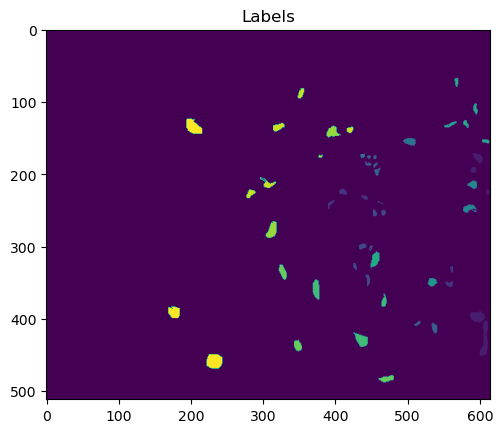

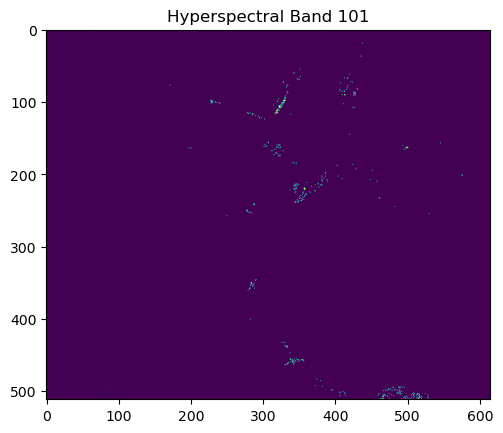

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(520, 5, 5, 176)
(65, 5, 5, 176)
(4626, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 260
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2523, PSNR: 5.9809


Epoch [1/50] Training Loss: 0.2421, PSNR: 6.1616
	[Val]   Batch [1/17] Loss: 0.2306, PSNR: 6.3716
	[Val]   Batch [10/17] Loss: 0.2308, PSNR: 6.3677
Epoch [1/50] Validation Loss: 0.2307, PSNR: 6.3699

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2255, PSNR: 6.4692


Epoch [2/50] Training Loss: 0.2082, PSNR: 6.1448
	[Val]   Batch [1/17] Loss: 0.1840, PSNR: 7.3525
	[Val]   Batch [10/17] Loss: 0.1853, PSNR: 7.3208
Epoch [2/50] Validation Loss: 0.1846, PSNR: 7.3377

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1859, PSNR: 7.3070


Epoch [3/50] Training Loss: 0.1703, PSNR: 7.6942
	[Val]   Batch [1/17] Loss: 0.1489, PSNR: 8.2699
	[Val]   Batch [10/17] Loss: 0.1526, PSNR: 8.1643
Epoch [3/50] Validation Loss: 0.1512, PSNR: 8.2038

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1498, PSNR: 8.2449


Epoch [4/50] Training Loss: 0.1372, PSNR: 8.6356
	[Val]   Batch [1/17] Loss: 0.1201, PSNR: 9.2051
	[Val]   Batch [10/17] Loss: 0.1223, PSNR: 9.1263
Epoch [4/50] Validation Loss: 0.1214, PSNR: 9.1571

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1194, PSNR: 9.2310


Epoch [5/50] Training Loss: 0.1091, PSNR: 9.6311
	[Val]   Batch [1/17] Loss: 0.0960, PSNR: 10.1788
	[Val]   Batch [10/17] Loss: 0.0979, PSNR: 10.0930
Epoch [5/50] Validation Loss: 0.0971, PSNR: 10.1269

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0945, PSNR: 10.2474


Epoch [6/50] Training Loss: 0.0868, PSNR: 9.9449
	[Val]   Batch [1/17] Loss: 0.0771, PSNR: 11.1287
	[Val]   Batch [10/17] Loss: 0.0786, PSNR: 11.0438
Epoch [6/50] Validation Loss: 0.0781, PSNR: 11.0754

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0754, PSNR: 11.2249


Epoch [7/50] Training Loss: 0.0696, PSNR: 11.5787
	[Val]   Batch [1/17] Loss: 0.0629, PSNR: 12.0161
	[Val]   Batch [10/17] Loss: 0.0634, PSNR: 11.9802
Epoch [7/50] Validation Loss: 0.0632, PSNR: 11.9897

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0614, PSNR: 12.1187


Epoch [8/50] Training Loss: 0.0567, PSNR: 12.4733
	[Val]   Batch [1/17] Loss: 0.0515, PSNR: 12.8818
	[Val]   Batch [10/17] Loss: 0.0525, PSNR: 12.8012
Epoch [8/50] Validation Loss: 0.0522, PSNR: 12.8235

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0506, PSNR: 12.9571


Epoch [9/50] Training Loss: 0.0468, PSNR: 13.3010
	[Val]   Batch [1/17] Loss: 0.0436, PSNR: 13.6071
	[Val]   Batch [10/17] Loss: 0.0443, PSNR: 13.5405
Epoch [9/50] Validation Loss: 0.0441, PSNR: 13.5526

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0420, PSNR: 13.7703


Epoch [10/50] Training Loss: 0.0393, PSNR: 14.0558
	[Val]   Batch [1/17] Loss: 0.0366, PSNR: 14.3668
	[Val]   Batch [10/17] Loss: 0.0370, PSNR: 14.3219
Epoch [10/50] Validation Loss: 0.0369, PSNR: 14.3284

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0356, PSNR: 14.4875


Epoch [11/50] Training Loss: 0.0335, PSNR: 14.7587
	[Val]   Batch [1/17] Loss: 0.0317, PSNR: 14.9827
	[Val]   Batch [10/17] Loss: 0.0323, PSNR: 14.9082
Epoch [11/50] Validation Loss: 0.0322, PSNR: 14.9228

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0306, PSNR: 15.1487


Epoch [12/50] Training Loss: 0.0289, PSNR: 15.3949
	[Val]   Batch [1/17] Loss: 0.0273, PSNR: 15.6384
	[Val]   Batch [10/17] Loss: 0.0278, PSNR: 15.5668
Epoch [12/50] Validation Loss: 0.0276, PSNR: 15.5865

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0266, PSNR: 15.7524


Epoch [13/50] Training Loss: 0.0252, PSNR: 15.9817
	[Val]   Batch [1/17] Loss: 0.0243, PSNR: 16.1375
	[Val]   Batch [10/17] Loss: 0.0247, PSNR: 16.0681
Epoch [13/50] Validation Loss: 0.0246, PSNR: 16.0887

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0233, PSNR: 16.3354


Epoch [14/50] Training Loss: 0.0223, PSNR: 16.5101
	[Val]   Batch [1/17] Loss: 0.0215, PSNR: 16.6835
	[Val]   Batch [10/17] Loss: 0.0218, PSNR: 16.6123
Epoch [14/50] Validation Loss: 0.0217, PSNR: 16.6362

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0208, PSNR: 16.8260


Epoch [15/50] Training Loss: 0.0199, PSNR: 17.0205
	[Val]   Batch [1/17] Loss: 0.0193, PSNR: 17.1545
	[Val]   Batch [10/17] Loss: 0.0196, PSNR: 17.0730
Epoch [15/50] Validation Loss: 0.0195, PSNR: 17.1087

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0186, PSNR: 17.3087


Epoch [16/50] Training Loss: 0.0179, PSNR: 17.4811
	[Val]   Batch [1/17] Loss: 0.0176, PSNR: 17.5490
	[Val]   Batch [10/17] Loss: 0.0180, PSNR: 17.4481
Epoch [16/50] Validation Loss: 0.0178, PSNR: 17.4908

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0168, PSNR: 17.7588


Epoch [17/50] Training Loss: 0.0162, PSNR: 17.2279
	[Val]   Batch [1/17] Loss: 0.0160, PSNR: 17.9614
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8723
Epoch [17/50] Validation Loss: 0.0162, PSNR: 17.9124

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0152, PSNR: 18.1913


Epoch [18/50] Training Loss: 0.0147, PSNR: 18.3232
	[Val]   Batch [1/17] Loss: 0.0143, PSNR: 18.4533
	[Val]   Batch [10/17] Loss: 0.0147, PSNR: 18.3350
Epoch [18/50] Validation Loss: 0.0145, PSNR: 18.3824

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0141, PSNR: 18.4940


Epoch [19/50] Training Loss: 0.0135, PSNR: 18.7061
	[Val]   Batch [1/17] Loss: 0.0131, PSNR: 18.8249
	[Val]   Batch [10/17] Loss: 0.0134, PSNR: 18.7352
Epoch [19/50] Validation Loss: 0.0133, PSNR: 18.7733

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0126, PSNR: 18.9958


Epoch [20/50] Training Loss: 0.0124, PSNR: 19.0754
	[Val]   Batch [1/17] Loss: 0.0121, PSNR: 19.1623
	[Val]   Batch [10/17] Loss: 0.0124, PSNR: 19.0652
Epoch [20/50] Validation Loss: 0.0123, PSNR: 19.1082

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0118, PSNR: 19.2952


Epoch [21/50] Training Loss: 0.0114, PSNR: 18.7277
	[Val]   Batch [1/17] Loss: 0.0114, PSNR: 19.4434
	[Val]   Batch [10/17] Loss: 0.0117, PSNR: 19.3332
Epoch [21/50] Validation Loss: 0.0115, PSNR: 19.3795

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0112, PSNR: 19.5149


Epoch [22/50] Training Loss: 0.0106, PSNR: 19.7461
	[Val]   Batch [1/17] Loss: 0.0104, PSNR: 19.8288
	[Val]   Batch [10/17] Loss: 0.0107, PSNR: 19.7239
Epoch [22/50] Validation Loss: 0.0105, PSNR: 19.7705

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0100, PSNR: 20.0046


Epoch [23/50] Training Loss: 0.0098, PSNR: 20.0779
	[Val]   Batch [1/17] Loss: 0.0097, PSNR: 20.1391
	[Val]   Batch [10/17] Loss: 0.0099, PSNR: 20.0254
Epoch [23/50] Validation Loss: 0.0098, PSNR: 20.0743

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0093, PSNR: 20.3059


Epoch [24/50] Training Loss: 0.0091, PSNR: 20.3922
	[Val]   Batch [1/17] Loss: 0.0091, PSNR: 20.4252
	[Val]   Batch [10/17] Loss: 0.0093, PSNR: 20.3098
Epoch [24/50] Validation Loss: 0.0092, PSNR: 20.3617

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0090, PSNR: 20.4749


Epoch [25/50] Training Loss: 0.0086, PSNR: 20.6665
	[Val]   Batch [1/17] Loss: 0.0085, PSNR: 20.7004
	[Val]   Batch [10/17] Loss: 0.0087, PSNR: 20.5870
Epoch [25/50] Validation Loss: 0.0086, PSNR: 20.6339

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9467


Epoch [26/50] Training Loss: 0.0080, PSNR: 20.9575
	[Val]   Batch [1/17] Loss: 0.0079, PSNR: 21.0305
	[Val]   Batch [10/17] Loss: 0.0081, PSNR: 20.9112
Epoch [26/50] Validation Loss: 0.0080, PSNR: 20.9674

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9900


Epoch [27/50] Training Loss: 0.0075, PSNR: 21.2263
	[Val]   Batch [1/17] Loss: 0.0075, PSNR: 21.2338
	[Val]   Batch [10/17] Loss: 0.0078, PSNR: 21.1034
Epoch [27/50] Validation Loss: 0.0077, PSNR: 21.1615

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0072, PSNR: 21.4404


Epoch [28/50] Training Loss: 0.0071, PSNR: 21.4931
	[Val]   Batch [1/17] Loss: 0.0071, PSNR: 21.5117
	[Val]   Batch [10/17] Loss: 0.0073, PSNR: 21.3637
Epoch [28/50] Validation Loss: 0.0072, PSNR: 21.4296

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0069, PSNR: 21.6174


Epoch [29/50] Training Loss: 0.0067, PSNR: 21.7377
	[Val]   Batch [1/17] Loss: 0.0066, PSNR: 21.7800
	[Val]   Batch [10/17] Loss: 0.0068, PSNR: 21.6442
Epoch [29/50] Validation Loss: 0.0067, PSNR: 21.7084

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0064, PSNR: 21.9278


Epoch [30/50] Training Loss: 0.0063, PSNR: 21.9876
	[Val]   Batch [1/17] Loss: 0.0063, PSNR: 22.0130
	[Val]   Batch [10/17] Loss: 0.0065, PSNR: 21.8625
Epoch [30/50] Validation Loss: 0.0064, PSNR: 21.9281

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0062, PSNR: 22.0541


Epoch [31/50] Training Loss: 0.0060, PSNR: 22.2321
	[Val]   Batch [1/17] Loss: 0.0060, PSNR: 22.2527
	[Val]   Batch [10/17] Loss: 0.0062, PSNR: 22.1060
Epoch [31/50] Validation Loss: 0.0061, PSNR: 22.1742

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0057, PSNR: 22.4719


Epoch [32/50] Training Loss: 0.0057, PSNR: 22.4548
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.4913
	[Val]   Batch [10/17] Loss: 0.0058, PSNR: 22.3308
Epoch [32/50] Validation Loss: 0.0058, PSNR: 22.4034

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0054, PSNR: 22.7005


Epoch [33/50] Training Loss: 0.0054, PSNR: 22.6851
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7389
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.5667
Epoch [33/50] Validation Loss: 0.0054, PSNR: 22.6464

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0052, PSNR: 22.8541


Epoch [34/50] Training Loss: 0.0051, PSNR: 22.2304
	[Val]   Batch [1/17] Loss: 0.0052, PSNR: 22.8280
	[Val]   Batch [10/17] Loss: 0.0054, PSNR: 22.6492
Epoch [34/50] Validation Loss: 0.0053, PSNR: 22.7280

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0048, PSNR: 23.1439


Epoch [35/50] Training Loss: 0.0049, PSNR: 23.1090
	[Val]   Batch [1/17] Loss: 0.0049, PSNR: 23.1299
	[Val]   Batch [10/17] Loss: 0.0051, PSNR: 22.9557
Epoch [35/50] Validation Loss: 0.0050, PSNR: 23.0367

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0049, PSNR: 23.0937


Epoch [36/50] Training Loss: 0.0047, PSNR: 22.6258
	[Val]   Batch [1/17] Loss: 0.0047, PSNR: 23.2878
	[Val]   Batch [10/17] Loss: 0.0049, PSNR: 23.0962
Epoch [36/50] Validation Loss: 0.0048, PSNR: 23.1818

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5316


Epoch [37/50] Training Loss: 0.0045, PSNR: 23.5004
	[Val]   Batch [1/17] Loss: 0.0045, PSNR: 23.4945
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.3141
Epoch [37/50] Validation Loss: 0.0046, PSNR: 23.3975

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0042, PSNR: 23.7456


Epoch [38/50] Training Loss: 0.0043, PSNR: 23.6945
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7500
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.5485
Epoch [38/50] Validation Loss: 0.0043, PSNR: 23.6395

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0040, PSNR: 23.9573


Epoch [39/50] Training Loss: 0.0041, PSNR: 23.1981
	[Val]   Batch [1/17] Loss: 0.0041, PSNR: 23.8930
	[Val]   Batch [10/17] Loss: 0.0043, PSNR: 23.6843
Epoch [39/50] Validation Loss: 0.0042, PSNR: 23.7771

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0867


Epoch [40/50] Training Loss: 0.0039, PSNR: 24.0612
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.0789
	[Val]   Batch [10/17] Loss: 0.0041, PSNR: 23.8805
Epoch [40/50] Validation Loss: 0.0040, PSNR: 23.9690

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.0915


Epoch [41/50] Training Loss: 0.0038, PSNR: 24.2393
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.2681
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.0626
Epoch [41/50] Validation Loss: 0.0038, PSNR: 24.1560

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0041, PSNR: 23.9175


Epoch [42/50] Training Loss: 0.0036, PSNR: 24.4018
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4777
	[Val]   Batch [10/17] Loss: 0.0038, PSNR: 24.2566
Epoch [42/50] Validation Loss: 0.0037, PSNR: 24.3547

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0035, PSNR: 24.5647


Epoch [43/50] Training Loss: 0.0035, PSNR: 23.8985
	[Val]   Batch [1/17] Loss: 0.0035, PSNR: 24.5314
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.3070
Epoch [43/50] Validation Loss: 0.0036, PSNR: 24.4029

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7313


Epoch [44/50] Training Loss: 0.0034, PSNR: 24.7464
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.7694
	[Val]   Batch [10/17] Loss: 0.0035, PSNR: 24.5449
Epoch [44/50] Validation Loss: 0.0034, PSNR: 24.6450

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.9145


Epoch [45/50] Training Loss: 0.0032, PSNR: 24.2208
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9079
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6500
Epoch [45/50] Validation Loss: 0.0033, PSNR: 24.7594

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1028


Epoch [46/50] Training Loss: 0.0031, PSNR: 25.0592
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1143
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.8852
Epoch [46/50] Validation Loss: 0.0032, PSNR: 24.9867

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4714


Epoch [47/50] Training Loss: 0.0030, PSNR: 25.2130
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2579
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0203
Epoch [47/50] Validation Loss: 0.0031, PSNR: 25.1188

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.0891


Epoch [48/50] Training Loss: 0.0029, PSNR: 25.3616
	[Val]   Batch [1/17] Loss: 0.0029, PSNR: 25.3601
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.1060
Epoch [48/50] Validation Loss: 0.0030, PSNR: 25.2143

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0029, PSNR: 25.4094


Epoch [49/50] Training Loss: 0.0028, PSNR: 25.5165
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.5527
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2909
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.4025

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5036


Epoch [50/50] Training Loss: 0.0027, PSNR: 25.6546
	[Val]   Batch [1/17] Loss: 0.0027, PSNR: 25.7041
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.4406
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.5537


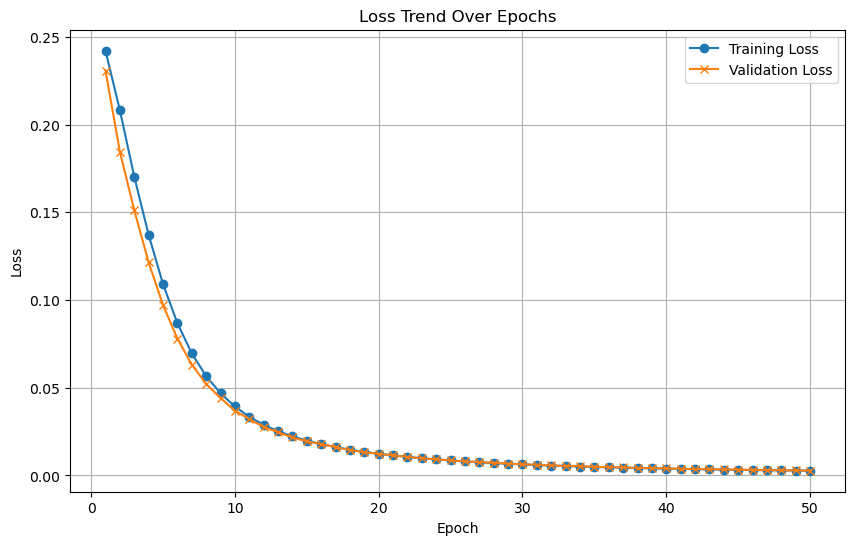

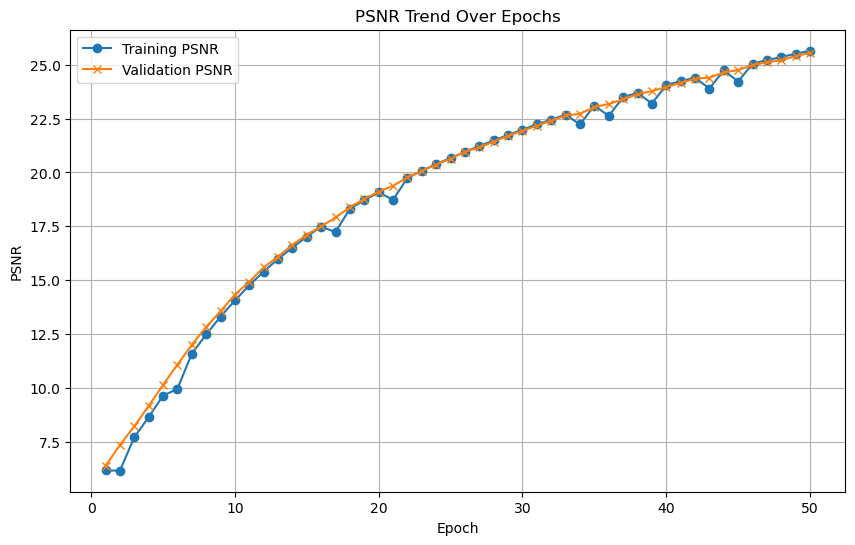

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/19 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5716
    Validation Batch [1/1], Loss: 2.5711
Validation Loss: 2.5711, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5711. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5548
    Validation Batch [1/1], Loss: 2.5710
Validation Loss: 2.5710, Validation Accuracy: 7.69%
Validation loss improved from 2.5711 to 2.5710. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5299
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Validation Accuracy: 7.69%
Validation loss improved from 2.5710 to 2.5709. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5249
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Validation Accuracy: 7.69%
Validation loss improved from 2.5709 to 2.5709. Saving model...

LOG: Epoch [5/1000] - 

Epoch [10/1000] completed, Average Training Loss: 2.4716
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [11/1000] - Training
Epoch [11/1000] completed, Average Training Loss: 2.4693
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [12/1000] - Training
Epoch [12/1000] completed, Average Training Loss: 2.4426
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [13/1000] - Training
Epoch [13/1000] completed, Average Training Loss: 2.4513
    Validation Batch [1/1], Loss: 2.5709
Validation Loss: 2.5709, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 2.4259
    Validation 

Epoch [24/1000] completed, Average Training Loss: 2.2856
    Validation Batch [1/1], Loss: 2.5634
Validation Loss: 2.5634, Validation Accuracy: 7.69%
Validation loss improved from 2.5649 to 2.5634. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2872
    Validation Batch [1/1], Loss: 2.5617
Validation Loss: 2.5617, Validation Accuracy: 7.69%
Validation loss improved from 2.5634 to 2.5617. Saving model...

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2551
    Validation Batch [1/1], Loss: 2.5600
Validation Loss: 2.5600, Validation Accuracy: 7.69%
Validation loss improved from 2.5617 to 2.5600. Saving model...

LOG: Epoch [27/1000] - Training
Epoch [27/1000] completed, Average Training Loss: 2.2678
    Validation Batch [1/1], Loss: 2.5570
Validation Loss: 2.5570, Validation Accuracy: 7.69%
Validation loss improved from 2.5600 to 2.5570. Saving model...

LOG: Epoch [28/1000] - Training
Epoch [28/10

Epoch [40/1000] completed, Average Training Loss: 2.0690
    Validation Batch [1/1], Loss: 2.3571
Validation Loss: 2.3571, Validation Accuracy: 16.92%
Validation loss improved from 2.3885 to 2.3571. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 2.0542
    Validation Batch [1/1], Loss: 2.3265
Validation Loss: 2.3265, Validation Accuracy: 21.54%
Validation loss improved from 2.3571 to 2.3265. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [42/1000] completed, Average Training Loss: 2.0182
    Validation Batch [1/1], Loss: 2.2960
Validation Loss: 2.2960, Validation Accuracy: 24.62%
Validation loss improved from 2.3265 to 2.2960. Saving model...

LOG: Epoch [43/1000] - Training
Epoch [43/1000] completed, Average Training Loss: 2.0204
    Validation Batch [1/1], Loss: 2.2691
Validation Loss: 2.2691, Validation Accuracy: 29.23%
Validation loss improved from 2.2960 to 2.2691. Saving model...

LOG: Epoch [44/1000] - Training
Epoch [4

Epoch [55/1000] completed, Average Training Loss: 1.8475
    Validation Batch [1/1], Loss: 1.9355
Validation Loss: 1.9355, Validation Accuracy: 35.38%
Validation loss improved from 1.9501 to 1.9355. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.8155
    Validation Batch [1/1], Loss: 1.9168
Validation Loss: 1.9168, Validation Accuracy: 35.38%
Validation loss improved from 1.9355 to 1.9168. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.8011
    Validation Batch [1/1], Loss: 1.8961
Validation Loss: 1.8961, Validation Accuracy: 38.46%
Validation loss improved from 1.9168 to 1.8961. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.7906
    Validation Batch [1/1], Loss: 1.8798
Validation Loss: 1.8798, Validation Accuracy: 40.00%
Validation loss improved from 1.8961 to 1.8798. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [5

Epoch [70/1000] completed, Average Training Loss: 1.5989
    Validation Batch [1/1], Loss: 1.7050
Validation Loss: 1.7050, Validation Accuracy: 49.23%
Validation loss improved from 1.7193 to 1.7050. Saving model...

LOG: Epoch [71/1000] - Training
Epoch [71/1000] completed, Average Training Loss: 1.5987
    Validation Batch [1/1], Loss: 1.6949
Validation Loss: 1.6949, Validation Accuracy: 49.23%
Validation loss improved from 1.7050 to 1.6949. Saving model...

LOG: Epoch [72/1000] - Training
Epoch [72/1000] completed, Average Training Loss: 1.5938
    Validation Batch [1/1], Loss: 1.6831
Validation Loss: 1.6831, Validation Accuracy: 50.77%
Validation loss improved from 1.6949 to 1.6831. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 1.5810
    Validation Batch [1/1], Loss: 1.6656
Validation Loss: 1.6656, Validation Accuracy: 49.23%
Validation loss improved from 1.6831 to 1.6656. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [7

Epoch [86/1000] completed, Average Training Loss: 1.3336
    Validation Batch [1/1], Loss: 1.4467
Validation Loss: 1.4467, Validation Accuracy: 61.54%
Validation loss improved from 1.4609 to 1.4467. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.3445
    Validation Batch [1/1], Loss: 1.4591
Validation Loss: 1.4591, Validation Accuracy: 63.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [88/1000] - Training
Epoch [88/1000] completed, Average Training Loss: 1.3122
    Validation Batch [1/1], Loss: 1.4356
Validation Loss: 1.4356, Validation Accuracy: 64.62%
Validation loss improved from 1.4467 to 1.4356. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 1.2905
    Validation Batch [1/1], Loss: 1.4035
Validation Loss: 1.4035, Validation Accuracy: 64.62%
Validation loss improved from 1.4356 to 1.4035. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] complet

Epoch [101/1000] completed, Average Training Loss: 1.0923
    Validation Batch [1/1], Loss: 1.2189
Validation Loss: 1.2189, Validation Accuracy: 78.46%
Validation loss improved from 1.2320 to 1.2189. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 1.0972
    Validation Batch [1/1], Loss: 1.1995
Validation Loss: 1.1995, Validation Accuracy: 78.46%
Validation loss improved from 1.2189 to 1.1995. Saving model...

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 1.0573
    Validation Batch [1/1], Loss: 1.1758
Validation Loss: 1.1758, Validation Accuracy: 80.00%
Validation loss improved from 1.1995 to 1.1758. Saving model...

LOG: Epoch [104/1000] - Training
Epoch [104/1000] completed, Average Training Loss: 1.0440
    Validation Batch [1/1], Loss: 1.1742
Validation Loss: 1.1742, Validation Accuracy: 76.92%
Validation loss improved from 1.1758 to 1.1742. Saving model...

LOG: Epoch [105/1000] - Training


Epoch [116/1000] completed, Average Training Loss: 0.8599
    Validation Batch [1/1], Loss: 1.0166
Validation Loss: 1.0166, Validation Accuracy: 80.00%
Validation loss improved from 1.0249 to 1.0166. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.8577
    Validation Batch [1/1], Loss: 1.0033
Validation Loss: 1.0033, Validation Accuracy: 75.38%
Validation loss improved from 1.0166 to 1.0033. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.8366
    Validation Batch [1/1], Loss: 0.9810
Validation Loss: 0.9810, Validation Accuracy: 80.00%
Validation loss improved from 1.0033 to 0.9810. Saving model...

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.8364
    Validation Batch [1/1], Loss: 0.9724
Validation Loss: 0.9724, Validation Accuracy: 80.00%
Validation loss improved from 0.9810 to 0.9724. Saving model...

LOG: Epoch [120/1000] - Training


Epoch [130/1000] completed, Average Training Loss: 0.7012
    Validation Batch [1/1], Loss: 0.8775
Validation Loss: 0.8775, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [131/1000] - Training
Epoch [131/1000] completed, Average Training Loss: 0.6729
    Validation Batch [1/1], Loss: 0.8588
Validation Loss: 0.8588, Validation Accuracy: 81.54%
Validation loss improved from 0.8731 to 0.8588. Saving model...

LOG: Epoch [132/1000] - Training
Epoch [132/1000] completed, Average Training Loss: 0.6636
    Validation Batch [1/1], Loss: 0.8451
Validation Loss: 0.8451, Validation Accuracy: 84.62%
Validation loss improved from 0.8588 to 0.8451. Saving model...

LOG: Epoch [133/1000] - Training
Epoch [133/1000] completed, Average Training Loss: 0.6457
    Validation Batch [1/1], Loss: 0.8646
Validation Loss: 0.8646, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Av

Epoch [145/1000] completed, Average Training Loss: 0.5457
    Validation Batch [1/1], Loss: 0.7421
Validation Loss: 0.7421, Validation Accuracy: 83.08%
Validation loss improved from 0.7506 to 0.7421. Saving model...

LOG: Epoch [146/1000] - Training
Epoch [146/1000] completed, Average Training Loss: 0.5036
    Validation Batch [1/1], Loss: 0.7461
Validation Loss: 0.7461, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 0.5063
    Validation Batch [1/1], Loss: 0.7474
Validation Loss: 0.7474, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 0.4966
    Validation Batch [1/1], Loss: 0.7380
Validation Loss: 0.7380, Validation Accuracy: 83.08%
Validation loss improved from 0.7421 to 0.7380. Saving model...

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Av

Epoch [160/1000] completed, Average Training Loss: 0.3799
    Validation Batch [1/1], Loss: 0.7249
Validation Loss: 0.7249, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [161/1000] - Training
Epoch [161/1000] completed, Average Training Loss: 0.3709
    Validation Batch [1/1], Loss: 0.6609
Validation Loss: 0.6609, Validation Accuracy: 81.54%
Validation loss improved from 0.6833 to 0.6609. Saving model...

LOG: Epoch [162/1000] - Training
Epoch [162/1000] completed, Average Training Loss: 0.3962
    Validation Batch [1/1], Loss: 0.7041
Validation Loss: 0.7041, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [163/1000] - Training
Epoch [163/1000] completed, Average Training Loss: 0.3512
    Validation Batch [1/1], Loss: 0.7122
Validation Loss: 0.7122, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [164/1000] - Training
Epoch [164/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.6504
Validation Loss: 0.6504, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.2885
    Validation Batch [1/1], Loss: 0.6484
Validation Loss: 0.6484, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.2771
    Validation Batch [1/1], Loss: 0.6623
Validation Loss: 0.6623, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [178/1000] - Training
Epoch [178/1000] completed, Average Training Loss: 0.2771
    Validation Batch [1/1], Loss: 0.6245
Validation Loss: 0.6245, Validation Accuracy: 80.00%
Validation loss improved from 0.6384 to 0.6245. Saving model...

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 0.2797
    Validation Batch [1/1], Loss: 0.6630
Vali

Epoch [190/1000] completed, Average Training Loss: 0.2140
    Validation Batch [1/1], Loss: 0.6877
Validation Loss: 0.6877, Validation Accuracy: 75.38%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.2097
    Validation Batch [1/1], Loss: 0.6058
Validation Loss: 0.6058, Validation Accuracy: 84.62%
Validation loss improved from 0.6062 to 0.6058. Saving model...

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.2029
    Validation Batch [1/1], Loss: 0.6650
Validation Loss: 0.6650, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.2092
    Validation Batch [1/1], Loss: 0.6425
Validation Loss: 0.6425, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training 

Epoch [205/1000] completed, Average Training Loss: 0.1699
    Validation Batch [1/1], Loss: 0.6155
Validation Loss: 0.6155, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [206/1000] - Training
Epoch [206/1000] completed, Average Training Loss: 0.1782
    Validation Batch [1/1], Loss: 0.6538
Validation Loss: 0.6538, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [207/1000] - Training
Epoch [207/1000] completed, Average Training Loss: 0.1450
    Validation Batch [1/1], Loss: 0.5840
Validation Loss: 0.5840, Validation Accuracy: 81.54%
Validation loss improved from 0.5939 to 0.5840. Saving model...

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.1549
    Validation Batch [1/1], Loss: 0.5840
Validation Loss: 0.5840, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training 

Epoch [214/1000] completed, Average Training Loss: 0.1411
    Validation Batch [1/1], Loss: 0.5849
Validation Loss: 0.5849, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [215/1000] - Training
Epoch [215/1000] completed, Average Training Loss: 0.1284
    Validation Batch [1/1], Loss: 0.5386
Validation Loss: 0.5386, Validation Accuracy: 84.62%
Validation loss improved from 0.5753 to 0.5386. Saving model...

LOG: Epoch [216/1000] - Training
Epoch [216/1000] completed, Average Training Loss: 0.1258
    Validation Batch [1/1], Loss: 0.5034
Validation Loss: 0.5034, Validation Accuracy: 84.62%
Validation loss improved from 0.5386 to 0.5034. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.1281
    Validation Batch [1/1], Loss: 0.5356
Validation Loss: 0.5356, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Av

Epoch [228/1000] completed, Average Training Loss: 0.1173
    Validation Batch [1/1], Loss: 0.5137
Validation Loss: 0.5137, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [229/1000] - Training
Epoch [229/1000] completed, Average Training Loss: 0.1125
    Validation Batch [1/1], Loss: 0.5204
Validation Loss: 0.5204, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.1057
    Validation Batch [1/1], Loss: 0.4763
Validation Loss: 0.4763, Validation Accuracy: 84.62%
Validation loss improved from 0.5001 to 0.4763. Saving model...

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.1099
    Validation Batch [1/1], Loss: 0.4877
Validation Loss: 0.4877, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training 

Epoch [243/1000] completed, Average Training Loss: 0.0956
    Validation Batch [1/1], Loss: 0.6694
Validation Loss: 0.6694, Validation Accuracy: 76.92%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.0933
    Validation Batch [1/1], Loss: 0.5664
Validation Loss: 0.5664, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.0791
    Validation Batch [1/1], Loss: 0.5336
Validation Loss: 0.5336, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [246/1000] - Training
Epoch [246/1000] completed, Average Training Loss: 0.0970
    Validation Batch [1/1], Loss: 0.6018
Validation Loss: 0.6018, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [247/1000] - Training
Epoch [247/1000] completed, Average Training Loss: 0.094

    Validation Batch [1/1], Loss: 0.6505
Validation Loss: 0.6505, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [258/1000] - Training
Epoch [258/1000] completed, Average Training Loss: 0.0768
    Validation Batch [1/1], Loss: 0.6295
Validation Loss: 0.6295, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0798
    Validation Batch [1/1], Loss: 0.5437
Validation Loss: 0.5437, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0815
    Validation Batch [1/1], Loss: 0.5235
Validation Loss: 0.5235, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0831
    Validation Batch [1/1], Loss: 0.5445
Validation Loss

Epoch [273/1000] completed, Average Training Loss: 0.0675
    Validation Batch [1/1], Loss: 0.5432
Validation Loss: 0.5432, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.0598
    Validation Batch [1/1], Loss: 0.5280
Validation Loss: 0.5280, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.0641
    Validation Batch [1/1], Loss: 0.5760
Validation Loss: 0.5760, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0628
    Validation Batch [1/1], Loss: 0.5616
Validation Loss: 0.5616, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.062

    Validation Batch [1/1], Loss: 0.5564
Validation Loss: 0.5564, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [288/1000] - Training
Epoch [288/1000] completed, Average Training Loss: 0.0527
    Validation Batch [1/1], Loss: 0.6040
Validation Loss: 0.6040, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.0585
    Validation Batch [1/1], Loss: 0.5589
Validation Loss: 0.5589, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.0568
    Validation Batch [1/1], Loss: 0.5234
Validation Loss: 0.5234, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.0528
    Validation Batch [1/1], Loss: 0.5699
Validation Loss

    Validation Batch [1/1], Loss: 0.5887
Validation Loss: 0.5887, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0514
    Validation Batch [1/1], Loss: 0.6539
Validation Loss: 0.6539, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.0473
    Validation Batch [1/1], Loss: 0.5921
Validation Loss: 0.5921, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.0496
    Validation Batch [1/1], Loss: 0.5978
Validation Loss: 0.5978, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.0561
    Validation Batch [1/1], Loss: 0.6783
Validation Loss

Epoch [315/1000] completed, Average Training Loss: 0.0464
    Validation Batch [1/1], Loss: 0.5344
Validation Loss: 0.5344, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [316/1000] - Training
Epoch [316/1000] completed, Average Training Loss: 0.0486
    Validation Batch [1/1], Loss: 0.5582
Validation Loss: 0.5582, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [317/1000] - Training
Epoch [317/1000] completed, Average Training Loss: 0.0399
    Validation Batch [1/1], Loss: 0.5261
Validation Loss: 0.5261, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [318/1000] - Training
Epoch [318/1000] completed, Average Training Loss: 0.0502
    Validation Batch [1/1], Loss: 0.5187
Validation Loss: 0.5187, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0440
  

Epoch [330/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.5140
Validation Loss: 0.5140, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [331/1000] - Training
Epoch [331/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.5977
Validation Loss: 0.5977, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [332/1000] - Training
Epoch [332/1000] completed, Average Training Loss: 0.0373
    Validation Batch [1/1], Loss: 0.6895
Validation Loss: 0.6895, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [333/1000] - Training
Epoch [333/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.6959
Validation Loss: 0.6959, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [334/1000] - Training
Epoch [334/1000] completed, Average Training Loss: 0.042

Epoch [345/1000] completed, Average Training Loss: 0.0336
    Validation Batch [1/1], Loss: 0.5196
Validation Loss: 0.5196, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [346/1000] - Training
Epoch [346/1000] completed, Average Training Loss: 0.0355
    Validation Batch [1/1], Loss: 0.5723
Validation Loss: 0.5723, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [347/1000] - Training
Epoch [347/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.5930
Validation Loss: 0.5930, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.0351
    Validation Batch [1/1], Loss: 0.5602
Validation Loss: 0.5602, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.034

Epoch [361/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.5543
Validation Loss: 0.5543, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 48/100

LOG: Epoch [362/1000] - Training
Epoch [362/1000] completed, Average Training Loss: 0.0309
    Validation Batch [1/1], Loss: 0.5548
Validation Loss: 0.5548, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 49/100

LOG: Epoch [363/1000] - Training
Epoch [363/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.5472
Validation Loss: 0.5472, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 50/100

LOG: Epoch [364/1000] - Training
Epoch [364/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.6385
Validation Loss: 0.6385, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.030

Epoch [375/1000] completed, Average Training Loss: 0.0272
    Validation Batch [1/1], Loss: 0.4851
Validation Loss: 0.4851, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [376/1000] - Training
Epoch [376/1000] completed, Average Training Loss: 0.0317
    Validation Batch [1/1], Loss: 0.6169
Validation Loss: 0.6169, Validation Accuracy: 81.54%
Validation loss did not improve. Patience: 63/100

LOG: Epoch [377/1000] - Training
Epoch [377/1000] completed, Average Training Loss: 0.0320
    Validation Batch [1/1], Loss: 0.8633
Validation Loss: 0.8633, Validation Accuracy: 78.46%
Validation loss did not improve. Patience: 64/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.0340
    Validation Batch [1/1], Loss: 0.6090
Validation Loss: 0.6090, Validation Accuracy: 83.08%
Validation loss did not improve. Patience: 65/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.030

Epoch [390/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.4498
Validation Loss: 0.4498, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.0293
    Validation Batch [1/1], Loss: 0.4673
Validation Loss: 0.4673, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [392/1000] - Training
Epoch [392/1000] completed, Average Training Loss: 0.0305
    Validation Batch [1/1], Loss: 0.4200
Validation Loss: 0.4200, Validation Accuracy: 89.23%
Validation loss improved from 0.4227 to 0.4200. Saving model...

LOG: Epoch [393/1000] - Training
Epoch [393/1000] completed, Average Training Loss: 0.0243
    Validation Batch [1/1], Loss: 0.4074
Validation Loss: 0.4074, Validation Accuracy: 89.23%
Validation loss improved from 0.4200 to 0.4074. Saving model...

LOG: Epoch [394/1000] - Training
Epoch [394/1000] completed, Av

Epoch [406/1000] completed, Average Training Loss: 0.0220
    Validation Batch [1/1], Loss: 0.4935
Validation Loss: 0.4935, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.0237
    Validation Batch [1/1], Loss: 0.4827
Validation Loss: 0.4827, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.0230
    Validation Batch [1/1], Loss: 0.4976
Validation Loss: 0.4976, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [409/1000] - Training
Epoch [409/1000] completed, Average Training Loss: 0.0274
    Validation Batch [1/1], Loss: 0.4960
Validation Loss: 0.4960, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [410/1000] - Training
Epoch [410/1000] completed, Average Training Loss: 0.020

Epoch [422/1000] completed, Average Training Loss: 0.0213
    Validation Batch [1/1], Loss: 0.7220
Validation Loss: 0.7220, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.0245
    Validation Batch [1/1], Loss: 0.6763
Validation Loss: 0.6763, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.5365
Validation Loss: 0.5365, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0228
    Validation Batch [1/1], Loss: 0.4733
Validation Loss: 0.4733, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.019

Epoch [437/1000] completed, Average Training Loss: 0.0200
    Validation Batch [1/1], Loss: 0.4690
Validation Loss: 0.4690, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [438/1000] - Training
Epoch [438/1000] completed, Average Training Loss: 0.0203
    Validation Batch [1/1], Loss: 0.4716
Validation Loss: 0.4716, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [439/1000] - Training
Epoch [439/1000] completed, Average Training Loss: 0.0240
    Validation Batch [1/1], Loss: 0.4633
Validation Loss: 0.4633, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0164
    Validation Batch [1/1], Loss: 0.4352
Validation Loss: 0.4352, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 46/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.016

Epoch [451/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.5102
Validation Loss: 0.5102, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [452/1000] - Training
Epoch [452/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.5636
Validation Loss: 0.5636, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [453/1000] - Training
Epoch [453/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.5579
Validation Loss: 0.5579, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [454/1000] - Training
Epoch [454/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.5017
Validation Loss: 0.5017, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.016

    Validation Batch [1/1], Loss: 0.4746
Validation Loss: 0.4746, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [466/1000] - Training
Epoch [466/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.4849
Validation Loss: 0.4849, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [467/1000] - Training
Epoch [467/1000] completed, Average Training Loss: 0.0128
    Validation Batch [1/1], Loss: 0.4813
Validation Loss: 0.4813, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [468/1000] - Training
Epoch [468/1000] completed, Average Training Loss: 0.0169
    Validation Batch [1/1], Loss: 0.5011
Validation Loss: 0.5011, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [469/1000] - Training
Epoch [469/1000] completed, Average Training Loss: 0.0168
    Validation Batch [1/1], Loss: 0.4695
Validation Loss

Epoch [481/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.4372
Validation Loss: 0.4372, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [482/1000] - Training
Epoch [482/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.4382
Validation Loss: 0.4382, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [483/1000] - Training
Epoch [483/1000] completed, Average Training Loss: 0.0145
    Validation Batch [1/1], Loss: 0.4514
Validation Loss: 0.4514, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [484/1000] - Training
Epoch [484/1000] completed, Average Training Loss: 0.0167
    Validation Batch [1/1], Loss: 0.4816
Validation Loss: 0.4816, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.017

Epoch [497/1000] completed, Average Training Loss: 0.0139
    Validation Batch [1/1], Loss: 0.4148
Validation Loss: 0.4148, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [498/1000] - Training
Epoch [498/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.4217
Validation Loss: 0.4217, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [499/1000] - Training
Epoch [499/1000] completed, Average Training Loss: 0.0143
    Validation Batch [1/1], Loss: 0.4250
Validation Loss: 0.4250, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [500/1000] - Training
Epoch [500/1000] completed, Average Training Loss: 0.0162
    Validation Batch [1/1], Loss: 0.4669
Validation Loss: 0.4669, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [501/1000] - Training
Epoch [501/1000] completed, Average Training Loss: 0.016

Epoch [512/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.5618
Validation Loss: 0.5618, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [513/1000] - Training
Epoch [513/1000] completed, Average Training Loss: 0.0151
    Validation Batch [1/1], Loss: 0.5419
Validation Loss: 0.5419, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.0179
    Validation Batch [1/1], Loss: 0.5292
Validation Loss: 0.5292, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 44/100

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0108
    Validation Batch [1/1], Loss: 0.4868
Validation Loss: 0.4868, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 45/100

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.015

Epoch [526/1000] completed, Average Training Loss: 0.0136
    Validation Batch [1/1], Loss: 0.5029
Validation Loss: 0.5029, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [527/1000] - Training
Epoch [527/1000] completed, Average Training Loss: 0.0144
    Validation Batch [1/1], Loss: 0.5405
Validation Loss: 0.5405, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0137
    Validation Batch [1/1], Loss: 0.5225
Validation Loss: 0.5225, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0134
    Validation Batch [1/1], Loss: 0.5055
Validation Loss: 0.5055, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.012

Epoch [542/1000] completed, Average Training Loss: 0.0103
    Validation Batch [1/1], Loss: 0.4169
Validation Loss: 0.4169, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [543/1000] - Training
Epoch [543/1000] completed, Average Training Loss: 0.0111
    Validation Batch [1/1], Loss: 0.4062
Validation Loss: 0.4062, Validation Accuracy: 89.23%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.4324
Validation Loss: 0.4324, Validation Accuracy: 87.69%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.4634
Validation Loss: 0.4634, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.013

Epoch [557/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.5835
Validation Loss: 0.5835, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [558/1000] - Training
Epoch [558/1000] completed, Average Training Loss: 0.0120
    Validation Batch [1/1], Loss: 0.5632
Validation Loss: 0.5632, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [559/1000] - Training
Epoch [559/1000] completed, Average Training Loss: 0.0117
    Validation Batch [1/1], Loss: 0.5421
Validation Loss: 0.5421, Validation Accuracy: 86.15%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [560/1000] - Training
Epoch [560/1000] completed, Average Training Loss: 0.0144
    Validation Batch [1/1], Loss: 0.5271
Validation Loss: 0.5271, Validation Accuracy: 84.62%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [561/1000] - Training
Epoch [561/1000] completed, Average Training Loss: 0.012

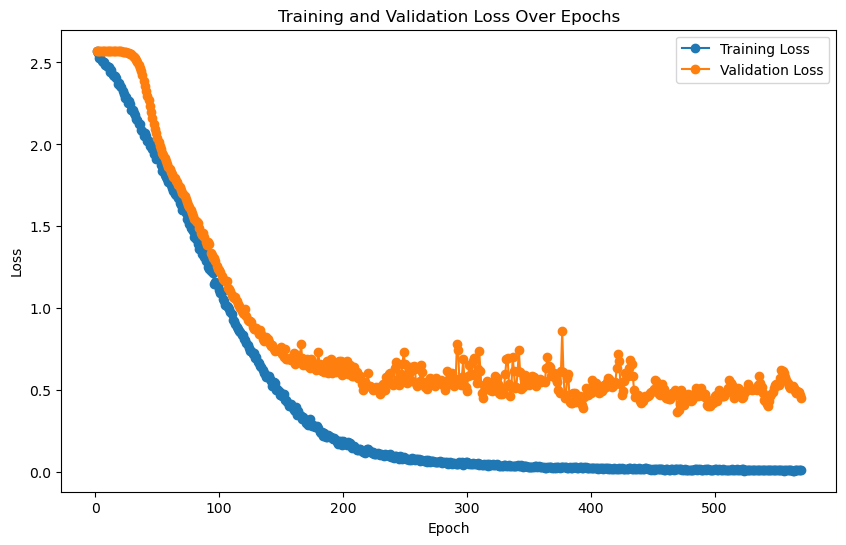

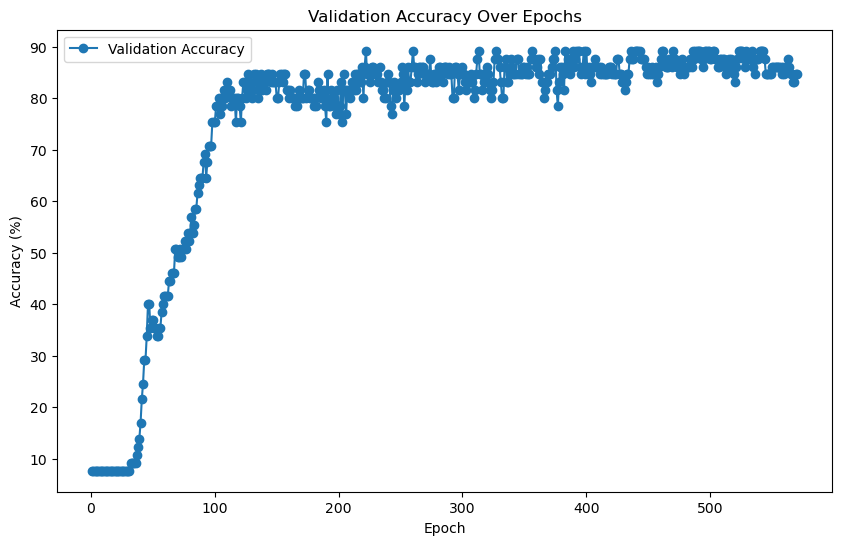


Evaluating on the test set...
    Test Batch [1/19], Loss: 0.2960

Final Test Loss: 0.6030, Test Accuracy: 87.33%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.


Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)

LOG: Training features shape: (520, 64), Training labels shape: (520,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (4626, 64), Test labels shape: (4626,)

LOG: Training Logistic Regression model...


LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 44.62%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         5
           2       0.33      0.20      0.25         5
           3       0.00      0.00      0.00         5
           4       0.22      0.40      0.29         5
           5       0.25      0.40      0.31         5
           6       0.50      0.80      0.62         5
           7       0.50      1.00      0.67         5
           8       0.57      0.80      0.67         5
           9       0.33      0.20      0.25         5
          10       0.83      1.00      0.91         5
          11       0.50      0.20      0.29         5
          12       0.57      0.80      0.67         5

    accuracy                           0.45        65
   macro avg       0.36      0.45     

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)
Train reps shape: (520, 64)
Train labels shape: (520,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (4626, 64)
Test labels shape: (4626,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5902  |  Val Loss: 2.5250
Validation loss improved from inf to 2.5250.
[Epoch 2/1000] Train Loss: 2.5131  |  Val Loss: 2.5079
Validation loss improved from 2.5250 to 2.5079.
[Epoch 3/1000] Train Loss: 2.4882  |  Val Loss: 2.4910
Validation loss improved from 2.5079 to 2.4910.
[Epoch 4/1000] Train Loss: 2.4684  |  Val Loss: 2.4776
Validation loss improved from 2.4910 to 2.4776.
[Epoch 5/1000] Train Loss: 2.4489  |  Val Loss: 2.4604
Validation loss improved from 2.4776 to 2.4604.
[Epoch 6/1000] Train Loss: 2.4302  |  Val Loss: 2.4554
Validation loss improved from 2.4604 to 2.4554.
[Epoch 7/1000] Train Loss: 2.4104  |  Val Loss: 2.4525
Validation loss improved from 2.4554 to 2.4525.


[Epoch 8/1000] Train Loss: 2.4020  |  Val Loss: 2.4517
Validation loss improved from 2.4525 to 2.4517.


[Epoch 9/1000] Train Loss: 2.3925  |  Val Loss: 2.4390
Validation loss improved from 2.4517 to 2.4390.
[Epoch 10/1000] Train Loss: 2.3866  |  Val Loss: 2.4342
Validation loss improved from 2.4390 to 2.4342.
[Epoch 11/1000] Train Loss: 2.3772  |  Val Loss: 2.4207
Validation loss improved from 2.4342 to 2.4207.


[Epoch 12/1000] Train Loss: 2.3828  |  Val Loss: 2.4210
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 13/1000] Train Loss: 2.3760  |  Val Loss: 2.4286
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 14/1000] Train Loss: 2.3634  |  Val Loss: 2.4224
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 15/1000] Train Loss: 2.3597  |  Val Loss: 2.4192
Validation loss improved from 2.4207 to 2.4192.
[Epoch 16/1000] Train Loss: 2.3574  |  Val Loss: 2.4277
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 17/1000] Train Loss: 2.3526  |  Val Loss: 2.4209
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 18/1000] Train Loss: 2.3479  |  Val Loss: 2.4088
Validation loss improved from 2.4192 to 2.4088.


[Epoch 19/1000] Train Loss: 2.3507  |  Val Loss: 2.3974
Validation loss improved from 2.4088 to 2.3974.
[Epoch 20/1000] Train Loss: 2.3437  |  Val Loss: 2.3943
Validation loss improved from 2.3974 to 2.3943.
[Epoch 21/1000] Train Loss: 2.3320  |  Val Loss: 2.3894
Validation loss improved from 2.3943 to 2.3894.


[Epoch 22/1000] Train Loss: 2.3258  |  Val Loss: 2.3821
Validation loss improved from 2.3894 to 2.3821.
[Epoch 23/1000] Train Loss: 2.3182  |  Val Loss: 2.3771
Validation loss improved from 2.3821 to 2.3771.
[Epoch 24/1000] Train Loss: 2.3097  |  Val Loss: 2.3890
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 25/1000] Train Loss: 2.3296  |  Val Loss: 2.3886
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 26/1000] Train Loss: 2.2955  |  Val Loss: 2.3730
Validation loss improved from 2.3771 to 2.3730.
[Epoch 27/1000] Train Loss: 2.2957  |  Val Loss: 2.3648
Validation loss improved from 2.3730 to 2.3648.
[Epoch 28/1000] Train Loss: 2.2843  |  Val Loss: 2.3555
Validation loss improved from 2.3648 to 2.3555.
[Epoch 29/1000] Train Loss: 2.2871  |  Val Loss: 2.3536
Validation loss improved from 2.3555 to 2.3536.
[Epoch 30/1000] Train Loss: 2.2530  |  Val Loss: 2.3156
Validation loss improved from 2.3536 to 2.3156.


[Epoch 31/1000] Train Loss: 2.2372  |  Val Loss: 2.3128
Validation loss improved from 2.3156 to 2.3128.
[Epoch 32/1000] Train Loss: 2.2237  |  Val Loss: 2.2960
Validation loss improved from 2.3128 to 2.2960.
[Epoch 33/1000] Train Loss: 2.2128  |  Val Loss: 2.2891
Validation loss improved from 2.2960 to 2.2891.


[Epoch 34/1000] Train Loss: 2.2022  |  Val Loss: 2.2679
Validation loss improved from 2.2891 to 2.2679.
[Epoch 35/1000] Train Loss: 2.1748  |  Val Loss: 2.2245
Validation loss improved from 2.2679 to 2.2245.
[Epoch 36/1000] Train Loss: 2.1308  |  Val Loss: 2.2213
Validation loss improved from 2.2245 to 2.2213.
[Epoch 37/1000] Train Loss: 2.1248  |  Val Loss: 2.1805
Validation loss improved from 2.2213 to 2.1805.
[Epoch 38/1000] Train Loss: 2.1457  |  Val Loss: 2.1820
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 2.1359  |  Val Loss: 2.1559
Validation loss improved from 2.1805 to 2.1559.
[Epoch 40/1000] Train Loss: 2.1744  |  Val Loss: 2.1189
Validation loss improved from 2.1559 to 2.1189.
[Epoch 41/1000] Train Loss: 2.0765  |  Val Loss: 2.1257
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 2.0633  |  Val Loss: 2.0914
Validation loss improved from 2.1189 to 2.0914.


[Epoch 43/1000] Train Loss: 2.0113  |  Val Loss: 2.1192
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 2.0184  |  Val Loss: 2.0605
Validation loss improved from 2.0914 to 2.0605.
[Epoch 45/1000] Train Loss: 1.9656  |  Val Loss: 2.0796
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 46/1000] Train Loss: 1.9700  |  Val Loss: 2.0379
Validation loss improved from 2.0605 to 2.0379.


[Epoch 47/1000] Train Loss: 1.9404  |  Val Loss: 2.0080
Validation loss improved from 2.0379 to 2.0080.
[Epoch 48/1000] Train Loss: 1.9141  |  Val Loss: 1.9842
Validation loss improved from 2.0080 to 1.9842.
[Epoch 49/1000] Train Loss: 1.8974  |  Val Loss: 1.9646
Validation loss improved from 1.9842 to 1.9646.
[Epoch 50/1000] Train Loss: 1.8886  |  Val Loss: 1.9654
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 1.8875  |  Val Loss: 1.9468
Validation loss improved from 1.9646 to 1.9468.
[Epoch 52/1000] Train Loss: 1.8664  |  Val Loss: 1.9390
Validation loss improved from 1.9468 to 1.9390.
[Epoch 53/1000] Train Loss: 1.8635  |  Val Loss: 1.9251
Validation loss improved from 1.9390 to 1.9251.
[Epoch 54/1000] Train Loss: 1.8478  |  Val Loss: 1.9240
Validation loss improved from 1.9251 to 1.9240.


[Epoch 55/1000] Train Loss: 1.8392  |  Val Loss: 1.9088
Validation loss improved from 1.9240 to 1.9088.
[Epoch 56/1000] Train Loss: 1.8356  |  Val Loss: 1.9122
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 1.8166  |  Val Loss: 1.9613
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 1.8086  |  Val Loss: 1.9497
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 59/1000] Train Loss: 1.8304  |  Val Loss: 1.9732
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 1.8456  |  Val Loss: 1.9780
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 61/1000] Train Loss: 1.8321  |  Val Loss: 1.9089
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 62/1000] Train Loss: 1.7970  |  Val Loss: 1.8726
Validation loss improved from 1.9088 to 1.8726.
[Epoch 63/1000] Train Loss: 1.7751  |  Val Loss: 1.8644
Validation loss improved from 1.8726 to 1.8644.
[Epoch 64/1000] Train Loss: 1.7823  |  Val Loss: 1.8579
Validation loss improved from 1.8644 to 1.8579.
[Epoch 65/1000] Train Loss: 1.7605  |  Val Loss: 1.8541
Validation loss improved from 1.8579 to 1.8541.
[Epoch 66/1000] Train Loss: 1.7665  |  Val Loss: 1.8434
Validation loss improved from 1.8541 to 1.8434.


[Epoch 67/1000] Train Loss: 1.7664  |  Val Loss: 1.8788
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 68/1000] Train Loss: 1.7952  |  Val Loss: 2.0507
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 69/1000] Train Loss: 1.8756  |  Val Loss: 1.9619
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 70/1000] Train Loss: 1.8217  |  Val Loss: 1.8629
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 71/1000] Train Loss: 1.7448  |  Val Loss: 1.8216
Validation loss improved from 1.8434 to 1.8216.
[Epoch 72/1000] Train Loss: 1.7471  |  Val Loss: 1.8546
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 73/1000] Train Loss: 1.7626  |  Val Loss: 1.8910
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 74/1000] Train Loss: 1.7516  |  Val Loss: 1.8138
Validation loss improved from 1.8216 to 1.8138.
[Epoch 75/1000] Train Loss: 1.7334  |  Val Loss: 1.8123
Validation loss improved from 1.8138 to 1.8123.
[Epoch 76/1000] Train Loss: 1.7288  |  Val Loss: 1.8202
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 77/1000] Train Loss: 1.7172  |  Val Loss: 1.8125
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 78/1000] Train Loss: 1.7017  |  Val Loss: 1.8948
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 79/1000] Train Loss: 1.7160  |  Val Loss: 1.8331
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 80/1000] Train Loss: 1.7068  |  Val Loss: 1.8083
Validation loss improved from 1.8123 to 1.8083.
[Epoch 81/1000] Train Loss: 1.7034  |  Val Loss: 1.8576
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 82/1000] Train Loss: 1.7111  |  Val Loss: 1.8302
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 83/1000] Train Loss: 1.6894  |  Val Loss: 1.8306
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 84/1000] Train Loss: 1.6846  |  Val Loss: 1.8045
Validation loss improved from 1.8083 to 1.8045.
[Epoch 85/1000] Train Loss: 1.6709  |  Val Loss: 1.9283
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 1.7135  |  Val Loss: 1.9157
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 87/1000] Train Loss: 1.7173  |  Val Loss: 1.8435
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 88/1000] Train Loss: 1.6799  |  Val Loss: 1.8744
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 89/1000] Train Loss: 1.6882  |  Val Loss: 1.9306
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 90/1000] Train Loss: 1.7193  |  Val Loss: 1.9492
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 91/1000] Train Loss: 1.6979  |  Val Loss: 1.9099
!! Validation loss did NOT improve !! Patience: 7/100


[Epoch 92/1000] Train Loss: 1.7300  |  Val Loss: 1.8321
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 93/1000] Train Loss: 1.6717  |  Val Loss: 1.8178
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 94/1000] Train Loss: 1.6851  |  Val Loss: 1.8140
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 95/1000] Train Loss: 1.6931  |  Val Loss: 1.8085
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 96/1000] Train Loss: 1.6781  |  Val Loss: 1.7840
Validation loss improved from 1.8045 to 1.7840.
[Epoch 97/1000] Train Loss: 1.6508  |  Val Loss: 1.7982
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 98/1000] Train Loss: 1.6483  |  Val Loss: 1.7896
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 99/1000] Train Loss: 1.6607  |  Val Loss: 1.8081
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 100/1000] Train Loss: 1.6593  |  Val Loss: 1.8107
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 101/1000] Train Loss: 1.6611  |  Val Loss: 1.7853
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 102/1000] Train Loss: 1.6352  |  Val Loss: 1.7745
Validation loss improved from 1.7840 to 1.7745.
[Epoch 103/1000] Train Loss: 1.6331  |  Val Loss: 1.7873
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 104/1000] 

[Epoch 105/1000] Train Loss: 1.6552  |  Val Loss: 1.7938
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 106/1000] Train Loss: 1.6448  |  Val Loss: 1.7856
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 107/1000] Train Loss: 1.6448  |  Val Loss: 1.8166
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 108/1000] Train Loss: 1.6123  |  Val Loss: 1.7831
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 109/1000] Train Loss: 1.6074  |  Val Loss: 1.7858
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 110/1000] Train Loss: 1.5979  |  Val Loss: 1.7841
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 111/1000] Train Loss: 1.6075  |  Val Loss: 1.7660
Validation loss improved from 1.7745 to 1.7660.
[Epoch 112/1000] Train Loss: 1.6184  |  Val Loss: 1.7727
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 113/1000] Train Loss: 1.6018  |  Val Loss: 1.7600
Validation loss improved from 1.7660 to 1.7600.
[Epoch 114/1000] Train Loss: 1.5884  |  Val Loss: 1.8688
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 115/1000] Train Loss: 1.6047  |  Val Loss: 1.8186
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 116/1000] Train Loss: 1.6051  |  Val Loss: 1.7674
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 117/1000] Train Loss: 1.6112  |  Val Loss: 1.8431
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 118/1000] Train Loss: 1.6201  |  Val Loss: 1.9224
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 119/1000] Train Loss: 1.7162  |  Val Loss: 1.7881
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 120/1000] Train Loss: 1.5806  |  Val Loss: 1.7693
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 121/1000] Train Loss: 1.5859  |  Val Loss: 1.7556
Validation loss improved from 1.7600 to 1.7556.
[Epoch 122/1000] Train Loss: 1.5846  |  Val Loss: 1.7799
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 1.6158  |  Val Loss: 1.8969
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 1.6160  |  Val Loss: 1.7694
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 125/1000] Train Loss: 1.5949  |  Val Loss: 1.7639
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 

[Epoch 127/1000] Train Loss: 1.5682  |  Val Loss: 1.7596
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 1.5660  |  Val Loss: 1.8248
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 129/1000] Train Loss: 1.5930  |  Val Loss: 1.8444
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 130/1000] Train Loss: 1.5812  |  Val Loss: 1.7856
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 131/1000] Train Loss: 1.5761  |  Val Loss: 1.7615
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 132/1000] Train Loss: 1.5530  |  Val Loss: 1.8998
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 133/1000] Train Loss: 1.6082  |  Val Loss: 1.7500
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 134/1000] Train Loss: 1.5490  |  Val Loss: 1.7582
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 135/1000] Train Loss: 1.5616  |  Val Loss: 1.7717
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 139/1000] Train Loss: 1.5438  |  Val Loss: 1.7770
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 1.5963  |  Val Loss: 1.8190
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 141/1000] Train Loss: 1.5765  |  Val Loss: 1.8434
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 142/1000] Train Loss: 1.5647  |  Val Loss: 1.8246
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 143/1000] Train Loss: 1.6185  |  Val Loss: 2.0471
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 144/1000] Train Loss: 1.6305  |  Val Loss: 1.8484
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 145/1000] Train Loss: 1.5785  |  Val Loss: 1.7413
Validation loss improved from 1.7448 to 1.7413.
[Epoch 146/1000] Train Loss: 1.5550  |  Val Loss: 1.8138
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 147/1000] Train Loss: 1.5844  |  Val Loss: 1.7397
Validation loss improved from 1.7413 to 1.7397.
[Epoch 148/10

[Epoch 151/1000] Train Loss: 1.5337  |  Val Loss: 1.8431
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 1.5656  |  Val Loss: 1.8230
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 153/1000] Train Loss: 1.5549  |  Val Loss: 1.7639
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 154/1000] Train Loss: 1.5215  |  Val Loss: 1.8037
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 155/1000] Train Loss: 1.5491  |  Val Loss: 1.7966
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 156/1000] Train Loss: 1.5608  |  Val Loss: 1.8135
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 157/1000] Train Loss: 1.5811  |  Val Loss: 1.7516
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 158/1000] Train Loss: 1.5054  |  Val Loss: 1.7699
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 1.5312  |  Val Loss: 1.7807
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 163/1000] Train Loss: 1.5084  |  Val Loss: 1.7339
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 164/1000] Train Loss: 1.4918  |  Val Loss: 1.7864
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 165/1000] Train Loss: 1.5081  |  Val Loss: 1.7294
Validation loss improved from 1.7319 to 1.7294.
[Epoch 166/1000] Train Loss: 1.4890  |  Val Loss: 1.7955
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 1.5124  |  Val Loss: 1.7523
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 168/1000] Train Loss: 1.5301  |  Val Loss: 1.7524
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 169/1000] Train Loss: 1.5537  |  Val Loss: 1.7499
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 170/1000] Train Loss: 1.5109  |  Val Loss: 1.7494
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 171/1000] Train Loss: 1.4957  |  Val Loss: 1.7732
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 173/1000] Train Loss: 1.4736  |  Val Loss: 1.7593
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 174/1000] Train Loss: 1.4845  |  Val Loss: 1.7539
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 175/1000] Train Loss: 1.4733  |  Val Loss: 1.9110
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 176/1000] Train Loss: 1.5556  |  Val Loss: 1.7745
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 177/1000] Train Loss: 1.4816  |  Val Loss: 1.8537
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 178/1000] Train Loss: 1.5475  |  Val Loss: 1.8526
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 179/1000] Train Loss: 1.5003  |  Val Loss: 1.7771
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 180/1000] Train Loss: 1.4749  |  Val Loss: 1.7588
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 181/1000] Train Loss: 1.4957  |  Val Loss: 1.7452
!! Validation loss did NOT improve !! Patience: 1

[Epoch 185/1000] Train Loss: 1.4908  |  Val Loss: 1.8182
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 186/1000] Train Loss: 1.4862  |  Val Loss: 1.7629
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 187/1000] Train Loss: 1.4558  |  Val Loss: 1.7952
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 188/1000] Train Loss: 1.4980  |  Val Loss: 1.8050
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 189/1000] Train Loss: 1.4802  |  Val Loss: 1.8119
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 190/1000] Train Loss: 1.4503  |  Val Loss: 1.7380
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 191/1000] Train Loss: 1.4484  |  Val Loss: 1.7893
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 192/1000] Train Loss: 1.5016  |  Val Loss: 1.8261
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 193/1000] Train Loss: 1.4988  |  Val Loss: 1.9344
!! Validation loss did NOT improve !! Patience:

[Epoch 197/1000] Train Loss: 1.4449  |  Val Loss: 1.7650
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 198/1000] Train Loss: 1.4313  |  Val Loss: 1.7522
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 199/1000] Train Loss: 1.4658  |  Val Loss: 1.7962
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 200/1000] Train Loss: 1.4767  |  Val Loss: 1.8035
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 201/1000] Train Loss: 1.5213  |  Val Loss: 1.7854
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 202/1000] Train Loss: 1.4557  |  Val Loss: 1.7749
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 203/1000] Train Loss: 1.4669  |  Val Loss: 1.7786
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 204/1000] Train Loss: 1.4670  |  Val Loss: 1.7053
Validation loss improved from 1.7294 to 1.7053.
[Epoch 205/1000] Train Loss: 1.4478  |  Val Loss: 1.7359
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 210/1000] Train Loss: 1.4533  |  Val Loss: 1.7605
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 211/1000] Train Loss: 1.4286  |  Val Loss: 1.9259
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 212/1000] Train Loss: 1.4793  |  Val Loss: 1.8473
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 213/1000] Train Loss: 1.4675  |  Val Loss: 1.8504
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 214/1000] Train Loss: 1.4325  |  Val Loss: 1.7664
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 215/1000] Train Loss: 1.4248  |  Val Loss: 1.7493
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 216/1000] Train Loss: 1.4192  |  Val Loss: 1.7687
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 217/1000] Train Loss: 1.4313  |  Val Loss: 1.7579
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 218/1000] Train Loss: 1.4636  |  Val Loss: 1.8307
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 221/1000] Train Loss: 1.5026  |  Val Loss: 1.7808
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 222/1000] Train Loss: 1.4289  |  Val Loss: 1.8002
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 223/1000] Train Loss: 1.4293  |  Val Loss: 1.7693
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 224/1000] Train Loss: 1.4753  |  Val Loss: 1.8428
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 225/1000] Train Loss: 1.5069  |  Val Loss: 1.8850
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 226/1000] Train Loss: 1.4760  |  Val Loss: 1.9298
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 227/1000] Train Loss: 1.5018  |  Val Loss: 1.7931
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 228/1000] Train Loss: 1.4522  |  Val Loss: 1.7889
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 229/1000] Train Loss: 1.4239  |  Val Loss: 1.7914
!! Validation loss did NOT improve !! Patience:

[Epoch 232/1000] Train Loss: 1.4600  |  Val Loss: 1.7719
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 233/1000] Train Loss: 1.4299  |  Val Loss: 1.8304
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 234/1000] Train Loss: 1.4157  |  Val Loss: 1.7469
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 235/1000] Train Loss: 1.4000  |  Val Loss: 1.7385
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 236/1000] Train Loss: 1.4224  |  Val Loss: 1.7885
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 237/1000] Train Loss: 1.3915  |  Val Loss: 1.8097
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 238/1000] Train Loss: 1.4069  |  Val Loss: 1.7718
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 239/1000] Train Loss: 1.4042  |  Val Loss: 1.7833
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 240/1000] Train Loss: 1.4105  |  Val Loss: 1.8359
!! Validation loss did NOT improve !! Patience:

[Epoch 243/1000] Train Loss: 1.4044  |  Val Loss: 1.8568
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 244/1000] Train Loss: 1.4042  |  Val Loss: 1.7714
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 245/1000] Train Loss: 1.3739  |  Val Loss: 1.7691
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 246/1000] Train Loss: 1.3820  |  Val Loss: 1.7840
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 247/1000] Train Loss: 1.3939  |  Val Loss: 1.7954
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 248/1000] Train Loss: 1.3967  |  Val Loss: 1.7830
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 249/1000] Train Loss: 1.3810  |  Val Loss: 1.8295
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 250/1000] Train Loss: 1.3901  |  Val Loss: 1.8193
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 251/1000] Train Loss: 1.4107  |  Val Loss: 1.8338
!! Validation loss did NOT improve !! Patience:

[Epoch 255/1000] Train Loss: 1.4003  |  Val Loss: 1.9241
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 256/1000] Train Loss: 1.4484  |  Val Loss: 1.7867
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 257/1000] Train Loss: 1.3907  |  Val Loss: 1.8064
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 258/1000] Train Loss: 1.4191  |  Val Loss: 1.7690
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 259/1000] Train Loss: 1.3967  |  Val Loss: 1.8081
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 260/1000] Train Loss: 1.3884  |  Val Loss: 1.8352
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 261/1000] Train Loss: 1.3836  |  Val Loss: 1.7666
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 262/1000] Train Loss: 1.3624  |  Val Loss: 1.7486
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 263/1000] Train Loss: 1.3727  |  Val Loss: 1.7999
!! Validation loss did NOT improve !! Patience:

[Epoch 267/1000] Train Loss: 1.3909  |  Val Loss: 1.8511
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 268/1000] Train Loss: 1.4328  |  Val Loss: 1.9190
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 269/1000] Train Loss: 1.4422  |  Val Loss: 1.7604
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 270/1000] Train Loss: 1.3546  |  Val Loss: 1.8016
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 271/1000] Train Loss: 1.3983  |  Val Loss: 1.7997
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 272/1000] Train Loss: 1.3702  |  Val Loss: 1.7586
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 273/1000] Train Loss: 1.3527  |  Val Loss: 1.7570
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 274/1000] Train Loss: 1.3665  |  Val Loss: 1.7636
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 275/1000] Train Loss: 1.3766  |  Val Loss: 1.7259
!! Validation loss did NOT improve !! Patience:

[Epoch 278/1000] Train Loss: 1.3680  |  Val Loss: 1.7638
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 279/1000] Train Loss: 1.3456  |  Val Loss: 1.8067
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 280/1000] Train Loss: 1.3716  |  Val Loss: 1.7885
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 281/1000] Train Loss: 1.3661  |  Val Loss: 1.9428
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 282/1000] Train Loss: 1.4322  |  Val Loss: 1.7659
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 283/1000] Train Loss: 1.3576  |  Val Loss: 1.7416
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 284/1000] Train Loss: 1.3587  |  Val Loss: 1.8345
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 285/1000] Train Loss: 1.3890  |  Val Loss: 1.7949
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 286/1000] Train Loss: 1.3481  |  Val Loss: 1.8193
!! Validation loss did NOT improve !! Patience:

[Epoch 290/1000] Train Loss: 1.3547  |  Val Loss: 1.7802
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 291/1000] Train Loss: 1.3987  |  Val Loss: 1.7828
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 292/1000] Train Loss: 1.4228  |  Val Loss: 1.8176
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 293/1000] Train Loss: 1.3859  |  Val Loss: 1.7831
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 294/1000] Train Loss: 1.3345  |  Val Loss: 1.7932
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 295/1000] Train Loss: 1.3312  |  Val Loss: 1.7517
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 296/1000] Train Loss: 1.3456  |  Val Loss: 1.7978
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 297/1000] Train Loss: 1.3540  |  Val Loss: 1.7774
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 298/1000] Train Loss: 1.3370  |  Val Loss: 1.7789
!! Validation loss did NOT improve !! Patience:

[Epoch 301/1000] Train Loss: 1.3628  |  Val Loss: 1.8512
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 302/1000] Train Loss: 1.3917  |  Val Loss: 1.8134
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 303/1000] Train Loss: 1.4421  |  Val Loss: 1.7619
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 304/1000] Train Loss: 1.3598  |  Val Loss: 1.7918
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 304 !!
No improvement for 100 epochs.


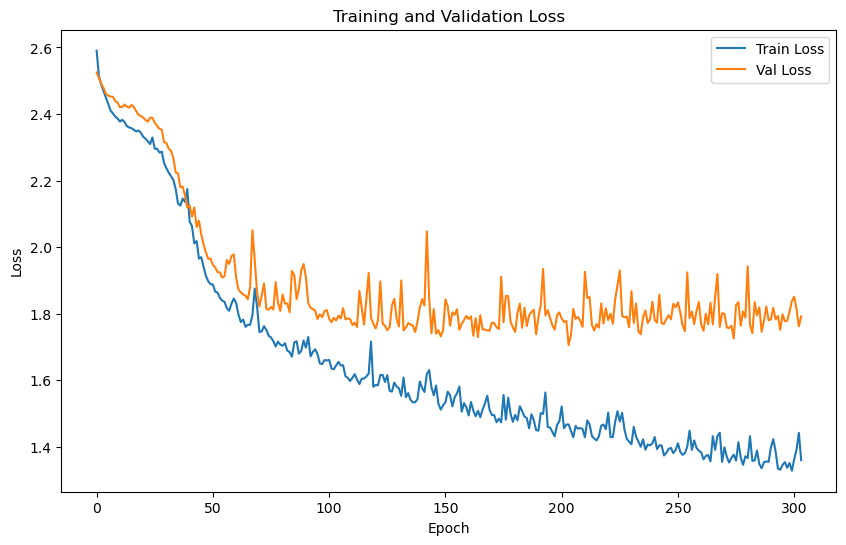

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.8729 | Test Accuracy: 38.98%


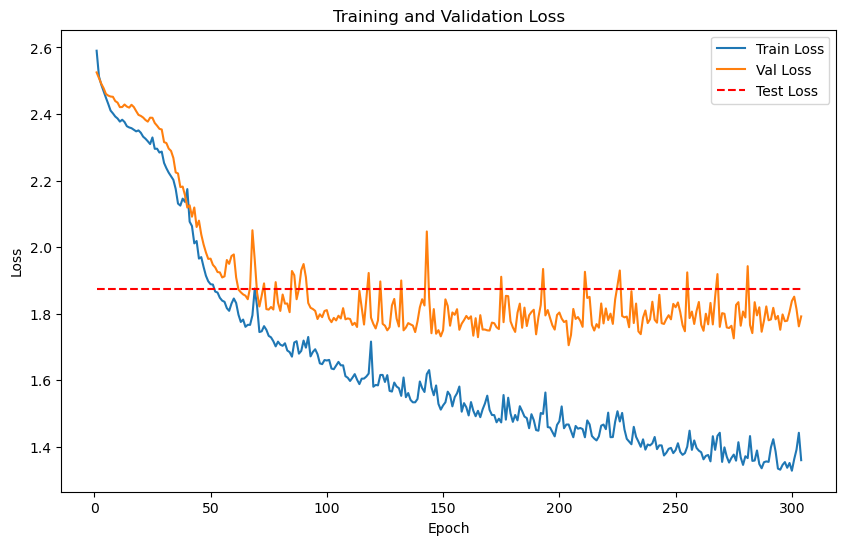

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/2], Train Loss: 8.0945
    Batch [2/2], Train Loss: 7.7272
Epoch [1/2000], Avg Train Loss: 7.9109
Epoch [1/2000], Avg Val Loss: 5.4227
Validation loss improved from inf to 5.4227. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 7.8198


    Batch [2/2], Train Loss: 7.5837
Epoch [2/2000], Avg Train Loss: 7.7018
Epoch [2/2000], Avg Val Loss: 5.3721
Validation loss improved from 5.4227 to 5.3721. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 7.5485
    Batch [2/2], Train Loss: 7.6681
Epoch [3/2000], Avg Train Loss: 7.6083
Epoch [3/2000], Avg Val Loss: 5.3224
Validation loss improved from 5.3721 to 5.3224. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 7.6519
    Batch [2/2], Train Loss: 7.3726
Epoch [4/2000], Avg Train Loss: 7.5122
Epoch [4/2000], Avg Val Loss: 5.2724
Validation loss improved from 5.3224 to 5.2724. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 7.4826
    Batch [2/2], Train Loss: 7.2828
Epoch [5/2000], Avg Train Loss: 7.3827
Epoch [5/2000], Avg Val Loss: 5.2216
Validation loss improved from 5.2724 to 5.2216. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 7.4193
    Batch [2/2], Train L

Epoch [9/2000], Avg Val Loss: 5.0156
Validation loss improved from 5.0664 to 5.0156. Saving model...

LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 7.0716
    Batch [2/2], Train Loss: 6.8994
Epoch [10/2000], Avg Train Loss: 6.9855
Epoch [10/2000], Avg Val Loss: 4.9657
Validation loss improved from 5.0156 to 4.9657. Saving model...

LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 6.9704
    Batch [2/2], Train Loss: 6.9494
Epoch [11/2000], Avg Train Loss: 6.9599
Epoch [11/2000], Avg Val Loss: 4.9168
Validation loss improved from 4.9657 to 4.9168. Saving model...

LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 6.8792
    Batch [2/2], Train Loss: 6.9083
Epoch [12/2000], Avg Train Loss: 6.8938
Epoch [12/2000], Avg Val Loss: 4.8680
Validation loss improved from 4.9168 to 4.8680. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 6.8217
    Batch [2/2], Train Loss: 6.8567
Epoch [13/2000], Avg Train Loss: 6.8392
Epoch [13/2000], Avg Val Loss: 4.8195
Validation loss improved from 4.8680 to 4.8195. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 6.8152
Epoch [14/2000], Avg Train Loss: 6.7915
Epoch [14/2000], Avg Val Loss: 4.7718
Validation loss improved from 4.8195 to 4.7718. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.5699
    Batch [2/2], Train Loss: 6.7904
Epoch [15/2000], Avg Train Loss: 6.6802
Epoch [15/2000], Avg Val Loss: 4.7256
Validation loss improved from 4.7718 to 4.7256. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.6783
    Batch [2/2], Train Loss: 6.7376
Epoch [16/2000], Avg Train Loss: 6.7079
Epoch [16/2000], Avg Val Loss: 4.6803
Validation loss improved from 4.7256 to 4.6803. Saving model...

LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 6.6446
    Batch [2/2], Train Loss: 6.5766
Epoch [17/2000], Avg Train Loss: 6.6106
Epoch [17/2000], Avg Val Loss: 4.6357
Validation loss improved from 4.6803 to 4.6357. Saving model...

LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 6.4671
    Batch [2

    Batch [1/2], Train Loss: 6.1732
    Batch [2/2], Train Loss: 6.2434
Epoch [25/2000], Avg Train Loss: 6.2083
Epoch [25/2000], Avg Val Loss: 4.3232
Validation loss improved from 4.3561 to 4.3232. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 6.2473
    Batch [2/2], Train Loss: 6.1364
Epoch [26/2000], Avg Train Loss: 6.1918
Epoch [26/2000], Avg Val Loss: 4.2919
Validation loss improved from 4.3232 to 4.2919. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 6.1970
    Batch [2/2], Train Loss: 6.1802
Epoch [27/2000], Avg Train Loss: 6.1886
Epoch [27/2000], Avg Val Loss: 4.2616
Validation loss improved from 4.2919 to 4.2616. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 6.1036
    Batch [2/2], Train Loss: 6.1051
Epoch [28/2000], Avg Train Loss: 6.1044
Epoch [28/2000], Avg Val Loss: 4.2328
Validation loss improved from 4.2616 to 4.2328. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 6.0704
Epoch [30/2000], Avg Train Loss: 6.0764
Epoch [30/2000], Avg Val Loss: 4.1803
Validation loss improved from 4.2060 to 4.1803. Saving model...

LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 5.9921
    Batch [2/2], Train Loss: 5.9693
Epoch [31/2000], Avg Train Loss: 5.9807
Epoch [31/2000], Avg Val Loss: 4.1553
Validation loss improved from 4.1803 to 4.1553. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.9756
    Batch [2/2], Train Loss: 5.9876
Epoch [32/2000], Avg Train Loss: 5.9816
Epoch [32/2000], Avg Val Loss: 4.1321
Validation loss improved from 4.1553 to 4.1321. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.9560
    Batch [2/2], Train Loss: 5.9770
Epoch [33/2000], Avg Train Loss: 5.9665
Epoch [33/2000], Avg Val Loss: 4.1102
Validation loss improved from 4.1321 to 4.1102. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.8819
    Batch [2

    Batch [2/2], Train Loss: 5.8780
Epoch [35/2000], Avg Train Loss: 5.8997
Epoch [35/2000], Avg Val Loss: 4.0708
Validation loss improved from 4.0898 to 4.0708. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.8694
    Batch [2/2], Train Loss: 5.8399
Epoch [36/2000], Avg Train Loss: 5.8546
Epoch [36/2000], Avg Val Loss: 4.0528
Validation loss improved from 4.0708 to 4.0528. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.8673
    Batch [2/2], Train Loss: 5.8392
Epoch [37/2000], Avg Train Loss: 5.8533
Epoch [37/2000], Avg Val Loss: 4.0356
Validation loss improved from 4.0528 to 4.0356. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 5.8411
    Batch [2/2], Train Loss: 5.7608
Epoch [38/2000], Avg Train Loss: 5.8009
Epoch [38/2000], Avg Val Loss: 4.0194
Validation loss improved from 4.0356 to 4.0194. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 5.8690
    Batch [2

    Batch [1/2], Train Loss: 5.6141
    Batch [2/2], Train Loss: 5.6464
Epoch [48/2000], Avg Train Loss: 5.6303
Epoch [48/2000], Avg Val Loss: 3.8969
Validation loss improved from 3.9067 to 3.8969. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 5.6322
    Batch [2/2], Train Loss: 5.5899
Epoch [49/2000], Avg Train Loss: 5.6110
Epoch [49/2000], Avg Val Loss: 3.8874
Validation loss improved from 3.8969 to 3.8874. Saving model...

LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 5.6319
    Batch [2/2], Train Loss: 5.6290
Epoch [50/2000], Avg Train Loss: 5.6304
Epoch [50/2000], Avg Val Loss: 3.8782
Validation loss improved from 3.8874 to 3.8782. Saving model...

LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 5.5853
    Batch [2/2], Train Loss: 5.6099
Epoch [51/2000], Avg Train Loss: 5.5976
Epoch [51/2000], Avg Val Loss: 3.8693
Validation loss improved from 3.8782 to 3.8693. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.5846
Epoch [52/2000], Avg Train Loss: 5.5971
Epoch [52/2000], Avg Val Loss: 3.8608
Validation loss improved from 3.8693 to 3.8608. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 5.6235
    Batch [2/2], Train Loss: 5.5627
Epoch [53/2000], Avg Train Loss: 5.5931
Epoch [53/2000], Avg Val Loss: 3.8526
Validation loss improved from 3.8608 to 3.8526. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 5.5439
    Batch [2/2], Train Loss: 5.5369
Epoch [54/2000], Avg Train Loss: 5.5404
Epoch [54/2000], Avg Val Loss: 3.8447
Validation loss improved from 3.8526 to 3.8447. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 5.5797
    Batch [2/2], Train Loss: 5.5672
Epoch [55/2000], Avg Train Loss: 5.5734
Epoch [55/2000], Avg Val Loss: 3.8371
Validation loss improved from 3.8447 to 3.8371. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 5.5852
    Batch [2

    Batch [2/2], Train Loss: 5.5023
Epoch [57/2000], Avg Train Loss: 5.5120
Epoch [57/2000], Avg Val Loss: 3.8231
Validation loss improved from 3.8300 to 3.8231. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 5.5876
    Batch [2/2], Train Loss: 5.4847
Epoch [58/2000], Avg Train Loss: 5.5361
Epoch [58/2000], Avg Val Loss: 3.8165
Validation loss improved from 3.8231 to 3.8165. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 5.5020
    Batch [2/2], Train Loss: 5.5299
Epoch [59/2000], Avg Train Loss: 5.5159
Epoch [59/2000], Avg Val Loss: 3.8099
Validation loss improved from 3.8165 to 3.8099. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 5.5274
    Batch [2/2], Train Loss: 5.4501
Epoch [60/2000], Avg Train Loss: 5.4887
Epoch [60/2000], Avg Val Loss: 3.8036
Validation loss improved from 3.8099 to 3.8036. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 5.4888
    Batch [2

    Batch [2/2], Train Loss: 5.4536
Epoch [68/2000], Avg Train Loss: 5.4500
Epoch [68/2000], Avg Val Loss: 3.7610
Validation loss improved from 3.7655 to 3.7610. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 5.4287
    Batch [2/2], Train Loss: 5.4496
Epoch [69/2000], Avg Train Loss: 5.4392
Epoch [69/2000], Avg Val Loss: 3.7567
Validation loss improved from 3.7610 to 3.7567. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 5.4548
    Batch [2/2], Train Loss: 5.4254
Epoch [70/2000], Avg Train Loss: 5.4401
Epoch [70/2000], Avg Val Loss: 3.7525
Validation loss improved from 3.7567 to 3.7525. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 5.4485
    Batch [2/2], Train Loss: 5.3971
Epoch [71/2000], Avg Train Loss: 5.4228
Epoch [71/2000], Avg Val Loss: 3.7486
Validation loss improved from 3.7525 to 3.7486. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 5.3966
    Batch [2

    Batch [1/2], Train Loss: 5.4434
    Batch [2/2], Train Loss: 5.3755
Epoch [74/2000], Avg Train Loss: 5.4094
Epoch [74/2000], Avg Val Loss: 3.7374
Validation loss improved from 3.7409 to 3.7374. Saving model...

LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 5.3961
    Batch [2/2], Train Loss: 5.3974
Epoch [75/2000], Avg Train Loss: 5.3968
Epoch [75/2000], Avg Val Loss: 3.7340
Validation loss improved from 3.7374 to 3.7340. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 5.3823
    Batch [2/2], Train Loss: 5.3880
Epoch [76/2000], Avg Train Loss: 5.3852
Epoch [76/2000], Avg Val Loss: 3.7307
Validation loss improved from 3.7340 to 3.7307. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 5.3935
    Batch [2/2], Train Loss: 5.3660
Epoch [77/2000], Avg Train Loss: 5.3797
Epoch [77/2000], Avg Val Loss: 3.7274
Validation loss improved from 3.7307 to 3.7274. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.4101
Epoch [78/2000], Avg Train Loss: 5.3785
Epoch [78/2000], Avg Val Loss: 3.7243
Validation loss improved from 3.7274 to 3.7243. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 5.3822
    Batch [2/2], Train Loss: 5.3704
Epoch [79/2000], Avg Train Loss: 5.3763
Epoch [79/2000], Avg Val Loss: 3.7210
Validation loss improved from 3.7243 to 3.7210. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 5.3232
    Batch [2/2], Train Loss: 5.3645
Epoch [80/2000], Avg Train Loss: 5.3439
Epoch [80/2000], Avg Val Loss: 3.7176
Validation loss improved from 3.7210 to 3.7176. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 5.3447
    Batch [2/2], Train Loss: 5.3267
Epoch [81/2000], Avg Train Loss: 5.3357
Epoch [81/2000], Avg Val Loss: 3.7144
Validation loss improved from 3.7176 to 3.7144. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 5.3274
    Batch [2

Epoch [89/2000], Avg Val Loss: 3.6944
Validation loss improved from 3.6965 to 3.6944. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 5.3136
    Batch [2/2], Train Loss: 5.3327
Epoch [90/2000], Avg Train Loss: 5.3231
Epoch [90/2000], Avg Val Loss: 3.6925
Validation loss improved from 3.6944 to 3.6925. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 5.2750
    Batch [2/2], Train Loss: 5.3536
Epoch [91/2000], Avg Train Loss: 5.3143
Epoch [91/2000], Avg Val Loss: 3.6906
Validation loss improved from 3.6925 to 3.6906. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 5.3417
    Batch [2/2], Train Loss: 5.2722
Epoch [92/2000], Avg Train Loss: 5.3069
Epoch [92/2000], Avg Val Loss: 3.6887
Validation loss improved from 3.6906 to 3.6887. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 5.2476
    Batch [2/2], Train Loss: 5.2986
Epoch [93/2000], Avg Train Loss: 5.2731
Epoch [93/20

Epoch [95/2000], Avg Val Loss: 3.6823
Validation loss improved from 3.6843 to 3.6823. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 5.3243
    Batch [2/2], Train Loss: 5.3233
Epoch [96/2000], Avg Train Loss: 5.3238
Epoch [96/2000], Avg Val Loss: 3.6805
Validation loss improved from 3.6823 to 3.6805. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 5.3067
    Batch [2/2], Train Loss: 5.2387
Epoch [97/2000], Avg Train Loss: 5.2727
Epoch [97/2000], Avg Val Loss: 3.6788
Validation loss improved from 3.6805 to 3.6788. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 5.2869
    Batch [2/2], Train Loss: 5.3139
Epoch [98/2000], Avg Train Loss: 5.3004
Epoch [98/2000], Avg Val Loss: 3.6773
Validation loss improved from 3.6788 to 3.6773. Saving model...

LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 5.2958
    Batch [2/2], Train Loss: 5.2924
Epoch [99/2000], Avg Train Loss: 5.2941
Epoch [99/20

    Batch [2/2], Train Loss: 5.3232
Epoch [100/2000], Avg Train Loss: 5.3083
Epoch [100/2000], Avg Val Loss: 3.6748
Validation loss improved from 3.6761 to 3.6748. Saving model...

LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 5.2601
    Batch [2/2], Train Loss: 5.3121
Epoch [101/2000], Avg Train Loss: 5.2861
Epoch [101/2000], Avg Val Loss: 3.6734
Validation loss improved from 3.6748 to 3.6734. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 5.3107
    Batch [2/2], Train Loss: 5.2913
Epoch [102/2000], Avg Train Loss: 5.3010
Epoch [102/2000], Avg Val Loss: 3.6721
Validation loss improved from 3.6734 to 3.6721. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 5.2532
    Batch [2/2], Train Loss: 5.3269
Epoch [103/2000], Avg Train Loss: 5.2900
Epoch [103/2000], Avg Val Loss: 3.6707
Validation loss improved from 3.6721 to 3.6707. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 5.2715


Epoch [111/2000], Avg Val Loss: 3.6588
Validation loss improved from 3.6603 to 3.6588. Saving model...

LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 5.3081
    Batch [2/2], Train Loss: 5.2430
Epoch [112/2000], Avg Train Loss: 5.2756
Epoch [112/2000], Avg Val Loss: 3.6572
Validation loss improved from 3.6588 to 3.6572. Saving model...

LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 5.2623
    Batch [2/2], Train Loss: 5.2810
Epoch [113/2000], Avg Train Loss: 5.2717
Epoch [113/2000], Avg Val Loss: 3.6559
Validation loss improved from 3.6572 to 3.6559. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 5.2763
    Batch [2/2], Train Loss: 5.2301
Epoch [114/2000], Avg Train Loss: 5.2532
Epoch [114/2000], Avg Val Loss: 3.6546
Validation loss improved from 3.6559 to 3.6546. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 5.2690
    Batch [2/2], Train Loss: 5.2423
Epoch [115/2000], Avg Train Loss: 5.2556


    Batch [1/2], Train Loss: 5.2600
    Batch [2/2], Train Loss: 5.2782
Epoch [118/2000], Avg Train Loss: 5.2691
Epoch [118/2000], Avg Val Loss: 3.6514
Validation loss improved from 3.6521 to 3.6514. Saving model...

LOG: Epoch [119/2000] - Training
    Batch [1/2], Train Loss: 5.2721
    Batch [2/2], Train Loss: 5.2394
Epoch [119/2000], Avg Train Loss: 5.2557
Epoch [119/2000], Avg Val Loss: 3.6509
Validation loss improved from 3.6514 to 3.6509. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 5.2618
    Batch [2/2], Train Loss: 5.2436
Epoch [120/2000], Avg Train Loss: 5.2527
Epoch [120/2000], Avg Val Loss: 3.6504
Validation loss improved from 3.6509 to 3.6504. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 5.2609
    Batch [2/2], Train Loss: 5.2325
Epoch [121/2000], Avg Train Loss: 5.2467
Epoch [121/2000], Avg Val Loss: 3.6500
Validation loss improved from 3.6504 to 3.6500. Saving model...

LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 5.2181
    Batch [2/2], Train Loss: 5.2395
Epoch [122/2000], Avg Train Loss: 5.2288
Epoch [122/2000], Avg Val Loss: 3.6493
Validation loss improved from 3.6500 to 3.6493. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 5.2973
    Batch [2/2], Train Loss: 5.2209
Epoch [123/2000], Avg Train Loss: 5.2591
Epoch [123/2000], Avg Val Loss: 3.6483
Validation loss improved from 3.6493 to 3.6483. Saving model...

LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 5.2681
    Batch [2/2], Train Loss: 5.2610
Epoch [124/2000], Avg Train Loss: 5.2646
Epoch [124/2000], Avg Val Loss: 3.6473
Validation loss improved from 3.6483 to 3.6473. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 5.2215
    Batch [2/2], Train Loss: 5.1900
Epoch [125/2000], Avg Train Loss: 5.2058
Epoch [125/2000], Avg Val Loss: 3.6461
Validation loss improved from 3.6473 to 3.6461. Saving model...

LOG: Epoch [126/2000] - Training


Epoch [132/2000], Avg Val Loss: 3.6384
Validation loss improved from 3.6394 to 3.6384. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 5.2166
    Batch [2/2], Train Loss: 5.1935
Epoch [133/2000], Avg Train Loss: 5.2051
Epoch [133/2000], Avg Val Loss: 3.6374
Validation loss improved from 3.6384 to 3.6374. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 5.2082
    Batch [2/2], Train Loss: 5.1789
Epoch [134/2000], Avg Train Loss: 5.1936
Epoch [134/2000], Avg Val Loss: 3.6362
Validation loss improved from 3.6374 to 3.6362. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 5.1995
    Batch [2/2], Train Loss: 5.1962
Epoch [135/2000], Avg Train Loss: 5.1979
Epoch [135/2000], Avg Val Loss: 3.6350
Validation loss improved from 3.6362 to 3.6350. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 5.1580
    Batch [2/2], Train Loss: 5.1948
Epoch [136/2000], Avg Train Loss: 5.1764


    Batch [2/2], Train Loss: 5.1988
Epoch [140/2000], Avg Train Loss: 5.1966
Epoch [140/2000], Avg Val Loss: 3.6296
Validation loss improved from 3.6307 to 3.6296. Saving model...

LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 5.2092
    Batch [2/2], Train Loss: 5.2398
Epoch [141/2000], Avg Train Loss: 5.2245
Epoch [141/2000], Avg Val Loss: 3.6286
Validation loss improved from 3.6296 to 3.6286. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 5.2299
    Batch [2/2], Train Loss: 5.1911
Epoch [142/2000], Avg Train Loss: 5.2105
Epoch [142/2000], Avg Val Loss: 3.6274
Validation loss improved from 3.6286 to 3.6274. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 5.2066
    Batch [2/2], Train Loss: 5.1819
Epoch [143/2000], Avg Train Loss: 5.1942
Epoch [143/2000], Avg Val Loss: 3.6261
Validation loss improved from 3.6274 to 3.6261. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 5.1466


    Batch [1/2], Train Loss: 5.1525
    Batch [2/2], Train Loss: 5.1630
Epoch [155/2000], Avg Train Loss: 5.1578
Epoch [155/2000], Avg Val Loss: 3.6179
Validation loss improved from 3.6186 to 3.6179. Saving model...

LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 5.1711
    Batch [2/2], Train Loss: 5.1993
Epoch [156/2000], Avg Train Loss: 5.1852
Epoch [156/2000], Avg Val Loss: 3.6174
Validation loss improved from 3.6179 to 3.6174. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 5.1536
    Batch [2/2], Train Loss: 5.1588
Epoch [157/2000], Avg Train Loss: 5.1562
Epoch [157/2000], Avg Val Loss: 3.6169
Validation loss improved from 3.6174 to 3.6169. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 5.1924
    Batch [2/2], Train Loss: 5.2016
Epoch [158/2000], Avg Train Loss: 5.1970
Epoch [158/2000], Avg Val Loss: 3.6165
Validation loss improved from 3.6169 to 3.6165. Saving model...

LOG: Epoch [159/2000] - Training


    Batch [2/2], Train Loss: 5.1360
Epoch [162/2000], Avg Train Loss: 5.1403
Epoch [162/2000], Avg Val Loss: 3.6141
Validation loss improved from 3.6150 to 3.6141. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 5.1145
    Batch [2/2], Train Loss: 5.1500
Epoch [163/2000], Avg Train Loss: 5.1322
Epoch [163/2000], Avg Val Loss: 3.6133
Validation loss improved from 3.6141 to 3.6133. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 5.1549
    Batch [2/2], Train Loss: 5.1382
Epoch [164/2000], Avg Train Loss: 5.1466
Epoch [164/2000], Avg Val Loss: 3.6125
Validation loss improved from 3.6133 to 3.6125. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 5.1938
    Batch [2/2], Train Loss: 5.1743
Epoch [165/2000], Avg Train Loss: 5.1840
Epoch [165/2000], Avg Val Loss: 3.6120
Validation loss improved from 3.6125 to 3.6120. Saving model...

LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 5.1864


    Batch [2/2], Train Loss: 5.1521
Epoch [175/2000], Avg Train Loss: 5.1510
Epoch [175/2000], Avg Val Loss: 3.6073
Validation loss improved from 3.6082 to 3.6073. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 5.1062
    Batch [2/2], Train Loss: 5.1403
Epoch [176/2000], Avg Train Loss: 5.1232
Epoch [176/2000], Avg Val Loss: 3.6062
Validation loss improved from 3.6073 to 3.6062. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 5.1473
    Batch [2/2], Train Loss: 5.1113
Epoch [177/2000], Avg Train Loss: 5.1293
Epoch [177/2000], Avg Val Loss: 3.6055
Validation loss improved from 3.6062 to 3.6055. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 5.1210
    Batch [2/2], Train Loss: 5.1799
Epoch [178/2000], Avg Train Loss: 5.1504
Epoch [178/2000], Avg Val Loss: 3.6051
Validation loss improved from 3.6055 to 3.6051. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 5.1009


    Batch [2/2], Train Loss: 5.1254
Epoch [182/2000], Avg Train Loss: 5.1361
Epoch [182/2000], Avg Val Loss: 3.6028
Validation loss improved from 3.6034 to 3.6028. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 5.1965
    Batch [2/2], Train Loss: 5.0952
Epoch [183/2000], Avg Train Loss: 5.1459
Epoch [183/2000], Avg Val Loss: 3.6023
Validation loss improved from 3.6028 to 3.6023. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 5.1339
    Batch [2/2], Train Loss: 5.1266
Epoch [184/2000], Avg Train Loss: 5.1302
Epoch [184/2000], Avg Val Loss: 3.6018
Validation loss improved from 3.6023 to 3.6018. Saving model...

LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 5.1581
    Batch [2/2], Train Loss: 5.1287
Epoch [185/2000], Avg Train Loss: 5.1434
Epoch [185/2000], Avg Val Loss: 3.6010
Validation loss improved from 3.6018 to 3.6010. Saving model...

LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 5.1678


Epoch [187/2000], Avg Val Loss: 3.5994
Validation loss improved from 3.6002 to 3.5994. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 5.1350
    Batch [2/2], Train Loss: 5.1259
Epoch [188/2000], Avg Train Loss: 5.1305
Epoch [188/2000], Avg Val Loss: 3.5987
Validation loss improved from 3.5994 to 3.5987. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 5.1242
    Batch [2/2], Train Loss: 5.0987
Epoch [189/2000], Avg Train Loss: 5.1115
Epoch [189/2000], Avg Val Loss: 3.5980
Validation loss improved from 3.5987 to 3.5980. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 5.1318
    Batch [2/2], Train Loss: 5.1139
Epoch [190/2000], Avg Train Loss: 5.1228
Epoch [190/2000], Avg Val Loss: 3.5973
Validation loss improved from 3.5980 to 3.5973. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 5.1528
    Batch [2/2], Train Loss: 5.1182
Epoch [191/2000], Avg Train Loss: 5.1355


    Batch [2/2], Train Loss: 5.1007
Epoch [203/2000], Avg Train Loss: 5.1090
Epoch [203/2000], Avg Val Loss: 3.5953
Validation loss did not improve. Patience: 7/100

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 5.1136
    Batch [2/2], Train Loss: 5.0966
Epoch [204/2000], Avg Train Loss: 5.1051
Epoch [204/2000], Avg Val Loss: 3.5951
Validation loss did not improve. Patience: 8/100

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 5.1056
    Batch [2/2], Train Loss: 5.1019
Epoch [205/2000], Avg Train Loss: 5.1037
Epoch [205/2000], Avg Val Loss: 3.5947
Validation loss improved from 3.5949 to 3.5947. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 5.0942
    Batch [2/2], Train Loss: 5.1226
Epoch [206/2000], Avg Train Loss: 5.1084
Epoch [206/2000], Avg Val Loss: 3.5943
Validation loss improved from 3.5947 to 3.5943. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 5.0766
    Batch [2/2], Train Loss: 5

    Batch [1/2], Train Loss: 5.1339
    Batch [2/2], Train Loss: 5.0995
Epoch [209/2000], Avg Train Loss: 5.1167
Epoch [209/2000], Avg Val Loss: 3.5921
Validation loss improved from 3.5932 to 3.5921. Saving model...

LOG: Epoch [210/2000] - Training
    Batch [1/2], Train Loss: 5.1361
    Batch [2/2], Train Loss: 5.1535
Epoch [210/2000], Avg Train Loss: 5.1448
Epoch [210/2000], Avg Val Loss: 3.5910
Validation loss improved from 3.5921 to 3.5910. Saving model...

LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 5.1212
    Batch [2/2], Train Loss: 5.0955
Epoch [211/2000], Avg Train Loss: 5.1083
Epoch [211/2000], Avg Val Loss: 3.5902
Validation loss improved from 3.5910 to 3.5902. Saving model...

LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 5.1070
    Batch [2/2], Train Loss: 5.0637
Epoch [212/2000], Avg Train Loss: 5.0854
Epoch [212/2000], Avg Val Loss: 3.5897
Validation loss improved from 3.5902 to 3.5897. Saving model...

LOG: Epoch [213/2000] - Training


    Batch [2/2], Train Loss: 5.0987
Epoch [224/2000], Avg Train Loss: 5.0943
Epoch [224/2000], Avg Val Loss: 3.5863
Validation loss improved from 3.5867 to 3.5863. Saving model...

LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 5.0912
    Batch [2/2], Train Loss: 5.0938
Epoch [225/2000], Avg Train Loss: 5.0925
Epoch [225/2000], Avg Val Loss: 3.5857
Validation loss improved from 3.5863 to 3.5857. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 5.1338
    Batch [2/2], Train Loss: 5.0928
Epoch [226/2000], Avg Train Loss: 5.1133
Epoch [226/2000], Avg Val Loss: 3.5853
Validation loss improved from 3.5857 to 3.5853. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 5.0610
    Batch [2/2], Train Loss: 5.0799
Epoch [227/2000], Avg Train Loss: 5.0705
Epoch [227/2000], Avg Val Loss: 3.5847
Validation loss improved from 3.5853 to 3.5847. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 5.0624


Epoch [229/2000], Avg Val Loss: 3.5836
Validation loss improved from 3.5842 to 3.5836. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 5.1038
    Batch [2/2], Train Loss: 5.0668
Epoch [230/2000], Avg Train Loss: 5.0853
Epoch [230/2000], Avg Val Loss: 3.5829
Validation loss improved from 3.5836 to 3.5829. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 5.0606
    Batch [2/2], Train Loss: 5.1230
Epoch [231/2000], Avg Train Loss: 5.0918
Epoch [231/2000], Avg Val Loss: 3.5825
Validation loss improved from 3.5829 to 3.5825. Saving model...

LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 5.0624
    Batch [2/2], Train Loss: 5.0876
Epoch [232/2000], Avg Train Loss: 5.0750
Epoch [232/2000], Avg Val Loss: 3.5823
Validation loss improved from 3.5825 to 3.5823. Saving model...

LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 5.0360
    Batch [2/2], Train Loss: 5.0787
Epoch [233/2000], Avg Train Loss: 5.0574


    Batch [1/2], Train Loss: 5.0733
    Batch [2/2], Train Loss: 5.0706
Epoch [247/2000], Avg Train Loss: 5.0719
Epoch [247/2000], Avg Val Loss: 3.5703
Validation loss improved from 3.5712 to 3.5703. Saving model...

LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 5.0863
    Batch [2/2], Train Loss: 5.0875
Epoch [248/2000], Avg Train Loss: 5.0869
Epoch [248/2000], Avg Val Loss: 3.5695
Validation loss improved from 3.5703 to 3.5695. Saving model...

LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 5.0765
    Batch [2/2], Train Loss: 5.0423
Epoch [249/2000], Avg Train Loss: 5.0594
Epoch [249/2000], Avg Val Loss: 3.5690
Validation loss improved from 3.5695 to 3.5690. Saving model...

LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 5.0605
    Batch [2/2], Train Loss: 5.1124
Epoch [250/2000], Avg Train Loss: 5.0864
Epoch [250/2000], Avg Val Loss: 3.5684
Validation loss improved from 3.5690 to 3.5684. Saving model...

LOG: Epoch [251/2000] - Training


    Batch [2/2], Train Loss: 5.0383
Epoch [252/2000], Avg Train Loss: 5.0695
Epoch [252/2000], Avg Val Loss: 3.5678
Validation loss improved from 3.5681 to 3.5678. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 5.0394
    Batch [2/2], Train Loss: 5.0075
Epoch [253/2000], Avg Train Loss: 5.0234
Epoch [253/2000], Avg Val Loss: 3.5675
Validation loss improved from 3.5678 to 3.5675. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 5.0207
    Batch [2/2], Train Loss: 5.0843
Epoch [254/2000], Avg Train Loss: 5.0525
Epoch [254/2000], Avg Val Loss: 3.5672
Validation loss improved from 3.5675 to 3.5672. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 5.0370
    Batch [2/2], Train Loss: 5.0280
Epoch [255/2000], Avg Train Loss: 5.0325
Epoch [255/2000], Avg Val Loss: 3.5669
Validation loss improved from 3.5672 to 3.5669. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 5.0292


    Batch [1/2], Train Loss: 5.0434
    Batch [2/2], Train Loss: 5.0171
Epoch [270/2000], Avg Train Loss: 5.0303
Epoch [270/2000], Avg Val Loss: 3.5564
Validation loss improved from 3.5574 to 3.5564. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 5.0639
    Batch [2/2], Train Loss: 4.9450
Epoch [271/2000], Avg Train Loss: 5.0044
Epoch [271/2000], Avg Val Loss: 3.5554
Validation loss improved from 3.5564 to 3.5554. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 4.9876
    Batch [2/2], Train Loss: 5.0601
Epoch [272/2000], Avg Train Loss: 5.0239
Epoch [272/2000], Avg Val Loss: 3.5545
Validation loss improved from 3.5554 to 3.5545. Saving model...

LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 5.0090
    Batch [2/2], Train Loss: 5.0583
Epoch [273/2000], Avg Train Loss: 5.0337
Epoch [273/2000], Avg Val Loss: 3.5535
Validation loss improved from 3.5545 to 3.5535. Saving model...

LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 4.9966
    Batch [2/2], Train Loss: 4.9874
Epoch [275/2000], Avg Train Loss: 4.9920
Epoch [275/2000], Avg Val Loss: 3.5521
Validation loss improved from 3.5527 to 3.5521. Saving model...

LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 5.0556
    Batch [2/2], Train Loss: 4.9932
Epoch [276/2000], Avg Train Loss: 5.0244
Epoch [276/2000], Avg Val Loss: 3.5515
Validation loss improved from 3.5521 to 3.5515. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 5.0146
    Batch [2/2], Train Loss: 4.9960
Epoch [277/2000], Avg Train Loss: 5.0053
Epoch [277/2000], Avg Val Loss: 3.5503
Validation loss improved from 3.5515 to 3.5503. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 5.0381
    Batch [2/2], Train Loss: 5.0798
Epoch [278/2000], Avg Train Loss: 5.0590
Epoch [278/2000], Avg Val Loss: 3.5489
Validation loss improved from 3.5503 to 3.5489. Saving model...

LOG: Epoch [279/2000] - Training


    Batch [2/2], Train Loss: 5.0697
Epoch [292/2000], Avg Train Loss: 5.0268
Epoch [292/2000], Avg Val Loss: 3.5419
Validation loss did not improve. Patience: 4/100

LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 4.9978
    Batch [2/2], Train Loss: 5.0067
Epoch [293/2000], Avg Train Loss: 5.0022
Epoch [293/2000], Avg Val Loss: 3.5421
Validation loss did not improve. Patience: 5/100

LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 5.0837
    Batch [2/2], Train Loss: 4.9580
Epoch [294/2000], Avg Train Loss: 5.0209
Epoch [294/2000], Avg Val Loss: 3.5423
Validation loss did not improve. Patience: 6/100

LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 4.9833
    Batch [2/2], Train Loss: 5.0415
Epoch [295/2000], Avg Train Loss: 5.0124
Epoch [295/2000], Avg Val Loss: 3.5425
Validation loss did not improve. Patience: 7/100

LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 4.9672
    Batch [2/2], Train Loss: 5.0233
Epoch [296/2000], Avg Tr

    Batch [2/2], Train Loss: 4.9915
Epoch [298/2000], Avg Train Loss: 4.9962
Epoch [298/2000], Avg Val Loss: 3.5422
Validation loss did not improve. Patience: 10/100

LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 5.0237
    Batch [2/2], Train Loss: 4.9828
Epoch [299/2000], Avg Train Loss: 5.0033
Epoch [299/2000], Avg Val Loss: 3.5421
Validation loss did not improve. Patience: 11/100

LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 5.0385
    Batch [2/2], Train Loss: 5.0200
Epoch [300/2000], Avg Train Loss: 5.0292
Epoch [300/2000], Avg Val Loss: 3.5418
Validation loss did not improve. Patience: 12/100

LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 4.9598
    Batch [2/2], Train Loss: 4.9977
Epoch [301/2000], Avg Train Loss: 4.9787
Epoch [301/2000], Avg Val Loss: 3.5412
Validation loss did not improve. Patience: 13/100

LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 5.0209
    Batch [2/2], Train Loss: 5.0233
Epoch [302/2000], Av

    Batch [1/2], Train Loss: 4.9914
    Batch [2/2], Train Loss: 4.9872
Epoch [316/2000], Avg Train Loss: 4.9893
Epoch [316/2000], Avg Val Loss: 3.5273
Validation loss improved from 3.5278 to 3.5273. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 4.9768
    Batch [2/2], Train Loss: 4.9641
Epoch [317/2000], Avg Train Loss: 4.9704
Epoch [317/2000], Avg Val Loss: 3.5269
Validation loss improved from 3.5273 to 3.5269. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 4.9057
    Batch [2/2], Train Loss: 4.9966
Epoch [318/2000], Avg Train Loss: 4.9511
Epoch [318/2000], Avg Val Loss: 3.5259
Validation loss improved from 3.5269 to 3.5259. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 4.9580
    Batch [2/2], Train Loss: 4.9856
Epoch [319/2000], Avg Train Loss: 4.9718
Epoch [319/2000], Avg Val Loss: 3.5244
Validation loss improved from 3.5259 to 3.5244. Saving model...

LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 4.9798
    Batch [2/2], Train Loss: 4.9077
Epoch [322/2000], Avg Train Loss: 4.9437
Epoch [322/2000], Avg Val Loss: 3.5225
Validation loss improved from 3.5229 to 3.5225. Saving model...

LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 4.9747
    Batch [2/2], Train Loss: 4.9811
Epoch [323/2000], Avg Train Loss: 4.9779
Epoch [323/2000], Avg Val Loss: 3.5218
Validation loss improved from 3.5225 to 3.5218. Saving model...

LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 4.9255
    Batch [2/2], Train Loss: 4.9453
Epoch [324/2000], Avg Train Loss: 4.9354
Epoch [324/2000], Avg Val Loss: 3.5210
Validation loss improved from 3.5218 to 3.5210. Saving model...

LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 4.9483
    Batch [2/2], Train Loss: 5.0131
Epoch [325/2000], Avg Train Loss: 4.9807
Epoch [325/2000], Avg Val Loss: 3.5202
Validation loss improved from 3.5210 to 3.5202. Saving model...

LOG: Epoch [326/2000] - Training


    Batch [2/2], Train Loss: 4.9411
Epoch [337/2000], Avg Train Loss: 4.9372
Epoch [337/2000], Avg Val Loss: 3.5135
Validation loss did not improve. Patience: 2/100

LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 4.9832
    Batch [2/2], Train Loss: 4.8988
Epoch [338/2000], Avg Train Loss: 4.9410
Epoch [338/2000], Avg Val Loss: 3.5131
Validation loss improved from 3.5135 to 3.5131. Saving model...

LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 4.9634
    Batch [2/2], Train Loss: 4.9490
Epoch [339/2000], Avg Train Loss: 4.9562
Epoch [339/2000], Avg Val Loss: 3.5128
Validation loss improved from 3.5131 to 3.5128. Saving model...

LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 4.9171
    Batch [2/2], Train Loss: 4.9940
Epoch [340/2000], Avg Train Loss: 4.9556
Epoch [340/2000], Avg Val Loss: 3.5122
Validation loss improved from 3.5128 to 3.5122. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 4.9938
    Batch [2/2]

    Batch [2/2], Train Loss: 4.9491
Epoch [343/2000], Avg Train Loss: 4.9717
Epoch [343/2000], Avg Val Loss: 3.5098
Validation loss improved from 3.5109 to 3.5098. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 5.0388
    Batch [2/2], Train Loss: 4.9669
Epoch [344/2000], Avg Train Loss: 5.0028
Epoch [344/2000], Avg Val Loss: 3.5082
Validation loss improved from 3.5098 to 3.5082. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 4.9497
    Batch [2/2], Train Loss: 4.9416
Epoch [345/2000], Avg Train Loss: 4.9457
Epoch [345/2000], Avg Val Loss: 3.5072
Validation loss improved from 3.5082 to 3.5072. Saving model...

LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 4.9346
    Batch [2/2], Train Loss: 4.9152
Epoch [346/2000], Avg Train Loss: 4.9249
Epoch [346/2000], Avg Val Loss: 3.5061
Validation loss improved from 3.5072 to 3.5061. Saving model...

LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 5.0052


    Batch [1/2], Train Loss: 4.9850
    Batch [2/2], Train Loss: 4.9341
Epoch [360/2000], Avg Train Loss: 4.9595
Epoch [360/2000], Avg Val Loss: 3.5010
Validation loss did not improve. Patience: 4/100

LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 4.9087
    Batch [2/2], Train Loss: 4.9209
Epoch [361/2000], Avg Train Loss: 4.9148
Epoch [361/2000], Avg Val Loss: 3.5000
Validation loss improved from 3.5005 to 3.5000. Saving model...

LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 4.9660
    Batch [2/2], Train Loss: 4.9690
Epoch [362/2000], Avg Train Loss: 4.9675
Epoch [362/2000], Avg Val Loss: 3.4990
Validation loss improved from 3.5000 to 3.4990. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 4.9812
    Batch [2/2], Train Loss: 4.9315
Epoch [363/2000], Avg Train Loss: 4.9564
Epoch [363/2000], Avg Val Loss: 3.4977
Validation loss improved from 3.4990 to 3.4977. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2]

    Batch [2/2], Train Loss: 4.8876
Epoch [368/2000], Avg Train Loss: 4.8828
Epoch [368/2000], Avg Val Loss: 3.4900
Validation loss improved from 3.4915 to 3.4900. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 4.9806
    Batch [2/2], Train Loss: 4.9478
Epoch [369/2000], Avg Train Loss: 4.9642
Epoch [369/2000], Avg Val Loss: 3.4885
Validation loss improved from 3.4900 to 3.4885. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 4.9671
    Batch [2/2], Train Loss: 4.8905
Epoch [370/2000], Avg Train Loss: 4.9288
Epoch [370/2000], Avg Val Loss: 3.4870
Validation loss improved from 3.4885 to 3.4870. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 4.9703
    Batch [2/2], Train Loss: 4.9355
Epoch [371/2000], Avg Train Loss: 4.9529
Epoch [371/2000], Avg Val Loss: 3.4852
Validation loss improved from 3.4870 to 3.4852. Saving model...

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 4.9130


    Batch [1/2], Train Loss: 4.9007
    Batch [2/2], Train Loss: 4.9706
Epoch [381/2000], Avg Train Loss: 4.9357
Epoch [381/2000], Avg Val Loss: 3.4810
Validation loss improved from 3.4816 to 3.4810. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 4.8989
    Batch [2/2], Train Loss: 4.9424
Epoch [382/2000], Avg Train Loss: 4.9206
Epoch [382/2000], Avg Val Loss: 3.4803
Validation loss improved from 3.4810 to 3.4803. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 4.9098
    Batch [2/2], Train Loss: 4.8965
Epoch [383/2000], Avg Train Loss: 4.9032
Epoch [383/2000], Avg Val Loss: 3.4796
Validation loss improved from 3.4803 to 3.4796. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 4.9242
    Batch [2/2], Train Loss: 4.9423
Epoch [384/2000], Avg Train Loss: 4.9333
Epoch [384/2000], Avg Val Loss: 3.4790
Validation loss improved from 3.4796 to 3.4790. Saving model...

LOG: Epoch [385/2000] - Training


    Batch [2/2], Train Loss: 4.9266
Epoch [389/2000], Avg Train Loss: 4.9242
Epoch [389/2000], Avg Val Loss: 3.4775
Validation loss did not improve. Patience: 3/100

LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 4.8855
    Batch [2/2], Train Loss: 4.9663
Epoch [390/2000], Avg Train Loss: 4.9259
Epoch [390/2000], Avg Val Loss: 3.4771
Validation loss did not improve. Patience: 4/100

LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 4.8762
    Batch [2/2], Train Loss: 4.8984
Epoch [391/2000], Avg Train Loss: 4.8873
Epoch [391/2000], Avg Val Loss: 3.4759
Validation loss improved from 3.4771 to 3.4759. Saving model...

LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 4.9564
    Batch [2/2], Train Loss: 4.9577
Epoch [392/2000], Avg Train Loss: 4.9570
Epoch [392/2000], Avg Val Loss: 3.4749
Validation loss improved from 3.4759 to 3.4749. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 4.9032
    Batch [2/2], Train Loss: 4

    Batch [2/2], Train Loss: 4.8531
Epoch [403/2000], Avg Train Loss: 4.8919
Epoch [403/2000], Avg Val Loss: 3.4629
Validation loss improved from 3.4640 to 3.4629. Saving model...

LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 4.8717
    Batch [2/2], Train Loss: 4.8556
Epoch [404/2000], Avg Train Loss: 4.8636
Epoch [404/2000], Avg Val Loss: 3.4615
Validation loss improved from 3.4629 to 3.4615. Saving model...

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 4.9411
    Batch [2/2], Train Loss: 4.9857
Epoch [405/2000], Avg Train Loss: 4.9634
Epoch [405/2000], Avg Val Loss: 3.4610
Validation loss improved from 3.4615 to 3.4610. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 4.8194
    Batch [2/2], Train Loss: 4.9186
Epoch [406/2000], Avg Train Loss: 4.8690
Epoch [406/2000], Avg Val Loss: 3.4606
Validation loss improved from 3.4610 to 3.4606. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 4.8770


Epoch [412/2000], Avg Val Loss: 3.4612
Validation loss did not improve. Patience: 5/100

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 4.8951
    Batch [2/2], Train Loss: 4.8668
Epoch [413/2000], Avg Train Loss: 4.8810
Epoch [413/2000], Avg Val Loss: 3.4603
Validation loss did not improve. Patience: 6/100

LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 4.8801
    Batch [2/2], Train Loss: 4.8794
Epoch [414/2000], Avg Train Loss: 4.8798
Epoch [414/2000], Avg Val Loss: 3.4591
Validation loss improved from 3.4602 to 3.4591. Saving model...

LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 4.9026
    Batch [2/2], Train Loss: 4.9281
Epoch [415/2000], Avg Train Loss: 4.9153
Epoch [415/2000], Avg Val Loss: 3.4575
Validation loss improved from 3.4591 to 3.4575. Saving model...

LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 4.9046
    Batch [2/2], Train Loss: 4.8281
Epoch [416/2000], Avg Train Loss: 4.8663
Epoch [416/2000], Avg Val Loss

    Batch [2/2], Train Loss: 4.9005
Epoch [425/2000], Avg Train Loss: 4.8753
Epoch [425/2000], Avg Val Loss: 3.4480
Validation loss improved from 3.4485 to 3.4480. Saving model...

LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 4.8501
    Batch [2/2], Train Loss: 4.8725
Epoch [426/2000], Avg Train Loss: 4.8613
Epoch [426/2000], Avg Val Loss: 3.4474
Validation loss improved from 3.4480 to 3.4474. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 4.9295
    Batch [2/2], Train Loss: 4.9154
Epoch [427/2000], Avg Train Loss: 4.9225
Epoch [427/2000], Avg Val Loss: 3.4464
Validation loss improved from 3.4474 to 3.4464. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 4.8428
    Batch [2/2], Train Loss: 4.8629
Epoch [428/2000], Avg Train Loss: 4.8528
Epoch [428/2000], Avg Val Loss: 3.4450
Validation loss improved from 3.4464 to 3.4450. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 4.8858


    Batch [1/2], Train Loss: 4.8489
    Batch [2/2], Train Loss: 4.8167
Epoch [434/2000], Avg Train Loss: 4.8328
Epoch [434/2000], Avg Val Loss: 3.4453
Validation loss did not improve. Patience: 3/100

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 4.8251
    Batch [2/2], Train Loss: 4.8479
Epoch [435/2000], Avg Train Loss: 4.8365
Epoch [435/2000], Avg Val Loss: 3.4457
Validation loss did not improve. Patience: 4/100

LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 4.9066
    Batch [2/2], Train Loss: 4.7813
Epoch [436/2000], Avg Train Loss: 4.8439
Epoch [436/2000], Avg Val Loss: 3.4455
Validation loss did not improve. Patience: 5/100

LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 4.8583
    Batch [2/2], Train Loss: 4.8535
Epoch [437/2000], Avg Train Loss: 4.8559
Epoch [437/2000], Avg Val Loss: 3.4442
Validation loss did not improve. Patience: 6/100

LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 4.8362
    Batch [2/2], Train L

    Batch [1/2], Train Loss: 4.8355
    Batch [2/2], Train Loss: 4.8422
Epoch [448/2000], Avg Train Loss: 4.8388
Epoch [448/2000], Avg Val Loss: 3.4333
Validation loss improved from 3.4340 to 3.4333. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 4.8866
    Batch [2/2], Train Loss: 4.9052
Epoch [449/2000], Avg Train Loss: 4.8959
Epoch [449/2000], Avg Val Loss: 3.4324
Validation loss improved from 3.4333 to 3.4324. Saving model...

LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 4.9268
    Batch [2/2], Train Loss: 4.9317
Epoch [450/2000], Avg Train Loss: 4.9293
Epoch [450/2000], Avg Val Loss: 3.4313
Validation loss improved from 3.4324 to 3.4313. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 4.8930
    Batch [2/2], Train Loss: 4.7992
Epoch [451/2000], Avg Train Loss: 4.8461
Epoch [451/2000], Avg Val Loss: 3.4309
Validation loss improved from 3.4313 to 3.4309. Saving model...

LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 4.8328
    Batch [2/2], Train Loss: 4.8271
Epoch [456/2000], Avg Train Loss: 4.8299
Epoch [456/2000], Avg Val Loss: 3.4323
Validation loss did not improve. Patience: 5/100

LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 4.8560
    Batch [2/2], Train Loss: 4.8143
Epoch [457/2000], Avg Train Loss: 4.8352
Epoch [457/2000], Avg Val Loss: 3.4309
Validation loss improved from 3.4309 to 3.4309. Saving model...

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 4.8524
    Batch [2/2], Train Loss: 4.8282
Epoch [458/2000], Avg Train Loss: 4.8403
Epoch [458/2000], Avg Val Loss: 3.4292
Validation loss improved from 3.4309 to 3.4292. Saving model...

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 4.8378
    Batch [2/2], Train Loss: 4.8025
Epoch [459/2000], Avg Train Loss: 4.8201
Epoch [459/2000], Avg Val Loss: 3.4277
Validation loss improved from 3.4292 to 3.4277. Saving model...

LOG: Epoch [460/2000] - Training
    Batch [1/2]

    Batch [1/2], Train Loss: 4.7491
    Batch [2/2], Train Loss: 4.8476
Epoch [470/2000], Avg Train Loss: 4.7983
Epoch [470/2000], Avg Val Loss: 3.4146
Validation loss improved from 3.4157 to 3.4146. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 4.8950
    Batch [2/2], Train Loss: 4.7938
Epoch [471/2000], Avg Train Loss: 4.8444
Epoch [471/2000], Avg Val Loss: 3.4146
Validation loss did not improve. Patience: 1/100

LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 4.7965
    Batch [2/2], Train Loss: 4.8104
Epoch [472/2000], Avg Train Loss: 4.8035
Epoch [472/2000], Avg Val Loss: 3.4156
Validation loss did not improve. Patience: 2/100

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 4.8739
    Batch [2/2], Train Loss: 4.8298
Epoch [473/2000], Avg Train Loss: 4.8519
Epoch [473/2000], Avg Val Loss: 3.4171
Validation loss did not improve. Patience: 3/100

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 4.8684
    Batch

Epoch [478/2000], Avg Val Loss: 3.4194
Validation loss did not improve. Patience: 8/100

LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 4.8247
    Batch [2/2], Train Loss: 4.8153
Epoch [479/2000], Avg Train Loss: 4.8200
Epoch [479/2000], Avg Val Loss: 3.4188
Validation loss did not improve. Patience: 9/100

LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 4.8556
    Batch [2/2], Train Loss: 4.8436
Epoch [480/2000], Avg Train Loss: 4.8496
Epoch [480/2000], Avg Val Loss: 3.4177
Validation loss did not improve. Patience: 10/100

LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 4.7436
    Batch [2/2], Train Loss: 4.8431
Epoch [481/2000], Avg Train Loss: 4.7934
Epoch [481/2000], Avg Val Loss: 3.4168
Validation loss did not improve. Patience: 11/100

LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 4.8267
    Batch [2/2], Train Loss: 4.8220
Epoch [482/2000], Avg Train Loss: 4.8243
Epoch [482/2000], Avg Val Loss: 3.4161
Validation loss did

    Batch [1/2], Train Loss: 4.8646
    Batch [2/2], Train Loss: 4.7996
Epoch [491/2000], Avg Train Loss: 4.8321
Epoch [491/2000], Avg Val Loss: 3.4081
Validation loss improved from 3.4094 to 3.4081. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 4.8041
    Batch [2/2], Train Loss: 4.8438
Epoch [492/2000], Avg Train Loss: 4.8240
Epoch [492/2000], Avg Val Loss: 3.4073
Validation loss improved from 3.4081 to 3.4073. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 4.7900
    Batch [2/2], Train Loss: 4.7583
Epoch [493/2000], Avg Train Loss: 4.7742
Epoch [493/2000], Avg Val Loss: 3.4064
Validation loss improved from 3.4073 to 3.4064. Saving model...

LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 4.7673
    Batch [2/2], Train Loss: 4.7938
Epoch [494/2000], Avg Train Loss: 4.7806
Epoch [494/2000], Avg Val Loss: 3.4062
Validation loss improved from 3.4064 to 3.4062. Saving model...

LOG: Epoch [495/2000] - Training


    Batch [2/2], Train Loss: 4.8865
Epoch [499/2000], Avg Train Loss: 4.8359
Epoch [499/2000], Avg Val Loss: 3.4021
Validation loss improved from 3.4031 to 3.4021. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 4.7807
    Batch [2/2], Train Loss: 4.7989
Epoch [500/2000], Avg Train Loss: 4.7898
Epoch [500/2000], Avg Val Loss: 3.4003
Validation loss improved from 3.4021 to 3.4003. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 4.7702
    Batch [2/2], Train Loss: 4.9092
Epoch [501/2000], Avg Train Loss: 4.8397
Epoch [501/2000], Avg Val Loss: 3.3987
Validation loss improved from 3.4003 to 3.3987. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 4.7368
    Batch [2/2], Train Loss: 4.7772
Epoch [502/2000], Avg Train Loss: 4.7570
Epoch [502/2000], Avg Val Loss: 3.3977
Validation loss improved from 3.3987 to 3.3977. Saving model...

LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 4.8178


    Batch [1/2], Train Loss: 4.7702
    Batch [2/2], Train Loss: 4.7596
Epoch [515/2000], Avg Train Loss: 4.7649
Epoch [515/2000], Avg Val Loss: 3.3994
Validation loss did not improve. Patience: 10/100

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 4.7570
    Batch [2/2], Train Loss: 4.7761
Epoch [516/2000], Avg Train Loss: 4.7665
Epoch [516/2000], Avg Val Loss: 3.3973
Validation loss did not improve. Patience: 11/100

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 4.8691
    Batch [2/2], Train Loss: 4.7847
Epoch [517/2000], Avg Train Loss: 4.8269
Epoch [517/2000], Avg Val Loss: 3.3953
Validation loss improved from 3.3965 to 3.3953. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 4.7816
    Batch [2/2], Train Loss: 4.7867
Epoch [518/2000], Avg Train Loss: 4.7841
Epoch [518/2000], Avg Val Loss: 3.3946
Validation loss improved from 3.3953 to 3.3946. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss:

Epoch [521/2000], Avg Val Loss: 3.3926
Validation loss improved from 3.3933 to 3.3926. Saving model...

LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 4.8371
    Batch [2/2], Train Loss: 4.7345
Epoch [522/2000], Avg Train Loss: 4.7858
Epoch [522/2000], Avg Val Loss: 3.3911
Validation loss improved from 3.3926 to 3.3911. Saving model...

LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 4.7446
    Batch [2/2], Train Loss: 4.8548
Epoch [523/2000], Avg Train Loss: 4.7997
Epoch [523/2000], Avg Val Loss: 3.3899
Validation loss improved from 3.3911 to 3.3899. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 4.7887
    Batch [2/2], Train Loss: 4.7671
Epoch [524/2000], Avg Train Loss: 4.7779
Epoch [524/2000], Avg Val Loss: 3.3887
Validation loss improved from 3.3899 to 3.3887. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 4.7547
    Batch [2/2], Train Loss: 4.7126
Epoch [525/2000], Avg Train Loss: 4.7337


    Batch [2/2], Train Loss: 4.7513
Epoch [540/2000], Avg Train Loss: 4.7385
Epoch [540/2000], Avg Val Loss: 3.3794
Validation loss improved from 3.3800 to 3.3794. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 4.7476
    Batch [2/2], Train Loss: 4.7257
Epoch [541/2000], Avg Train Loss: 4.7366
Epoch [541/2000], Avg Val Loss: 3.3790
Validation loss improved from 3.3794 to 3.3790. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 4.7452
    Batch [2/2], Train Loss: 4.8288
Epoch [542/2000], Avg Train Loss: 4.7870
Epoch [542/2000], Avg Val Loss: 3.3796
Validation loss did not improve. Patience: 1/100

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 4.7775
    Batch [2/2], Train Loss: 4.7863
Epoch [543/2000], Avg Train Loss: 4.7819
Epoch [543/2000], Avg Val Loss: 3.3803
Validation loss did not improve. Patience: 2/100

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 4.7633
    Batch [2/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.8081
    Batch [2/2], Train Loss: 4.7859
Epoch [545/2000], Avg Train Loss: 4.7970
Epoch [545/2000], Avg Val Loss: 3.3799
Validation loss did not improve. Patience: 4/100

LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 4.7040
    Batch [2/2], Train Loss: 4.8175
Epoch [546/2000], Avg Train Loss: 4.7608
Epoch [546/2000], Avg Val Loss: 3.3790
Validation loss did not improve. Patience: 5/100

LOG: Epoch [547/2000] - Training
    Batch [1/2], Train Loss: 4.8246
    Batch [2/2], Train Loss: 4.6868
Epoch [547/2000], Avg Train Loss: 4.7557
Epoch [547/2000], Avg Val Loss: 3.3781
Validation loss improved from 3.3790 to 3.3781. Saving model...

LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 4.7891
    Batch [2/2], Train Loss: 4.8742
Epoch [548/2000], Avg Train Loss: 4.8316
Epoch [548/2000], Avg Val Loss: 3.3771
Validation loss improved from 3.3781 to 3.3771. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.7032
    Batch [2/2], Train Loss: 4.7222
Epoch [563/2000], Avg Train Loss: 4.7127
Epoch [563/2000], Avg Val Loss: 3.3752
Validation loss improved from 3.3767 to 3.3752. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 4.8087
    Batch [2/2], Train Loss: 4.7271
Epoch [564/2000], Avg Train Loss: 4.7679
Epoch [564/2000], Avg Val Loss: 3.3736
Validation loss improved from 3.3752 to 3.3736. Saving model...

LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 4.7202
    Batch [2/2], Train Loss: 4.7522
Epoch [565/2000], Avg Train Loss: 4.7362
Epoch [565/2000], Avg Val Loss: 3.3720
Validation loss improved from 3.3736 to 3.3720. Saving model...

LOG: Epoch [566/2000] - Training
    Batch [1/2], Train Loss: 4.7727
    Batch [2/2], Train Loss: 4.7191
Epoch [566/2000], Avg Train Loss: 4.7459
Epoch [566/2000], Avg Val Loss: 3.3709
Validation loss improved from 3.3720 to 3.3709. Saving model...

LOG: Epoch [567/2000] - Training


    Batch [1/2], Train Loss: 4.7423
    Batch [2/2], Train Loss: 4.7180
Epoch [568/2000], Avg Train Loss: 4.7302
Epoch [568/2000], Avg Val Loss: 3.3691
Validation loss improved from 3.3701 to 3.3691. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 4.7564
    Batch [2/2], Train Loss: 4.6866
Epoch [569/2000], Avg Train Loss: 4.7215
Epoch [569/2000], Avg Val Loss: 3.3686
Validation loss improved from 3.3691 to 3.3686. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 4.7221
    Batch [2/2], Train Loss: 4.7441
Epoch [570/2000], Avg Train Loss: 4.7331
Epoch [570/2000], Avg Val Loss: 3.3684
Validation loss improved from 3.3686 to 3.3684. Saving model...

LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 4.7485
    Batch [2/2], Train Loss: 4.7665
Epoch [571/2000], Avg Train Loss: 4.7575
Epoch [571/2000], Avg Val Loss: 3.3674
Validation loss improved from 3.3684 to 3.3674. Saving model...

LOG: Epoch [572/2000] - Training


    Batch [2/2], Train Loss: 4.6542
Epoch [585/2000], Avg Train Loss: 4.7152
Epoch [585/2000], Avg Val Loss: 3.3680
Validation loss did not improve. Patience: 10/100

LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 4.7590
    Batch [2/2], Train Loss: 4.7069
Epoch [586/2000], Avg Train Loss: 4.7329
Epoch [586/2000], Avg Val Loss: 3.3672
Validation loss did not improve. Patience: 11/100

LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 4.7236
    Batch [2/2], Train Loss: 4.7567
Epoch [587/2000], Avg Train Loss: 4.7402
Epoch [587/2000], Avg Val Loss: 3.3658
Validation loss did not improve. Patience: 12/100

LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 4.7595
    Batch [2/2], Train Loss: 4.7182
Epoch [588/2000], Avg Train Loss: 4.7388
Epoch [588/2000], Avg Val Loss: 3.3642
Validation loss did not improve. Patience: 13/100

LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 4.7520
    Batch [2/2], Train Loss: 4.7132
Epoch [589/2000], Avg Train Loss: 4.7326
Epoch [589/2000], Avg Val Loss: 3.3627
Validation loss improved from 3.3633 to 3.3627. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 4.6602
    Batch [2/2], Train Loss: 4.6808
Epoch [590/2000], Avg Train Loss: 4.6705
Epoch [590/2000], Avg Val Loss: 3.3613
Validation loss improved from 3.3627 to 3.3613. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 4.6352
    Batch [2/2], Train Loss: 4.7264
Epoch [591/2000], Avg Train Loss: 4.6808
Epoch [591/2000], Avg Val Loss: 3.3608
Validation loss improved from 3.3613 to 3.3608. Saving model...

LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 4.7929
    Batch [2/2], Train Loss: 4.7207
Epoch [592/2000], Avg Train Loss: 4.7568
Epoch [592/2000], Avg Val Loss: 3.3604
Validation loss improved from 3.3608 to 3.3604. Saving model...

LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 4.7446


    Batch [2/2], Train Loss: 4.7310
Epoch [608/2000], Avg Train Loss: 4.7378
Epoch [608/2000], Avg Val Loss: 3.3535
Validation loss improved from 3.3551 to 3.3535. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 4.6636
    Batch [2/2], Train Loss: 4.6834
Epoch [609/2000], Avg Train Loss: 4.6735
Epoch [609/2000], Avg Val Loss: 3.3531
Validation loss improved from 3.3535 to 3.3531. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 4.6897
    Batch [2/2], Train Loss: 4.7145
Epoch [610/2000], Avg Train Loss: 4.7021
Epoch [610/2000], Avg Val Loss: 3.3536
Validation loss did not improve. Patience: 1/100

LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 4.7401
    Batch [2/2], Train Loss: 4.6448
Epoch [611/2000], Avg Train Loss: 4.6925
Epoch [611/2000], Avg Val Loss: 3.3540
Validation loss did not improve. Patience: 2/100

LOG: Epoch [612/2000] - Training
    Batch [1/2], Train Loss: 4.7380
    Batch [2/2], Train Loss: 4

    Batch [1/2], Train Loss: 4.6720
    Batch [2/2], Train Loss: 4.6611
Epoch [631/2000], Avg Train Loss: 4.6665
Epoch [631/2000], Avg Val Loss: 3.3563
Validation loss did not improve. Patience: 22/100

LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 4.6290
    Batch [2/2], Train Loss: 4.7043
Epoch [632/2000], Avg Train Loss: 4.6666
Epoch [632/2000], Avg Val Loss: 3.3571
Validation loss did not improve. Patience: 23/100

LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 4.7287
    Batch [2/2], Train Loss: 4.7594
Epoch [633/2000], Avg Train Loss: 4.7441
Epoch [633/2000], Avg Val Loss: 3.3573
Validation loss did not improve. Patience: 24/100

LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 4.6544
    Batch [2/2], Train Loss: 4.6385
Epoch [634/2000], Avg Train Loss: 4.6464
Epoch [634/2000], Avg Val Loss: 3.3574
Validation loss did not improve. Patience: 25/100

LOG: Epoch [635/2000] - Training
    Batch [1/2], Train Loss: 4.6957
    Batch [2/2], Tra

Epoch [651/2000], Avg Val Loss: 3.3466
Validation loss did not improve. Patience: 8/100

LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 4.6882
    Batch [2/2], Train Loss: 4.6641
Epoch [652/2000], Avg Train Loss: 4.6761
Epoch [652/2000], Avg Val Loss: 3.3476
Validation loss did not improve. Patience: 9/100

LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 4.6735
    Batch [2/2], Train Loss: 4.7007
Epoch [653/2000], Avg Train Loss: 4.6871
Epoch [653/2000], Avg Val Loss: 3.3484
Validation loss did not improve. Patience: 10/100

LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 4.5570
    Batch [2/2], Train Loss: 4.6475
Epoch [654/2000], Avg Train Loss: 4.6023
Epoch [654/2000], Avg Val Loss: 3.3490
Validation loss did not improve. Patience: 11/100

LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 4.5368
    Batch [2/2], Train Loss: 4.6264
Epoch [655/2000], Avg Train Loss: 4.5816
Epoch [655/2000], Avg Val Loss: 3.3491
Validation loss did

    Batch [1/2], Train Loss: 4.6427
    Batch [2/2], Train Loss: 4.5959
Epoch [676/2000], Avg Train Loss: 4.6193
Epoch [676/2000], Avg Val Loss: 3.3482
Validation loss did not improve. Patience: 33/100

LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 4.5832
    Batch [2/2], Train Loss: 4.6817
Epoch [677/2000], Avg Train Loss: 4.6324
Epoch [677/2000], Avg Val Loss: 3.3481
Validation loss did not improve. Patience: 34/100

LOG: Epoch [678/2000] - Training
    Batch [1/2], Train Loss: 4.6527
    Batch [2/2], Train Loss: 4.6949
Epoch [678/2000], Avg Train Loss: 4.6738
Epoch [678/2000], Avg Val Loss: 3.3476
Validation loss did not improve. Patience: 35/100

LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 4.6348
    Batch [2/2], Train Loss: 4.6231
Epoch [679/2000], Avg Train Loss: 4.6289
Epoch [679/2000], Avg Val Loss: 3.3478
Validation loss did not improve. Patience: 36/100

LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 4.6594
    Batch [2/2], Tra

    Batch [1/2], Train Loss: 4.6124
    Batch [2/2], Train Loss: 4.7164
Epoch [698/2000], Avg Train Loss: 4.6644
Epoch [698/2000], Avg Val Loss: 3.3418
Validation loss did not improve. Patience: 5/100

LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 4.6613
    Batch [2/2], Train Loss: 4.6748
Epoch [699/2000], Avg Train Loss: 4.6680
Epoch [699/2000], Avg Val Loss: 3.3412
Validation loss did not improve. Patience: 6/100

LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 4.6447
    Batch [2/2], Train Loss: 4.6404
Epoch [700/2000], Avg Train Loss: 4.6425
Epoch [700/2000], Avg Val Loss: 3.3393
Validation loss did not improve. Patience: 7/100

LOG: Epoch [701/2000] - Training
    Batch [1/2], Train Loss: 4.6336
    Batch [2/2], Train Loss: 4.6344
Epoch [701/2000], Avg Train Loss: 4.6340
Epoch [701/2000], Avg Val Loss: 3.3382
Validation loss did not improve. Patience: 8/100

LOG: Epoch [702/2000] - Training
    Batch [1/2], Train Loss: 4.6886
    Batch [2/2], Train L

    Batch [2/2], Train Loss: 4.6172
Epoch [721/2000], Avg Train Loss: 4.6136
Epoch [721/2000], Avg Val Loss: 3.3510
Validation loss did not improve. Patience: 28/100

LOG: Epoch [722/2000] - Training
    Batch [1/2], Train Loss: 4.6134
    Batch [2/2], Train Loss: 4.6181
Epoch [722/2000], Avg Train Loss: 4.6158
Epoch [722/2000], Avg Val Loss: 3.3515
Validation loss did not improve. Patience: 29/100

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 4.6490
    Batch [2/2], Train Loss: 4.5815
Epoch [723/2000], Avg Train Loss: 4.6152
Epoch [723/2000], Avg Val Loss: 3.3524
Validation loss did not improve. Patience: 30/100

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 4.6244
    Batch [2/2], Train Loss: 4.6559
Epoch [724/2000], Avg Train Loss: 4.6402
Epoch [724/2000], Avg Val Loss: 3.3519
Validation loss did not improve. Patience: 31/100

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 4.5360
    Batch [2/2], Train Loss: 4.6098
Epoch [725/2000], Av

    Batch [1/2], Train Loss: 4.7675
    Batch [2/2], Train Loss: 4.5143
Epoch [743/2000], Avg Train Loss: 4.6409
Epoch [743/2000], Avg Val Loss: 3.3476
Validation loss did not improve. Patience: 50/100

LOG: Epoch [744/2000] - Training
    Batch [1/2], Train Loss: 4.6355
    Batch [2/2], Train Loss: 4.5927
Epoch [744/2000], Avg Train Loss: 4.6141
Epoch [744/2000], Avg Val Loss: 3.3484
Validation loss did not improve. Patience: 51/100

LOG: Epoch [745/2000] - Training
    Batch [1/2], Train Loss: 4.6204
    Batch [2/2], Train Loss: 4.5717
Epoch [745/2000], Avg Train Loss: 4.5960
Epoch [745/2000], Avg Val Loss: 3.3480
Validation loss did not improve. Patience: 52/100

LOG: Epoch [746/2000] - Training
    Batch [1/2], Train Loss: 4.5752
    Batch [2/2], Train Loss: 4.5576
Epoch [746/2000], Avg Train Loss: 4.5664
Epoch [746/2000], Avg Val Loss: 3.3498
Validation loss did not improve. Patience: 53/100

LOG: Epoch [747/2000] - Training
    Batch [1/2], Train Loss: 4.5566
    Batch [2/2], Tra

Epoch [766/2000], Avg Val Loss: 3.3492
Validation loss did not improve. Patience: 73/100

LOG: Epoch [767/2000] - Training
    Batch [1/2], Train Loss: 4.5825
    Batch [2/2], Train Loss: 4.5728
Epoch [767/2000], Avg Train Loss: 4.5776
Epoch [767/2000], Avg Val Loss: 3.3486
Validation loss did not improve. Patience: 74/100

LOG: Epoch [768/2000] - Training
    Batch [1/2], Train Loss: 4.5191
    Batch [2/2], Train Loss: 4.5668
Epoch [768/2000], Avg Train Loss: 4.5430
Epoch [768/2000], Avg Val Loss: 3.3493
Validation loss did not improve. Patience: 75/100

LOG: Epoch [769/2000] - Training
    Batch [1/2], Train Loss: 4.5840
    Batch [2/2], Train Loss: 4.5012
Epoch [769/2000], Avg Train Loss: 4.5426
Epoch [769/2000], Avg Val Loss: 3.3495
Validation loss did not improve. Patience: 76/100

LOG: Epoch [770/2000] - Training
    Batch [1/2], Train Loss: 4.6008
    Batch [2/2], Train Loss: 4.6228
Epoch [770/2000], Avg Train Loss: 4.6118
Epoch [770/2000], Avg Val Loss: 3.3503
Validation loss d

    Batch [2/2], Train Loss: 4.5529
Epoch [789/2000], Avg Train Loss: 4.5412
Epoch [789/2000], Avg Val Loss: 3.3552
Validation loss did not improve. Patience: 96/100

LOG: Epoch [790/2000] - Training
    Batch [1/2], Train Loss: 4.5594
    Batch [2/2], Train Loss: 4.5688
Epoch [790/2000], Avg Train Loss: 4.5641
Epoch [790/2000], Avg Val Loss: 3.3535
Validation loss did not improve. Patience: 97/100

LOG: Epoch [791/2000] - Training
    Batch [1/2], Train Loss: 4.5719
    Batch [2/2], Train Loss: 4.4822
Epoch [791/2000], Avg Train Loss: 4.5270
Epoch [791/2000], Avg Val Loss: 3.3533
Validation loss did not improve. Patience: 98/100

LOG: Epoch [792/2000] - Training
    Batch [1/2], Train Loss: 4.5576
    Batch [2/2], Train Loss: 4.6094
Epoch [792/2000], Avg Train Loss: 4.5835
Epoch [792/2000], Avg Val Loss: 3.3539
Validation loss did not improve. Patience: 99/100

LOG: Epoch [793/2000] - Training
    Batch [1/2], Train Loss: 4.5849
    Batch [2/2], Train Loss: 4.5540
Epoch [793/2000], Av

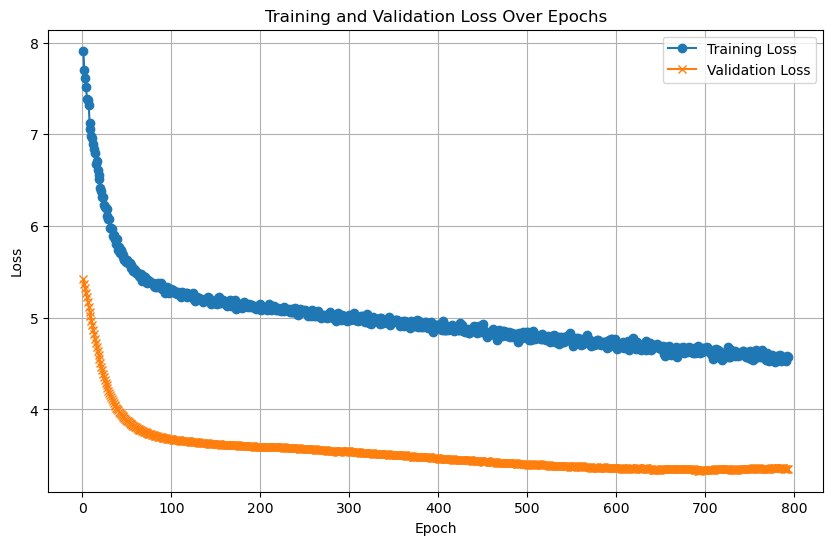

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/19], Loss: 7.2187

Test Loss: 5.1812


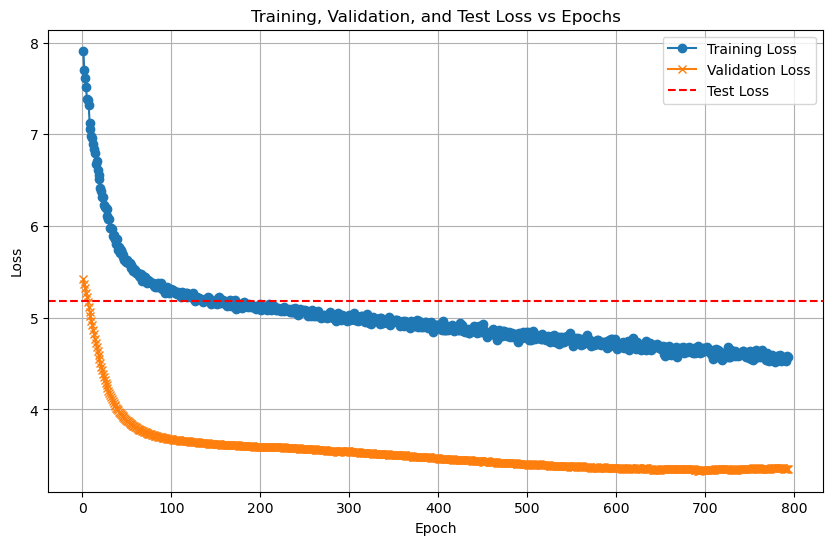

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/19 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 46.15%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       0.00      0.00      0.00         5
           2       1.00      0.20      0.33         5
           3       0.00      0.00      0.00         5
           4       0.33      0.60      0.43         5
           5       0.25      0.20      0.22         5
           6       0.45      1.00      0.62         5
           7       0.33      0.40      0.36         5
           8       0.50      1.00      0.67         5
           9       0.33      0.20      0.25         5
          10       1.00      0.80      0.89         5
          11       0.50      0.20      0.29         5
          12       0.80      0.80      0.80         5

    accuracy         

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5465  |  Val Loss: 2.5842
Validation loss improved from inf to 2.5842.
[Epoch 2/1000] Train Loss: 2.5161  |  Val Loss: 2.5632
Validation loss improved from 2.5842 to 2.5632.
[Epoch 3/1000] Train Loss: 2.4954  |  Val Loss: 2.5457
Validation loss improved from 2.5632 to 2.5457.
[Epoch 4/1000] Train Loss: 2.4768  |  Val Loss: 2.5283
Validation loss improved from 2.5457 to 2.5283.


[Epoch 5/1000] Train Loss: 2.4619  |  Val Loss: 2.5139
Validation loss improved from 2.5283 to 2.5139.
[Epoch 6/1000] Train Loss: 2.4511  |  Val Loss: 2.5050
Validation loss improved from 2.5139 to 2.5050.
[Epoch 7/1000] Train Loss: 2.4418  |  Val Loss: 2.4984
Validation loss improved from 2.5050 to 2.4984.
[Epoch 8/1000] Train Loss: 2.4343  |  Val Loss: 2.4926
Validation loss improved from 2.4984 to 2.4926.
[Epoch 9/1000] Train Loss: 2.4281  |  Val Loss: 2.4865
Validation loss improved from 2.4926 to 2.4865.


[Epoch 10/1000] Train Loss: 2.4224  |  Val Loss: 2.4824
Validation loss improved from 2.4865 to 2.4824.
[Epoch 11/1000] Train Loss: 2.4166  |  Val Loss: 2.4788
Validation loss improved from 2.4824 to 2.4788.
[Epoch 12/1000] Train Loss: 2.4111  |  Val Loss: 2.4764
Validation loss improved from 2.4788 to 2.4764.


[Epoch 13/1000] Train Loss: 2.4065  |  Val Loss: 2.4736
Validation loss improved from 2.4764 to 2.4736.
[Epoch 14/1000] Train Loss: 2.4015  |  Val Loss: 2.4697
Validation loss improved from 2.4736 to 2.4697.
[Epoch 15/1000] Train Loss: 2.3964  |  Val Loss: 2.4645
Validation loss improved from 2.4697 to 2.4645.
[Epoch 16/1000] Train Loss: 2.3915  |  Val Loss: 2.4606
Validation loss improved from 2.4645 to 2.4606.
[Epoch 17/1000] Train Loss: 2.3868  |  Val Loss: 2.4574
Validation loss improved from 2.4606 to 2.4574.


[Epoch 18/1000] Train Loss: 2.3818  |  Val Loss: 2.4543
Validation loss improved from 2.4574 to 2.4543.
[Epoch 19/1000] Train Loss: 2.3777  |  Val Loss: 2.4520
Validation loss improved from 2.4543 to 2.4520.
[Epoch 20/1000] Train Loss: 2.3731  |  Val Loss: 2.4493
Validation loss improved from 2.4520 to 2.4493.
[Epoch 21/1000] Train Loss: 2.3674  |  Val Loss: 2.4485
Validation loss improved from 2.4493 to 2.4485.


[Epoch 22/1000] Train Loss: 2.3650  |  Val Loss: 2.4453
Validation loss improved from 2.4485 to 2.4453.
[Epoch 23/1000] Train Loss: 2.3596  |  Val Loss: 2.4436
Validation loss improved from 2.4453 to 2.4436.
[Epoch 24/1000] Train Loss: 2.3547  |  Val Loss: 2.4390
Validation loss improved from 2.4436 to 2.4390.
[Epoch 25/1000] Train Loss: 2.3496  |  Val Loss: 2.4362
Validation loss improved from 2.4390 to 2.4362.


[Epoch 26/1000] Train Loss: 2.3443  |  Val Loss: 2.4331
Validation loss improved from 2.4362 to 2.4331.
[Epoch 27/1000] Train Loss: 2.3395  |  Val Loss: 2.4310
Validation loss improved from 2.4331 to 2.4310.
[Epoch 28/1000] Train Loss: 2.3351  |  Val Loss: 2.4318
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 29/1000] Train Loss: 2.3315  |  Val Loss: 2.4271
Validation loss improved from 2.4310 to 2.4271.
[Epoch 30/1000] Train Loss: 2.3264  |  Val Loss: 2.4235
Validation loss improved from 2.4271 to 2.4235.


[Epoch 31/1000] Train Loss: 2.3210  |  Val Loss: 2.4190
Validation loss improved from 2.4235 to 2.4190.
[Epoch 32/1000] Train Loss: 2.3164  |  Val Loss: 2.4180
Validation loss improved from 2.4190 to 2.4180.
[Epoch 33/1000] Train Loss: 2.3109  |  Val Loss: 2.4110
Validation loss improved from 2.4180 to 2.4110.


[Epoch 34/1000] Train Loss: 2.3058  |  Val Loss: 2.4068
Validation loss improved from 2.4110 to 2.4068.
[Epoch 35/1000] Train Loss: 2.3006  |  Val Loss: 2.4030
Validation loss improved from 2.4068 to 2.4030.
[Epoch 36/1000] Train Loss: 2.2959  |  Val Loss: 2.3956
Validation loss improved from 2.4030 to 2.3956.
[Epoch 37/1000] Train Loss: 2.2912  |  Val Loss: 2.3922
Validation loss improved from 2.3956 to 2.3922.
[Epoch 38/1000] Train Loss: 2.2860  |  Val Loss: 2.3884
Validation loss improved from 2.3922 to 2.3884.
[Epoch 39/1000] Train Loss: 2.2808  |  Val Loss: 2.3863
Validation loss improved from 2.3884 to 2.3863.


[Epoch 40/1000] Train Loss: 2.2761  |  Val Loss: 2.3835
Validation loss improved from 2.3863 to 2.3835.
[Epoch 41/1000] Train Loss: 2.2717  |  Val Loss: 2.3844
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 42/1000] Train Loss: 2.2649  |  Val Loss: 2.3810
Validation loss improved from 2.3835 to 2.3810.
[Epoch 43/1000] Train Loss: 2.2613  |  Val Loss: 2.3773
Validation loss improved from 2.3810 to 2.3773.


[Epoch 44/1000] Train Loss: 2.2554  |  Val Loss: 2.3720
Validation loss improved from 2.3773 to 2.3720.
[Epoch 45/1000] Train Loss: 2.2470  |  Val Loss: 2.3693
Validation loss improved from 2.3720 to 2.3693.


[Epoch 46/1000] Train Loss: 2.2406  |  Val Loss: 2.3695
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 47/1000] Train Loss: 2.2328  |  Val Loss: 2.3641
Validation loss improved from 2.3693 to 2.3641.
[Epoch 48/1000] Train Loss: 2.2282  |  Val Loss: 2.3567
Validation loss improved from 2.3641 to 2.3567.
[Epoch 49/1000] Train Loss: 2.2215  |  Val Loss: 2.3485
Validation loss improved from 2.3567 to 2.3485.
[Epoch 50/1000] Train Loss: 2.2164  |  Val Loss: 2.3434
Validation loss improved from 2.3485 to 2.3434.


[Epoch 51/1000] Train Loss: 2.2076  |  Val Loss: 2.3407
Validation loss improved from 2.3434 to 2.3407.
[Epoch 52/1000] Train Loss: 2.2000  |  Val Loss: 2.3367
Validation loss improved from 2.3407 to 2.3367.
[Epoch 53/1000] Train Loss: 2.1926  |  Val Loss: 2.3350
Validation loss improved from 2.3367 to 2.3350.
[Epoch 54/1000] Train Loss: 2.1865  |  Val Loss: 2.3314
Validation loss improved from 2.3350 to 2.3314.


[Epoch 55/1000] Train Loss: 2.1800  |  Val Loss: 2.3257
Validation loss improved from 2.3314 to 2.3257.
[Epoch 56/1000] Train Loss: 2.1730  |  Val Loss: 2.3213
Validation loss improved from 2.3257 to 2.3213.
[Epoch 57/1000] Train Loss: 2.1658  |  Val Loss: 2.3176
Validation loss improved from 2.3213 to 2.3176.


[Epoch 58/1000] Train Loss: 2.1574  |  Val Loss: 2.3135
Validation loss improved from 2.3176 to 2.3135.
[Epoch 59/1000] Train Loss: 2.1512  |  Val Loss: 2.3086
Validation loss improved from 2.3135 to 2.3086.
[Epoch 60/1000] Train Loss: 2.1436  |  Val Loss: 2.3034
Validation loss improved from 2.3086 to 2.3034.
[Epoch 61/1000] Train Loss: 2.1366  |  Val Loss: 2.2971
Validation loss improved from 2.3034 to 2.2971.


[Epoch 62/1000] Train Loss: 2.1289  |  Val Loss: 2.2905
Validation loss improved from 2.2971 to 2.2905.
[Epoch 63/1000] Train Loss: 2.1216  |  Val Loss: 2.2852
Validation loss improved from 2.2905 to 2.2852.
[Epoch 64/1000] Train Loss: 2.1139  |  Val Loss: 2.2805
Validation loss improved from 2.2852 to 2.2805.
[Epoch 65/1000] Train Loss: 2.1065  |  Val Loss: 2.2751
Validation loss improved from 2.2805 to 2.2751.


[Epoch 66/1000] Train Loss: 2.0989  |  Val Loss: 2.2687
Validation loss improved from 2.2751 to 2.2687.
[Epoch 67/1000] Train Loss: 2.0926  |  Val Loss: 2.2663
Validation loss improved from 2.2687 to 2.2663.
[Epoch 68/1000] Train Loss: 2.0851  |  Val Loss: 2.2616
Validation loss improved from 2.2663 to 2.2616.
[Epoch 69/1000] Train Loss: 2.0790  |  Val Loss: 2.2499
Validation loss improved from 2.2616 to 2.2499.


[Epoch 70/1000] Train Loss: 2.0693  |  Val Loss: 2.2430
Validation loss improved from 2.2499 to 2.2430.
[Epoch 71/1000] Train Loss: 2.0629  |  Val Loss: 2.2344
Validation loss improved from 2.2430 to 2.2344.
[Epoch 72/1000] Train Loss: 2.0546  |  Val Loss: 2.2315
Validation loss improved from 2.2344 to 2.2315.
[Epoch 73/1000] Train Loss: 2.0485  |  Val Loss: 2.2337
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 74/1000] Train Loss: 2.0394  |  Val Loss: 2.2255
Validation loss improved from 2.2315 to 2.2255.
[Epoch 75/1000] Train Loss: 2.0341  |  Val Loss: 2.2204
Validation loss improved from 2.2255 to 2.2204.
[Epoch 76/1000] Train Loss: 2.0268  |  Val Loss: 2.2166
Validation loss improved from 2.2204 to 2.2166.
[Epoch 77/1000] Train Loss: 2.0187  |  Val Loss: 2.2097
Validation loss improved from 2.2166 to 2.2097.


[Epoch 78/1000] Train Loss: 2.0100  |  Val Loss: 2.2040
Validation loss improved from 2.2097 to 2.2040.
[Epoch 79/1000] Train Loss: 2.0022  |  Val Loss: 2.1981
Validation loss improved from 2.2040 to 2.1981.
[Epoch 80/1000] Train Loss: 1.9946  |  Val Loss: 2.1922
Validation loss improved from 2.1981 to 2.1922.
[Epoch 81/1000] Train Loss: 1.9874  |  Val Loss: 2.1862
Validation loss improved from 2.1922 to 2.1862.
[Epoch 82/1000] Train Loss: 1.9817  |  Val Loss: 2.1852
Validation loss improved from 2.1862 to 2.1852.


[Epoch 83/1000] Train Loss: 1.9757  |  Val Loss: 2.1769
Validation loss improved from 2.1852 to 2.1769.
[Epoch 84/1000] Train Loss: 1.9663  |  Val Loss: 2.1729
Validation loss improved from 2.1769 to 2.1729.
[Epoch 85/1000] Train Loss: 1.9579  |  Val Loss: 2.1667
Validation loss improved from 2.1729 to 2.1667.
[Epoch 86/1000] Train Loss: 1.9507  |  Val Loss: 2.1598
Validation loss improved from 2.1667 to 2.1598.


[Epoch 87/1000] Train Loss: 1.9431  |  Val Loss: 2.1563
Validation loss improved from 2.1598 to 2.1563.
[Epoch 88/1000] Train Loss: 1.9353  |  Val Loss: 2.1520
Validation loss improved from 2.1563 to 2.1520.
[Epoch 89/1000] Train Loss: 1.9284  |  Val Loss: 2.1462
Validation loss improved from 2.1520 to 2.1462.
[Epoch 90/1000] Train Loss: 1.9199  |  Val Loss: 2.1450
Validation loss improved from 2.1462 to 2.1450.


[Epoch 91/1000] Train Loss: 1.9136  |  Val Loss: 2.1427
Validation loss improved from 2.1450 to 2.1427.
[Epoch 92/1000] Train Loss: 1.9051  |  Val Loss: 2.1347
Validation loss improved from 2.1427 to 2.1347.
[Epoch 93/1000] Train Loss: 1.8993  |  Val Loss: 2.1325
Validation loss improved from 2.1347 to 2.1325.
[Epoch 94/1000] Train Loss: 1.8921  |  Val Loss: 2.1242
Validation loss improved from 2.1325 to 2.1242.


[Epoch 95/1000] Train Loss: 1.8845  |  Val Loss: 2.1195
Validation loss improved from 2.1242 to 2.1195.
[Epoch 96/1000] Train Loss: 1.8762  |  Val Loss: 2.1130
Validation loss improved from 2.1195 to 2.1130.
[Epoch 97/1000] Train Loss: 1.8682  |  Val Loss: 2.1089
Validation loss improved from 2.1130 to 2.1089.
[Epoch 98/1000] Train Loss: 1.8607  |  Val Loss: 2.1031
Validation loss improved from 2.1089 to 2.1031.


[Epoch 99/1000] Train Loss: 1.8540  |  Val Loss: 2.0973
Validation loss improved from 2.1031 to 2.0973.
[Epoch 100/1000] Train Loss: 1.8458  |  Val Loss: 2.0947
Validation loss improved from 2.0973 to 2.0947.
[Epoch 101/1000] Train Loss: 1.8389  |  Val Loss: 2.0898
Validation loss improved from 2.0947 to 2.0898.


[Epoch 102/1000] Train Loss: 1.8314  |  Val Loss: 2.0828
Validation loss improved from 2.0898 to 2.0828.
[Epoch 103/1000] Train Loss: 1.8263  |  Val Loss: 2.0788
Validation loss improved from 2.0828 to 2.0788.
[Epoch 104/1000] Train Loss: 1.8179  |  Val Loss: 2.0740
Validation loss improved from 2.0788 to 2.0740.
[Epoch 105/1000] Train Loss: 1.8114  |  Val Loss: 2.0691
Validation loss improved from 2.0740 to 2.0691.
[Epoch 106/1000] Train Loss: 1.8039  |  Val Loss: 2.0723
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 107/1000] Train Loss: 1.7974  |  Val Loss: 2.0620
Validation loss improved from 2.0691 to 2.0620.
[Epoch 108/1000] Train Loss: 1.7898  |  Val Loss: 2.0632
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 109/1000] Train Loss: 1.7826  |  Val Loss: 2.0527
Validation loss improved from 2.0620 to 2.0527.
[Epoch 110/1000] Train Loss: 1.7742  |  Val Loss: 2.0496
Validation loss improved from 2.0527 to 2.0496.
[Epoch 111/1000] Train Loss: 1.7665  |  Val Loss: 2.0432
Validation loss improved from 2.0496 to 2.0432.
[Epoch 112/1000] Train Loss: 1.7588  |  Val Loss: 2.0383
Validation loss improved from 2.0432 to 2.0383.


[Epoch 113/1000] Train Loss: 1.7516  |  Val Loss: 2.0331
Validation loss improved from 2.0383 to 2.0331.
[Epoch 114/1000] Train Loss: 1.7456  |  Val Loss: 2.0267
Validation loss improved from 2.0331 to 2.0267.
[Epoch 115/1000] Train Loss: 1.7379  |  Val Loss: 2.0219
Validation loss improved from 2.0267 to 2.0219.
[Epoch 116/1000] Train Loss: 1.7296  |  Val Loss: 2.0193
Validation loss improved from 2.0219 to 2.0193.
[Epoch 117/1000] Train Loss: 1.7233  |  Val Loss: 2.0133
Validation loss improved from 2.0193 to 2.0133.


[Epoch 118/1000] Train Loss: 1.7160  |  Val Loss: 2.0073
Validation loss improved from 2.0133 to 2.0073.
[Epoch 119/1000] Train Loss: 1.7097  |  Val Loss: 2.0064
Validation loss improved from 2.0073 to 2.0064.
[Epoch 120/1000] Train Loss: 1.7033  |  Val Loss: 2.0107
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 121/1000] Train Loss: 1.6969  |  Val Loss: 2.0070
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 122/1000] Train Loss: 1.6895  |  Val Loss: 1.9984
Validation loss improved from 2.0064 to 1.9984.
[Epoch 123/1000] Train Loss: 1.6826  |  Val Loss: 1.9874
Validation loss improved from 1.9984 to 1.9874.


[Epoch 124/1000] Train Loss: 1.6757  |  Val Loss: 1.9787
Validation loss improved from 1.9874 to 1.9787.
[Epoch 125/1000] Train Loss: 1.6687  |  Val Loss: 1.9760
Validation loss improved from 1.9787 to 1.9760.
[Epoch 126/1000] Train Loss: 1.6623  |  Val Loss: 1.9749
Validation loss improved from 1.9760 to 1.9749.
[Epoch 127/1000] Train Loss: 1.6559  |  Val Loss: 1.9679
Validation loss improved from 1.9749 to 1.9679.
[Epoch 128/1000] Train Loss: 1.6497  |  Val Loss: 1.9620
Validation loss improved from 1.9679 to 1.9620.
[Epoch 129/1000] Train Loss: 1.6439  |  Val Loss: 1.9636
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 130/1000] Train Loss: 1.6354  |  Val Loss: 1.9570
Validation loss improved from 1.9620 to 1.9570.
[Epoch 131/1000] Train Loss: 1.6291  |  Val Loss: 1.9530
Validation loss improved from 1.9570 to 1.9530.
[Epoch 132/1000] Train Loss: 1.6231  |  Val Loss: 1.9542
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 133/1000] Train Loss: 1.6183  |  Val Loss: 1.9510
Validation loss improved from 1.9530 to 1.9510.
[Epoch 134/1000] Train Loss: 1.6104  |  Val Loss: 1.9442
Validation loss improved from 1.9510 to 1.9442.
[Epoch 135/1000] Train Loss: 1.6087  |  Val Loss: 1.9284
Validation loss improved from 1.9442 to 1.9284.
[Epoch 136/1000] Train Loss: 1.6013  |  Val Loss: 1.9269
Validation loss improved from 1.9284 to 1.9269.


[Epoch 137/1000] Train Loss: 1.5928  |  Val Loss: 1.9287
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 138/1000] Train Loss: 1.5864  |  Val Loss: 1.9261
Validation loss improved from 1.9269 to 1.9261.
[Epoch 139/1000] Train Loss: 1.5799  |  Val Loss: 1.9146
Validation loss improved from 1.9261 to 1.9146.
[Epoch 140/1000] Train Loss: 1.5758  |  Val Loss: 1.9117
Validation loss improved from 1.9146 to 1.9117.
[Epoch 141/1000] Train Loss: 1.5697  |  Val Loss: 1.9151
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 142/1000] Train Loss: 1.5662  |  Val Loss: 1.9129
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 143/1000] Train Loss: 1.5581  |  Val Loss: 1.9142
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 144/1000] Train Loss: 1.5521  |  Val Loss: 1.9111
Validation loss improved from 1.9117 to 1.9111.
[Epoch 145/1000] Train Loss: 1.5461  |  Val Loss: 1.9048
Validation loss improved from 1.9111 to 1.9048.
[Epoch 146/1000] Train Loss: 1.5498  |  Val Loss: 1.8983
Validation loss improved from 1.9048 to 1.8983.
[Epoch 147/1000] Train Loss: 1.5374  |  Val Loss: 1.8958
Validation loss improved from 1.8983 to 1.8958.
[Epoch 148/1000] Train Loss: 1.5304  |  Val Loss: 1.8853
Validation loss improved from 1.8958 to 1.8853.
[Epoch 149/1000] Train Loss: 1.5230  |  Val Loss: 1.8834
Validation loss improved from 1.8853 to 1.8834.


[Epoch 150/1000] Train Loss: 1.5185  |  Val Loss: 1.8918
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 1.5147  |  Val Loss: 1.8841
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 1.5101  |  Val Loss: 1.8829
Validation loss improved from 1.8834 to 1.8829.
[Epoch 153/1000] Train Loss: 1.5057  |  Val Loss: 1.8765
Validation loss improved from 1.8829 to 1.8765.
[Epoch 154/1000] Train Loss: 1.4992  |  Val Loss: 1.8738
Validation loss improved from 1.8765 to 1.8738.


[Epoch 155/1000] Train Loss: 1.4920  |  Val Loss: 1.8693
Validation loss improved from 1.8738 to 1.8693.
[Epoch 156/1000] Train Loss: 1.4880  |  Val Loss: 1.8715
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 157/1000] Train Loss: 1.4837  |  Val Loss: 1.8781
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 158/1000] Train Loss: 1.4799  |  Val Loss: 1.8665
Validation loss improved from 1.8693 to 1.8665.
[Epoch 159/1000] Train Loss: 1.4731  |  Val Loss: 1.8535
Validation loss improved from 1.8665 to 1.8535.
[Epoch 160/1000] Train Loss: 1.4705  |  Val Loss: 1.8513
Validation loss improved from 1.8535 to 1.8513.
[Epoch 161/1000] Train Loss: 1.4642  |  Val Loss: 1.8491
Validation loss improved from 1.8513 to 1.8491.


[Epoch 162/1000] Train Loss: 1.4601  |  Val Loss: 1.8540
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 163/1000] Train Loss: 1.4745  |  Val Loss: 1.8691
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 164/1000] Train Loss: 1.4551  |  Val Loss: 1.8496
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 165/1000] Train Loss: 1.4561  |  Val Loss: 1.8447
Validation loss improved from 1.8491 to 1.8447.
[Epoch 166/1000] Train Loss: 1.4434  |  Val Loss: 1.8463
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 167/1000] Train Loss: 1.4349  |  Val Loss: 1.8468
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 168/1000] Train Loss: 1.4304  |  Val Loss: 1.8414
Validation loss improved from 1.8447 to 1.8414.
[Epoch 169/1000] Train Loss: 1.4246  |  Val Loss: 1.8362
Validation loss improved from 1.8414 to 1.8362.
[Epoch 170/1000] Train Loss: 1.4204  |  Val Loss: 1.8300
Validation loss improved from 1.8362 to 1.8300.
[Epoch 171/1000] Train Loss: 1.4174  |  Val Loss: 1.8167
Validation loss improved from 1.8300 to 1.8167.
[Epoch 172/1000] Train Loss: 1.4130  |  Val Loss: 1.8203
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 173/1000] Train Loss: 1.4097  |  Val Loss: 1.8211
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 1.4039  |  Val Loss: 1.8176
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 175/1000] Train Loss: 1.3999  |  Val Loss: 1.8161
Validation loss improved from 1.8167 to 1.8161.
[Epoch 176/1000] Train Loss: 1.3957  |  Val Loss: 1.8169
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 1.3909  |  Val Loss: 1.8342
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 178/1000] Train Loss: 1.3963  |  Val Loss: 1.8253
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 1.3834  |  Val Loss: 1.8158
Validation loss improved from 1.8161 to 1.8158.
[Epoch 180/1000] Train Loss: 1.3806  |  Val Loss: 1.8116
Validation loss improved from 1.8158 to 1.8116.
[Epoch 181/1000] Train Loss: 1.3759  |  Val Loss: 1.8125
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 182/1000] Train Loss: 1.3701  |  Val Loss: 1.8112
Validation loss improved from 1.8116 to 1.8112.
[Epoch 183/1000] Train Loss: 1.3658  |  Val Loss: 1.8099
Validation loss improved from 1.8112 to 1.8099.
[Epoch 184/1000] Train Loss: 1.3618  |  Val Loss: 1.8080
Validation loss improved from 1.8099 to 1.8080.


[Epoch 185/1000] Train Loss: 1.3573  |  Val Loss: 1.8149
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 1.3586  |  Val Loss: 1.8161
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 187/1000] Train Loss: 1.3550  |  Val Loss: 1.8063
Validation loss improved from 1.8080 to 1.8063.
[Epoch 188/1000] Train Loss: 1.3468  |  Val Loss: 1.8006
Validation loss improved from 1.8063 to 1.8006.
[Epoch 189/1000] Train Loss: 1.3446  |  Val Loss: 1.7992
Validation loss improved from 1.8006 to 1.7992.


[Epoch 190/1000] Train Loss: 1.3413  |  Val Loss: 1.7987
Validation loss improved from 1.7992 to 1.7987.
[Epoch 191/1000] Train Loss: 1.3399  |  Val Loss: 1.7798
Validation loss improved from 1.7987 to 1.7798.
[Epoch 192/1000] Train Loss: 1.3342  |  Val Loss: 1.7785
Validation loss improved from 1.7798 to 1.7785.
[Epoch 193/1000] Train Loss: 1.3296  |  Val Loss: 1.7804
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 1.3264  |  Val Loss: 1.7896
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 195/1000] Train Loss: 1.3243  |  Val Loss: 1.7879
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 196/1000] Train Loss: 1.3181  |  Val Loss: 1.7866
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 197/1000] Train Loss: 1.3160  |  Val Loss: 1.7898
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 198/1000] Train Loss: 1.3143  |  Val Loss: 1.7893
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 199/1000] Train Loss: 1.3102  |  Val Loss: 1.7813
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 200/1000] Train Loss: 1.3096  |  Val Loss: 1.7758
Validation loss improved from 1.7785 to 1.7758.
[Epoch 201/1000] Train Loss: 1.3101  |  Val Loss: 1.7724
Validation loss improved from 1.7758 to 1.7724.
[Epoch 202/1000] Train Loss: 1.2991  |  Val Loss: 1.7788
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 203/1000] Train Loss: 1.2945  |  Val Loss: 1.7771
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 204/1000] Train Loss: 1.2909  |  Val Loss: 1.7804
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 205/1000] Train Loss: 1.2879  |  Val Loss: 1.7811
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 206/1000] Train Loss: 1.2847  |  Val Loss: 1.7771
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 207/1000] Train Loss: 1.2827  |  Val Loss: 1.7846
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 208/1000] Train Loss: 1.2780  |  Val Loss: 1.7755
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 209/1000] Train Loss: 1.2716  |  Val Loss: 1.7783
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 210/1000] Train Loss: 1.2740  |  Val Loss: 1.7763
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 211/1000] Train Loss: 1.2735  |  Val Loss: 1.7721
Validation loss improved from 1.7724 to 1.7721.
[Epoch 212/1000] Train Loss: 1.2666  |  Val Loss: 1.7679
Validation loss improved from 1.7721 to 1.7679.


[Epoch 213/1000] Train Loss: 1.2672  |  Val Loss: 1.7750
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 214/1000] Train Loss: 1.2646  |  Val Loss: 1.7674
Validation loss improved from 1.7679 to 1.7674.
[Epoch 215/1000] Train Loss: 1.2572  |  Val Loss: 1.7648
Validation loss improved from 1.7674 to 1.7648.
[Epoch 216/1000] Train Loss: 1.2557  |  Val Loss: 1.7620
Validation loss improved from 1.7648 to 1.7620.
[Epoch 217/1000] Train Loss: 1.2526  |  Val Loss: 1.7588
Validation loss improved from 1.7620 to 1.7588.
[Epoch 218/1000] Train Loss: 1.2472  |  Val Loss: 1.7599
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 219/1000] Train Loss: 1.2465  |  Val Loss: 1.7591
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 220/1000] Train Loss: 1.2433  |  Val Loss: 1.7825
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 221/1000] Train Loss: 1.2456  |  Val Loss: 1.7869
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 222/1000] Train Loss: 1.2401  |  Val Loss: 1.7783
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 223/1000] Train Loss: 1.2356  |  Val Loss: 1.7709
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 224/1000] Train Loss: 1.2333  |  Val Loss: 1.7641
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 225/1000] Train Loss: 1.2293  |  Val Loss: 1.7638
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 226/1000] Train Loss: 1.2250  |  Val Loss: 1.7559
Validation loss improved from 1.7588 to 1.7559.
[Epoch 227/1000] Train Loss: 1.2223  |  Val Loss: 1.7506
Validation loss improved from 1.7559 to 1.7506.
[Epoch 228/1000] Train Loss: 1.2223  |  Val Loss: 1.7489
Validation loss improved from 1.7506 to 1.7489.
[Epoch 229/1000] Train Loss: 1.2200  |  Val Loss: 1.7375
Validation loss improved from 1.7489 to 1.7375.


[Epoch 230/1000] Train Loss: 1.2215  |  Val Loss: 1.7430
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 231/1000] Train Loss: 1.2135  |  Val Loss: 1.7445
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 232/1000] Train Loss: 1.2093  |  Val Loss: 1.7499
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 233/1000] Train Loss: 1.2067  |  Val Loss: 1.7580
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 234/1000] Train Loss: 1.2049  |  Val Loss: 1.7584
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 235/1000] Train Loss: 1.2010  |  Val Loss: 1.7536
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 236/1000] Train Loss: 1.1992  |  Val Loss: 1.7568
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 237/1000] Train Loss: 1.1961  |  Val Loss: 1.7530
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 238/1000] Train Loss: 1.1935  |  Val Loss: 1.7479
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 239/1000] Train Loss: 1.1913  |  Val Loss: 1.7468
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 240/1000] Train Loss: 1.1883  |  Val Loss: 1.7431
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 241/1000] Train Loss: 1.1871  |  Val Loss: 1.7410
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 242/1000] Train Loss: 1.1832  |  Val Loss: 1.7406
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 243/1000] Train Loss: 1.1815  |  Val Loss: 1.7423
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 244/1000] Train Loss: 1.1793  |  Val Loss: 1.7440
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 245/1000] Train Loss: 1.1777  |  Val Loss: 1.7408
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 246/1000] Train Loss: 1.1742  |  Val Loss: 1.7370
Validation loss improved from 1.7375 to 1.7370.
[Epoch 247/1000] Train Loss: 1.1735  |  Val Loss: 1.7433
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 248/1000] Train Loss: 1.1773  |  Val Loss: 1.7461
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 249/1000] Train Loss: 1.1710  |  Val Loss: 1.7327
Validation loss improved from 1.7370 to 1.7327.
[Epoch 250/1000] Train Loss: 1.1682  |  Val Loss: 1.7396
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 251/1000] Train Loss: 1.1667  |  Val Loss: 1.7372
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 252/1000] Train Loss: 1.1623  |  Val Loss: 1.7369
!! Validation loss did NOT improve !! Patience: 3/100


[Epoch 253/1000] Train Loss: 1.1637  |  Val Loss: 1.7404
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 254/1000] Train Loss: 1.1569  |  Val Loss: 1.7399
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 255/1000] Train Loss: 1.1588  |  Val Loss: 1.7595
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 256/1000] Train Loss: 1.1562  |  Val Loss: 1.7538
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 257/1000] Train Loss: 1.1534  |  Val Loss: 1.7419
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 258/1000] Train Loss: 1.1496  |  Val Loss: 1.7368
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 259/1000] Train Loss: 1.1468  |  Val Loss: 1.7366
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 260/1000] Train Loss: 1.1497  |  Val Loss: 1.7284
Validation loss improved from 1.7327 to 1.7284.


[Epoch 261/1000] Train Loss: 1.1464  |  Val Loss: 1.7244
Validation loss improved from 1.7284 to 1.7244.
[Epoch 262/1000] Train Loss: 1.1421  |  Val Loss: 1.7249
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 263/1000] Train Loss: 1.1416  |  Val Loss: 1.7310
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 264/1000] Train Loss: 1.1407  |  Val Loss: 1.7289
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 265/1000] Train Loss: 1.1368  |  Val Loss: 1.7348
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 266/1000] Train Loss: 1.1368  |  Val Loss: 1.7373
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 267/1000] Train Loss: 1.1322  |  Val Loss: 1.7340
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 268/1000] Train Loss: 1.1294  |  Val Loss: 1.7232
Validation loss improved from 1.7244 to 1.7232.
[Epoch 269/1000] Train Loss: 1.1332  |  Val Loss: 1.7309
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 270/1000] Train Loss: 1.1252  |  Val Loss: 1.7338
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 271/1000] Train Loss: 1.1232  |  Val Loss: 1.7363
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 272/1000] Train Loss: 1.1223  |  Val Loss: 1.7372
!! Validation loss did NOT improve !! Patience: 4/100


[Epoch 273/1000] Train Loss: 1.1192  |  Val Loss: 1.7349
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 274/1000] Train Loss: 1.1204  |  Val Loss: 1.7333
!! Validation loss did NOT improve !! Patience: 6/100


[Epoch 275/1000] Train Loss: 1.1183  |  Val Loss: 1.7288
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 276/1000] Train Loss: 1.1138  |  Val Loss: 1.7263
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 277/1000] Train Loss: 1.1112  |  Val Loss: 1.7260
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 278/1000] Train Loss: 1.1109  |  Val Loss: 1.7209
Validation loss improved from 1.7232 to 1.7209.
[Epoch 279/1000] Train Loss: 1.1109  |  Val Loss: 1.7223
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 280/1000] Train Loss: 1.1078  |  Val Loss: 1.7215
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 281/1000] Train Loss: 1.1052  |  Val Loss: 1.7227
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 282/1000] Train Loss: 1.1030  |  Val Loss: 1.7212
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 283/1000] Train Loss: 1.1054  |  Val Loss: 1.7223
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 285/1000] Train Loss: 1.1002  |  Val Loss: 1.7241
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 286/1000] Train Loss: 1.0978  |  Val Loss: 1.7230
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 287/1000] Train Loss: 1.0947  |  Val Loss: 1.7240
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 288/1000] Train Loss: 1.0948  |  Val Loss: 1.7189
Validation loss improved from 1.7209 to 1.7189.
[Epoch 289/1000] Train Loss: 1.0941  |  Val Loss: 1.7002
Validation loss improved from 1.7189 to 1.7002.
[Epoch 290/1000] Train Loss: 1.0934  |  Val Loss: 1.6959
Validation loss improved from 1.7002 to 1.6959.
[Epoch 291/1000] Train Loss: 1.0940  |  Val Loss: 1.7068
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 292/1000] Train Loss: 1.0913  |  Val Loss: 1.7069
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 293/1000] Train Loss: 1.0870  |  Val Loss: 1.7098
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 294/1000] Tr

[Epoch 297/1000] Train Loss: 1.0833  |  Val Loss: 1.7096
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 298/1000] Train Loss: 1.0790  |  Val Loss: 1.7107
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 299/1000] Train Loss: 1.0758  |  Val Loss: 1.7137
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 300/1000] Train Loss: 1.0766  |  Val Loss: 1.7194
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 301/1000] Train Loss: 1.0725  |  Val Loss: 1.7211
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 302/1000] Train Loss: 1.0758  |  Val Loss: 1.7196
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 303/1000] Train Loss: 1.0734  |  Val Loss: 1.7148
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 304/1000] Train Loss: 1.0684  |  Val Loss: 1.7116
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 305/1000] Train Loss: 1.0682  |  Val Loss: 1.7140
!! Validation loss did NOT improve !! Patience: 15

[Epoch 310/1000] Train Loss: 1.0641  |  Val Loss: 1.7230
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 311/1000] Train Loss: 1.0587  |  Val Loss: 1.7170
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 312/1000] Train Loss: 1.0594  |  Val Loss: 1.6957
Validation loss improved from 1.6959 to 1.6957.
[Epoch 313/1000] Train Loss: 1.0591  |  Val Loss: 1.6949
Validation loss improved from 1.6957 to 1.6949.
[Epoch 314/1000] Train Loss: 1.0551  |  Val Loss: 1.6971
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 1.0543  |  Val Loss: 1.7048
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 316/1000] Train Loss: 1.0564  |  Val Loss: 1.7110
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 317/1000] Train Loss: 1.0515  |  Val Loss: 1.7129
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 318/1000] Train Loss: 1.0501  |  Val Loss: 1.7148
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 319/

[Epoch 321/1000] Train Loss: 1.0459  |  Val Loss: 1.7166
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 322/1000] Train Loss: 1.0438  |  Val Loss: 1.7227
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 323/1000] Train Loss: 1.0431  |  Val Loss: 1.7193
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 324/1000] Train Loss: 1.0430  |  Val Loss: 1.7121
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 325/1000] Train Loss: 1.0404  |  Val Loss: 1.7148
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 326/1000] Train Loss: 1.0387  |  Val Loss: 1.7161
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 327/1000] Train Loss: 1.0376  |  Val Loss: 1.7200
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 328/1000] Train Loss: 1.0385  |  Val Loss: 1.7142
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 329/1000] Train Loss: 1.0341  |  Val Loss: 1.7138
!! Validation loss did NOT improve !! Patience: 1

[Epoch 333/1000] Train Loss: 1.0345  |  Val Loss: 1.7161
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 334/1000] Train Loss: 1.0287  |  Val Loss: 1.7153
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 335/1000] Train Loss: 1.0365  |  Val Loss: 1.7127
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 336/1000] Train Loss: 1.0372  |  Val Loss: 1.7177
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 337/1000] Train Loss: 1.0365  |  Val Loss: 1.7055
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 338/1000] Train Loss: 1.0252  |  Val Loss: 1.7081
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 339/1000] Train Loss: 1.0258  |  Val Loss: 1.7035
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 340/1000] Train Loss: 1.0227  |  Val Loss: 1.7061
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 341/1000] Train Loss: 1.0209  |  Val Loss: 1.7105
!! Validation loss did NOT improve !! Patience:

[Epoch 343/1000] Train Loss: 1.0193  |  Val Loss: 1.7134
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 344/1000] Train Loss: 1.0185  |  Val Loss: 1.6931
Validation loss improved from 1.6949 to 1.6931.
[Epoch 345/1000] Train Loss: 1.0187  |  Val Loss: 1.6975
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 346/1000] Train Loss: 1.0250  |  Val Loss: 1.7042
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 347/1000] Train Loss: 1.0167  |  Val Loss: 1.7016
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 348/1000] Train Loss: 1.0180  |  Val Loss: 1.7078
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 349/1000] Train Loss: 1.0134  |  Val Loss: 1.7057
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 350/1000] Train Loss: 1.0118  |  Val Loss: 1.7040
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 351/1000] Train Loss: 1.0131  |  Val Loss: 1.6916
Validation loss improved from 1.6931 to 1.6916.
[Epoch 352/1

[Epoch 355/1000] Train Loss: 1.0063  |  Val Loss: 1.7102
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 356/1000] Train Loss: 1.0047  |  Val Loss: 1.7073
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 357/1000] Train Loss: 1.0040  |  Val Loss: 1.7077
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 358/1000] Train Loss: 1.0023  |  Val Loss: 1.7052
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 359/1000] Train Loss: 1.0010  |  Val Loss: 1.7058
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 360/1000] Train Loss: 1.0007  |  Val Loss: 1.7090
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 361/1000] Train Loss: 0.9998  |  Val Loss: 1.7078
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 362/1000] Train Loss: 0.9984  |  Val Loss: 1.7114
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 363/1000] Train Loss: 0.9978  |  Val Loss: 1.7144
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 368/1000] Train Loss: 0.9924  |  Val Loss: 1.7081
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 369/1000] Train Loss: 0.9979  |  Val Loss: 1.6916
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 370/1000] Train Loss: 0.9933  |  Val Loss: 1.6972
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 371/1000] Train Loss: 0.9918  |  Val Loss: 1.7037
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 372/1000] Train Loss: 0.9898  |  Val Loss: 1.7040
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 373/1000] Train Loss: 0.9883  |  Val Loss: 1.7063
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 374/1000] Train Loss: 0.9870  |  Val Loss: 1.7063
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 375/1000] Train Loss: 0.9886  |  Val Loss: 1.7071
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 376/1000] Train Loss: 0.9889  |  Val Loss: 1.6951
!! Validation loss did NOT improve !! Patience:

[Epoch 379/1000] Train Loss: 0.9863  |  Val Loss: 1.6829
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 380/1000] Train Loss: 0.9844  |  Val Loss: 1.6986
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 381/1000] Train Loss: 0.9806  |  Val Loss: 1.7073
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 382/1000] Train Loss: 0.9809  |  Val Loss: 1.7094
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 383/1000] Train Loss: 0.9808  |  Val Loss: 1.6965
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 384/1000] Train Loss: 0.9871  |  Val Loss: 1.7049
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 385/1000] Train Loss: 0.9812  |  Val Loss: 1.7053
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 386/1000] Train Loss: 0.9781  |  Val Loss: 1.7165
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 387/1000] Train Loss: 0.9764  |  Val Loss: 1.7188
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 390/1000] Train Loss: 0.9749  |  Val Loss: 1.7137
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 391/1000] Train Loss: 0.9717  |  Val Loss: 1.7172
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 392/1000] Train Loss: 0.9708  |  Val Loss: 1.7169
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 393/1000] Train Loss: 0.9694  |  Val Loss: 1.7178
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 394/1000] Train Loss: 0.9687  |  Val Loss: 1.7193
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 395/1000] Train Loss: 0.9673  |  Val Loss: 1.7181
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 396/1000] Train Loss: 0.9668  |  Val Loss: 1.7171
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 397/1000] Train Loss: 0.9677  |  Val Loss: 1.7124
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 398/1000] Train Loss: 0.9692  |  Val Loss: 1.7228
!! Validation loss did NOT improve !! Patience:

[Epoch 401/1000] Train Loss: 0.9634  |  Val Loss: 1.7217
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 402/1000] Train Loss: 0.9612  |  Val Loss: 1.7208
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 403/1000] Train Loss: 0.9617  |  Val Loss: 1.7212
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 404/1000] Train Loss: 0.9599  |  Val Loss: 1.7230
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 405/1000] Train Loss: 0.9600  |  Val Loss: 1.7223
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 406/1000] Train Loss: 0.9596  |  Val Loss: 1.7254
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 407/1000] Train Loss: 0.9582  |  Val Loss: 1.7255
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 408/1000] Train Loss: 0.9571  |  Val Loss: 1.7220
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 409/1000] Train Loss: 0.9568  |  Val Loss: 1.7170
!! Validation loss did NOT improve !! Patience:

[Epoch 413/1000] Train Loss: 0.9568  |  Val Loss: 1.7456
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 414/1000] Train Loss: 0.9540  |  Val Loss: 1.7445
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 415/1000] Train Loss: 0.9540  |  Val Loss: 1.7407
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 416/1000] Train Loss: 0.9519  |  Val Loss: 1.7312
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 417/1000] Train Loss: 0.9501  |  Val Loss: 1.7258
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 418/1000] Train Loss: 0.9502  |  Val Loss: 1.7250
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 419/1000] Train Loss: 0.9492  |  Val Loss: 1.7256
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 420/1000] Train Loss: 0.9482  |  Val Loss: 1.7310
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 421/1000] Train Loss: 0.9495  |  Val Loss: 1.7399
!! Validation loss did NOT improve !! Patience:

[Epoch 425/1000] Train Loss: 0.9443  |  Val Loss: 1.7256
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 426/1000] Train Loss: 0.9432  |  Val Loss: 1.7244
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 427/1000] Train Loss: 0.9426  |  Val Loss: 1.7409
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 428/1000] Train Loss: 0.9433  |  Val Loss: 1.7447
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 429/1000] Train Loss: 0.9518  |  Val Loss: 1.7417
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 430/1000] Train Loss: 0.9438  |  Val Loss: 1.7311
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 431/1000] Train Loss: 0.9467  |  Val Loss: 1.7307
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 432/1000] Train Loss: 0.9453  |  Val Loss: 1.7374
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 433/1000] Train Loss: 0.9508  |  Val Loss: 1.7534
!! Validation loss did NOT improve !! Patience:

[Epoch 437/1000] Train Loss: 0.9384  |  Val Loss: 1.7414
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 438/1000] Train Loss: 0.9366  |  Val Loss: 1.7388
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 439/1000] Train Loss: 0.9360  |  Val Loss: 1.7384
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 440/1000] Train Loss: 0.9337  |  Val Loss: 1.7402
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 441/1000] Train Loss: 0.9320  |  Val Loss: 1.7400
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 442/1000] Train Loss: 0.9330  |  Val Loss: 1.7422
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 443/1000] Train Loss: 0.9330  |  Val Loss: 1.7444
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 444/1000] Train Loss: 0.9325  |  Val Loss: 1.7364
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 445/1000] Train Loss: 0.9298  |  Val Loss: 1.7335
!! Validation loss did NOT improve !! Patience:

[Epoch 449/1000] Train Loss: 0.9269  |  Val Loss: 1.7413
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 450/1000] Train Loss: 0.9273  |  Val Loss: 1.7410
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 451/1000] Train Loss: 0.9247  |  Val Loss: 1.7396
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 452/1000] Train Loss: 0.9251  |  Val Loss: 1.7421
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 453/1000] Train Loss: 0.9251  |  Val Loss: 1.7428
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 454/1000] Train Loss: 0.9239  |  Val Loss: 1.7435
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 455/1000] Train Loss: 0.9241  |  Val Loss: 1.7426
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 456/1000] Train Loss: 0.9221  |  Val Loss: 1.7381
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 457/1000] Train Loss: 0.9244  |  Val Loss: 1.7337
!! Validation loss did NOT improve !! Patience:

[Epoch 461/1000] Train Loss: 0.9183  |  Val Loss: 1.7391
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 462/1000] Train Loss: 0.9177  |  Val Loss: 1.7406
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 463/1000] Train Loss: 0.9171  |  Val Loss: 1.7420
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 464/1000] Train Loss: 0.9160  |  Val Loss: 1.7440
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 465/1000] Train Loss: 0.9151  |  Val Loss: 1.7452
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 466/1000] Train Loss: 0.9150  |  Val Loss: 1.7456
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 467/1000] Train Loss: 0.9164  |  Val Loss: 1.7489
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 468/1000] Train Loss: 0.9132  |  Val Loss: 1.7576
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 469/1000] Train Loss: 0.9155  |  Val Loss: 1.7559
!! Validation loss did NOT improve !! Patience:

[Epoch 473/1000] Train Loss: 0.9099  |  Val Loss: 1.7506
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 474/1000] Train Loss: 0.9099  |  Val Loss: 1.7478
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 475/1000] Train Loss: 0.9112  |  Val Loss: 1.7494
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 476/1000] Train Loss: 0.9085  |  Val Loss: 1.7465
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 477/1000] Train Loss: 0.9088  |  Val Loss: 1.7487
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 478/1000] Train Loss: 0.9069  |  Val Loss: 1.7504
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 478 !!
No improvement for 100 epochs.


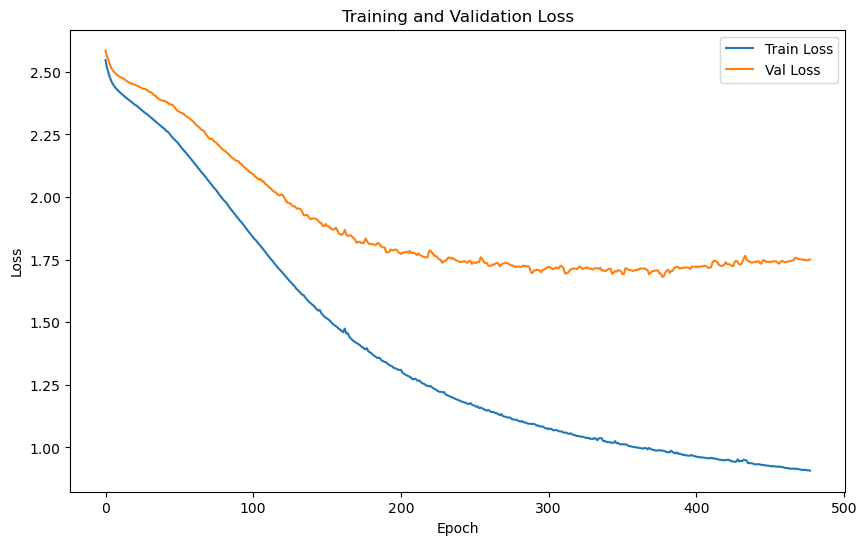

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.9250 | Test Accuracy: 56.94%


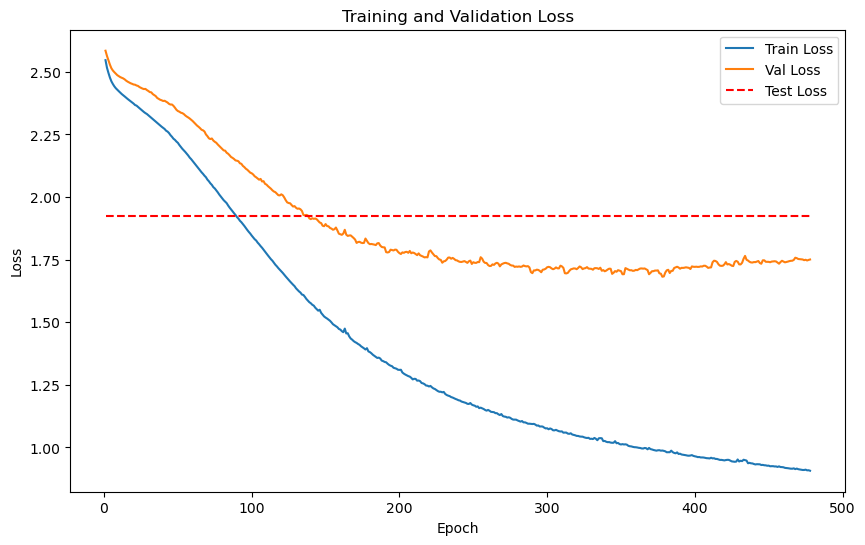

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 520 samples with 64 features each
LOG: Labels shape: (520,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 4626 samples with 64 features each
LOG: Labels shape: (4626,)


Train embeddings shape: (520, 64), 
Train labels shape: (520,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (4626, 64), 
Test labels shape: (4626,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20, 9: 20, 10: 20, 11: 20, 12: 20}
Training batch size: 260


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.5255
    Batch [2/2], Train Loss: 0.5282
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6198
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5269, Avg Val Loss: 0.5599

Validation loss improved from inf to 0.5599. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.5250
    Batch [2/2], Train Loss: 0.5226
LOG: Epoch [2/2000] - Validation


    Batch [1/2], Val Loss: 0.6173
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5238, Avg Val Loss: 0.5586

Validation loss improved from 0.5599 to 0.5586. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.5268


    Batch [2/2], Train Loss: 0.5283
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.6161
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5276, Avg Val Loss: 0.5580

Validation loss improved from 0.5586 to 0.5580. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.5246


    Batch [2/2], Train Loss: 0.5238
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6137
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5242, Avg Val Loss: 0.5568

Validation loss improved from 0.5580 to 0.5568. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.5217


    Batch [2/2], Train Loss: 0.5216
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6107
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5217, Avg Val Loss: 0.5554

Validation loss improved from 0.5568 to 0.5554. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.5241


    Batch [2/2], Train Loss: 0.5191
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.6084
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5216, Avg Val Loss: 0.5542

Validation loss improved from 0.5554 to 0.5542. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.5187


    Batch [2/2], Train Loss: 0.5216
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6046
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5202, Avg Val Loss: 0.5523

Validation loss improved from 0.5542 to 0.5523. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.5200


    Batch [2/2], Train Loss: 0.5192
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.5987
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5196, Avg Val Loss: 0.5494

Validation loss improved from 0.5523 to 0.5494. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.5177


    Batch [2/2], Train Loss: 0.5153
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.5936
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5468

Validation loss improved from 0.5494 to 0.5468. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/2], Train Loss: 0.5165


    Batch [2/2], Train Loss: 0.5150
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.5884
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5157, Avg Val Loss: 0.5442

Validation loss improved from 0.5468 to 0.5442. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.5125


    Batch [2/2], Train Loss: 0.5149
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5827
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5137, Avg Val Loss: 0.5413

Validation loss improved from 0.5442 to 0.5413. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.5155


    Batch [2/2], Train Loss: 0.5088
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5754
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5121, Avg Val Loss: 0.5377

Validation loss improved from 0.5413 to 0.5377. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 0.5120


    Batch [2/2], Train Loss: 0.5095
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.5677
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5107, Avg Val Loss: 0.5338

Validation loss improved from 0.5377 to 0.5338. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.5124


    Batch [2/2], Train Loss: 0.5091
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5610
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5107, Avg Val Loss: 0.5305

Validation loss improved from 0.5338 to 0.5305. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.5084


    Batch [2/2], Train Loss: 0.5113
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5563
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5099, Avg Val Loss: 0.5281

Validation loss improved from 0.5305 to 0.5281. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.5119


    Batch [2/2], Train Loss: 0.5096
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.5506
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5108, Avg Val Loss: 0.5253

Validation loss improved from 0.5281 to 0.5253. Saving model...
LOG: Epoch [17/2000] - Training


    Batch [1/2], Train Loss: 0.5115
    Batch [2/2], Train Loss: 0.5081
LOG: Epoch [17/2000] - Validation


    Batch [1/2], Val Loss: 0.5462
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5098, Avg Val Loss: 0.5231

Validation loss improved from 0.5253 to 0.5231. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.5062


    Batch [2/2], Train Loss: 0.5082
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5421
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5072, Avg Val Loss: 0.5211

Validation loss improved from 0.5231 to 0.5211. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.5066


    Batch [2/2], Train Loss: 0.5067
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5400
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5067, Avg Val Loss: 0.5200

Validation loss improved from 0.5211 to 0.5200. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.5082


    Batch [2/2], Train Loss: 0.5073
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.5378
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5078, Avg Val Loss: 0.5189

Validation loss improved from 0.5200 to 0.5189. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.5041


    Batch [2/2], Train Loss: 0.5083
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5345
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5062, Avg Val Loss: 0.5172

Validation loss improved from 0.5189 to 0.5172. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.5076


    Batch [2/2], Train Loss: 0.5060
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5335
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5068, Avg Val Loss: 0.5167

Validation loss improved from 0.5172 to 0.5167. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.5075


    Batch [2/2], Train Loss: 0.5046
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5321
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5060, Avg Val Loss: 0.5161

Validation loss improved from 0.5167 to 0.5161. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.5079


    Batch [2/2], Train Loss: 0.5068
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5296
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5074, Avg Val Loss: 0.5148

Validation loss improved from 0.5161 to 0.5148. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.5064


    Batch [2/2], Train Loss: 0.5032
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5282
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5048, Avg Val Loss: 0.5141

Validation loss improved from 0.5148 to 0.5141. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/2], Train Loss: 0.5070
    Batch [2/2], Train Loss: 0.5029
LOG: Epoch [26/2000] - Validation


    Batch [1/2], Val Loss: 0.5271
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5135

Validation loss improved from 0.5141 to 0.5135. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.5047


    Batch [2/2], Train Loss: 0.5044
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.5263
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5045, Avg Val Loss: 0.5131

Validation loss improved from 0.5135 to 0.5131. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.5026
    Batch [2/2], Train Loss: 0.5054
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.5258
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5040, Avg Val Loss: 0.5129

Validation loss improved from 0.5131 to 0.5129. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.5013


    Batch [2/2], Train Loss: 0.5063
LOG: Epoch [29/2000] - Validation
    Batch [1/2], Val Loss: 0.5254
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5127

Validation loss improved from 0.5129 to 0.5127. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4988


    Batch [2/2], Train Loss: 0.5021
LOG: Epoch [30/2000] - Validation
    Batch [1/2], Val Loss: 0.5245
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5005, Avg Val Loss: 0.5123

Validation loss improved from 0.5127 to 0.5123. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.5035


    Batch [2/2], Train Loss: 0.5035
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5237
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5035, Avg Val Loss: 0.5119

Validation loss improved from 0.5123 to 0.5119. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.5033


    Batch [2/2], Train Loss: 0.5016
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5229
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5024, Avg Val Loss: 0.5114

Validation loss improved from 0.5119 to 0.5114. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.5008
    Batch [2/2], Train Loss: 0.5021
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5217
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5015, Avg Val Loss: 0.5108

Validation loss improved from 0.5114 to 0.5108. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.5003
    Batch [2/2], Train Loss: 0.5022
LOG: Epoch [34/2000] - Validation


    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5012, Avg Val Loss: 0.5106

Validation loss improved from 0.5108 to 0.5106. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.5059


    Batch [2/2], Train Loss: 0.5068
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5210
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5105

Validation loss improved from 0.5106 to 0.5105. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/2], Train Loss: 0.5042
    Batch [2/2], Train Loss: 0.5009
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5202
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5101

Validation loss improved from 0.5105 to 0.5101. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.5021
    Batch [2/2], Train Loss: 0.5029
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5025, Avg Val Loss: 0.5098

Validation loss improved from 0.5101 to 0.5098. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4990


    Batch [2/2], Train Loss: 0.5036
LOG: Epoch [38/2000] - Validation
    Batch [1/2], Val Loss: 0.5188
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5094

Validation loss improved from 0.5098 to 0.5094. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.5047


    Batch [2/2], Train Loss: 0.4988
LOG: Epoch [39/2000] - Validation
    Batch [1/2], Val Loss: 0.5183
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5018, Avg Val Loss: 0.5091

Validation loss improved from 0.5094 to 0.5091. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.5009
    Batch [2/2], Train Loss: 0.4987
LOG: Epoch [40/2000] - Validation
    Batch [1/2], Val Loss: 0.5182
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.4998, Avg Val Loss: 0.5091

Validation loss improved from 0.5091 to 0.5091. Saving model...
LOG: Epoch [41/2000] - Training


    Batch [1/2], Train Loss: 0.4996
    Batch [2/2], Train Loss: 0.5007
LOG: Epoch [41/2000] - Validation
    Batch [1/2], Val Loss: 0.5172
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5002, Avg Val Loss: 0.5086

Validation loss improved from 0.5091 to 0.5086. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.5022
    Batch [2/2], Train Loss: 0.4997
LOG: Epoch [42/2000] - Validation
    Batch [1/2], Val Loss: 0.5167
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5010, Avg Val Loss: 0.5084

Validation loss improved from 0.5086 to 0.5084. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.4996
    Batch [2/2], Train Loss: 0.5004
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5169
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5000, Avg Val Loss: 0.5085

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [44/2000] - Training


    Batch [1/2], Train Loss: 0.4975
    Batch [2/2], Train Loss: 0.4983
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.4979, Avg Val Loss: 0.5081

Validation loss improved from 0.5084 to 0.5081. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.5009


    Batch [2/2], Train Loss: 0.4985
LOG: Epoch [45/2000] - Validation
    Batch [1/2], Val Loss: 0.5151
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5076

Validation loss improved from 0.5081 to 0.5076. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 0.4999


    Batch [2/2], Train Loss: 0.5041
LOG: Epoch [46/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5020, Avg Val Loss: 0.5076

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4987


    Batch [2/2], Train Loss: 0.5019
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5153
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5077

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.4960


    Batch [2/2], Train Loss: 0.4947
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5149
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5074

Validation loss improved from 0.5076 to 0.5074. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.5007


    Batch [2/2], Train Loss: 0.5034
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [50/2000] - Training
    Batch [1/2], Train Loss: 0.4988


    Batch [2/2], Train Loss: 0.5003
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4972


    Batch [2/2], Train Loss: 0.4972
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5150
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5075

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.5001


    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5074

Validation loss improved from 0.5074 to 0.5074. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.5036


    Batch [2/2], Train Loss: 0.4991
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.5142
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5013, Avg Val Loss: 0.5071

Validation loss improved from 0.5074 to 0.5071. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 0.4995


    Batch [2/2], Train Loss: 0.4972
LOG: Epoch [54/2000] - Validation
    Batch [1/2], Val Loss: 0.5140
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5070

Validation loss improved from 0.5071 to 0.5070. Saving model...
LOG: Epoch [55/2000] - Training


    Batch [1/2], Train Loss: 0.4915
    Batch [2/2], Train Loss: 0.4955
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5129
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5064

Validation loss improved from 0.5070 to 0.5064. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/2], Train Loss: 0.4953
    Batch [2/2], Train Loss: 0.4957
LOG: Epoch [56/2000] - Validation


    Batch [1/2], Val Loss: 0.5125
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5062

Validation loss improved from 0.5064 to 0.5062. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.4968


    Batch [2/2], Train Loss: 0.4961
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5060

Validation loss improved from 0.5062 to 0.5060. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.4993


    Batch [2/2], Train Loss: 0.4963
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5118
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5059

Validation loss improved from 0.5060 to 0.5059. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.4992


    Batch [2/2], Train Loss: 0.4974
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5114
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.5057

Validation loss improved from 0.5059 to 0.5057. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.5015


    Batch [2/2], Train Loss: 0.5016
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5119
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5016, Avg Val Loss: 0.5059

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [61/2000] - Training


    Batch [1/2], Train Loss: 0.4980
    Batch [2/2], Train Loss: 0.4992
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.5115
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.4986, Avg Val Loss: 0.5058

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.4987
    Batch [2/2], Train Loss: 0.4943
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5113
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.4965, Avg Val Loss: 0.5057

Validation loss improved from 0.5057 to 0.5057. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/2], Train Loss: 0.4974
    Batch [2/2], Train Loss: 0.4929
LOG: Epoch [63/2000] - Validation


    Batch [1/2], Val Loss: 0.5112
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5056

Validation loss improved from 0.5057 to 0.5056. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.4923


    Batch [2/2], Train Loss: 0.4976
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.5110
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5055

Validation loss improved from 0.5056 to 0.5055. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.4988


    Batch [2/2], Train Loss: 0.4967
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5056

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.4940


    Batch [2/2], Train Loss: 0.4964
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.5109
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5055

Validation loss improved from 0.5055 to 0.5055. Saving model...
LOG: Epoch [67/2000] - Training


    Batch [1/2], Train Loss: 0.4951
    Batch [2/2], Train Loss: 0.4947
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.5105
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5053

Validation loss improved from 0.5055 to 0.5053. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.4948
    Batch [2/2], Train Loss: 0.5017
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.4982, Avg Val Loss: 0.5049

Validation loss improved from 0.5053 to 0.5049. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/2], Train Loss: 0.4968
    Batch [2/2], Train Loss: 0.4936
LOG: Epoch [69/2000] - Validation


    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.4952, Avg Val Loss: 0.5046

Validation loss improved from 0.5049 to 0.5046. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.4973


    Batch [2/2], Train Loss: 0.4971
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4972, Avg Val Loss: 0.5043

Validation loss improved from 0.5046 to 0.5043. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.4962


    Batch [2/2], Train Loss: 0.4935
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5086
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5043

Validation loss improved from 0.5043 to 0.5043. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.4950


    Batch [2/2], Train Loss: 0.4960
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.5091
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.4955, Avg Val Loss: 0.5045

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.4933


    Batch [2/2], Train Loss: 0.4969
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [74/2000] - Training


    Batch [1/2], Train Loss: 0.4894
    Batch [2/2], Train Loss: 0.4969
LOG: Epoch [74/2000] - Validation


    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.4936


    Batch [2/2], Train Loss: 0.4932
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.5094
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5047

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.4985
    Batch [2/2], Train Loss: 0.4967
LOG: Epoch [76/2000] - Validation


    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.4976, Avg Val Loss: 0.5041

Validation loss improved from 0.5043 to 0.5041. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.4973


    Batch [2/2], Train Loss: 0.4940
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5084
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.4957, Avg Val Loss: 0.5042

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [78/2000] - Training


    Batch [1/2], Train Loss: 0.4942
    Batch [2/2], Train Loss: 0.4938
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4940, Avg Val Loss: 0.5036

Validation loss improved from 0.5041 to 0.5036. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.4955
    Batch [2/2], Train Loss: 0.4937
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.5073
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5037

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.4951
    Batch [2/2], Train Loss: 0.4924
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.5071
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.4937, Avg Val Loss: 0.5036

Validation loss improved from 0.5036 to 0.5036. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/2], Train Loss: 0.4911
    Batch [2/2], Train Loss: 0.4939
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.5054
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4925, Avg Val Loss: 0.5027

Validation loss improved from 0.5036 to 0.5027. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.4953
    Batch [2/2], Train Loss: 0.4954
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.5050
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5025

Validation loss improved from 0.5027 to 0.5025. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.4936
    Batch [2/2], Train Loss: 0.4932
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5023

Validation loss improved from 0.5025 to 0.5023. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/2], Train Loss: 0.4952
    Batch [2/2], Train Loss: 0.4902
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5049
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4927, Avg Val Loss: 0.5025

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [85/2000] - Training


    Batch [1/2], Train Loss: 0.4922
    Batch [2/2], Train Loss: 0.4921
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.5023

Validation loss improved from 0.5023 to 0.5023. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.4908
    Batch [2/2], Train Loss: 0.4894
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5046
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5023

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.4867
    Batch [2/2], Train Loss: 0.4937
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5042
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.5021

Validation loss improved from 0.5023 to 0.5021. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.4878


    Batch [2/2], Train Loss: 0.4959
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.5020

Validation loss improved from 0.5021 to 0.5020. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.4908


    Batch [2/2], Train Loss: 0.4929
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5033
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.4918, Avg Val Loss: 0.5016

Validation loss improved from 0.5020 to 0.5016. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.4953


    Batch [2/2], Train Loss: 0.4938
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.5030
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4946, Avg Val Loss: 0.5015

Validation loss improved from 0.5016 to 0.5015. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.4962


    Batch [2/2], Train Loss: 0.4935
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5021
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5011

Validation loss improved from 0.5015 to 0.5011. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.4976


    Batch [2/2], Train Loss: 0.4927
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4951, Avg Val Loss: 0.5009

Validation loss improved from 0.5011 to 0.5009. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.4875


    Batch [2/2], Train Loss: 0.4897
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5025
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4886, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [94/2000] - Training


    Batch [1/2], Train Loss: 0.4927
    Batch [2/2], Train Loss: 0.4980
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.5024
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4954, Avg Val Loss: 0.5012

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [95/2000] - Training


    Batch [1/2], Train Loss: 0.4914
    Batch [2/2], Train Loss: 0.4882
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.4898, Avg Val Loss: 0.5011

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.4914
    Batch [2/2], Train Loss: 0.4911
LOG: Epoch [96/2000] - Validation


    Batch [1/2], Val Loss: 0.5016
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.5008

Validation loss improved from 0.5009 to 0.5008. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.4950


    Batch [2/2], Train Loss: 0.4919
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5004
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4934, Avg Val Loss: 0.5002

Validation loss improved from 0.5008 to 0.5002. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.4972


    Batch [2/2], Train Loss: 0.4891
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5000

Validation loss improved from 0.5002 to 0.5000. Saving model...
LOG: Epoch [99/2000] - Training


    Batch [1/2], Train Loss: 0.4908
    Batch [2/2], Train Loss: 0.4919
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4913, Avg Val Loss: 0.4998

Validation loss improved from 0.5000 to 0.4998. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.4914


    Batch [2/2], Train Loss: 0.4933
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4923, Avg Val Loss: 0.4994

Validation loss improved from 0.4998 to 0.4994. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.4917


    Batch [2/2], Train Loss: 0.4960
LOG: Epoch [101/2000] - Validation
    Batch [1/2], Val Loss: 0.4991
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4939, Avg Val Loss: 0.4995

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.4918


    Batch [2/2], Train Loss: 0.4965
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4988
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4942, Avg Val Loss: 0.4994

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.4914


    Batch [2/2], Train Loss: 0.4886
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4987
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4900, Avg Val Loss: 0.4993

Validation loss improved from 0.4994 to 0.4993. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.4909


    Batch [2/2], Train Loss: 0.4872
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4988

Validation loss improved from 0.4993 to 0.4988. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 0.4916


    Batch [2/2], Train Loss: 0.4936
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4926, Avg Val Loss: 0.4988

Validation loss improved from 0.4988 to 0.4988. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/2], Train Loss: 0.4918
    Batch [2/2], Train Loss: 0.4920
LOG: Epoch [106/2000] - Validation


    Batch [1/2], Val Loss: 0.4975
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4919, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.4904


    Batch [2/2], Train Loss: 0.4900
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4902, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.4856


    Batch [2/2], Train Loss: 0.4932
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4965
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.4982

Validation loss improved from 0.4986 to 0.4982. Saving model...
LOG: Epoch [109/2000] - Training


    Batch [1/2], Train Loss: 0.4899
    Batch [2/2], Train Loss: 0.4881
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4983

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.4884
    Batch [2/2], Train Loss: 0.4932
LOG: Epoch [110/2000] - Validation


    Batch [1/2], Val Loss: 0.4961
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4908, Avg Val Loss: 0.4981

Validation loss improved from 0.4982 to 0.4981. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.4919


    Batch [2/2], Train Loss: 0.4892
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4906, Avg Val Loss: 0.4980

Validation loss improved from 0.4981 to 0.4980. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.4882


    Batch [2/2], Train Loss: 0.4852
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4980

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.4896


    Batch [2/2], Train Loss: 0.4970
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4933, Avg Val Loss: 0.4978

Validation loss improved from 0.4980 to 0.4978. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.4906


    Batch [2/2], Train Loss: 0.4875
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.4955
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.4868


    Batch [2/2], Train Loss: 0.4824
LOG: Epoch [115/2000] - Validation
    Batch [1/2], Val Loss: 0.4953
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4977

Validation loss improved from 0.4977 to 0.4977. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 0.4907


    Batch [2/2], Train Loss: 0.4834
LOG: Epoch [116/2000] - Validation
    Batch [1/2], Val Loss: 0.4945
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4870, Avg Val Loss: 0.4973

Validation loss improved from 0.4977 to 0.4973. Saving model...
LOG: Epoch [117/2000] - Training


    Batch [1/2], Train Loss: 0.4900
    Batch [2/2], Train Loss: 0.4837
LOG: Epoch [117/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4868, Avg Val Loss: 0.4974

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [118/2000] - Training


    Batch [1/2], Train Loss: 0.4954
    Batch [2/2], Train Loss: 0.4876
LOG: Epoch [118/2000] - Validation
    Batch [1/2], Val Loss: 0.4943
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4915, Avg Val Loss: 0.4971

Validation loss improved from 0.4973 to 0.4971. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.4843
    Batch [2/2], Train Loss: 0.4909
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4876, Avg Val Loss: 0.4966

Validation loss improved from 0.4971 to 0.4966. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.4861


    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4857, Avg Val Loss: 0.4965

Validation loss improved from 0.4966 to 0.4965. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.4884


    Batch [2/2], Train Loss: 0.4872
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4878, Avg Val Loss: 0.4962

Validation loss improved from 0.4965 to 0.4962. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.4837


    Batch [2/2], Train Loss: 0.4886
LOG: Epoch [122/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4965

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.4906


    Batch [2/2], Train Loss: 0.4903
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [124/2000] - Training


    Batch [1/2], Train Loss: 0.4864


    Batch [2/2], Train Loss: 0.4915
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4929
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.4965

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [125/2000] - Training


    Batch [1/2], Train Loss: 0.4861
    Batch [2/2], Train Loss: 0.4849
LOG: Epoch [125/2000] - Validation


    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4855, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.4902


    Batch [2/2], Train Loss: 0.4861
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.4878


    Batch [2/2], Train Loss: 0.4838
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4858, Avg Val Loss: 0.4960

Validation loss improved from 0.4962 to 0.4960. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.4839


    Batch [2/2], Train Loss: 0.4849
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4844, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [129/2000] - Training


    Batch [1/2], Train Loss: 0.4802
    Batch [2/2], Train Loss: 0.4828
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4815, Avg Val Loss: 0.4962

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.4886
    Batch [2/2], Train Loss: 0.4849
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4867, Avg Val Loss: 0.4960

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.4810
    Batch [2/2], Train Loss: 0.4844
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4827, Avg Val Loss: 0.4960

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [132/2000] - Training


    Batch [1/2], Train Loss: 0.4860
    Batch [2/2], Train Loss: 0.4879
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4920
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.4960

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.4870
    Batch [2/2], Train Loss: 0.4812
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4841, Avg Val Loss: 0.4958

Validation loss improved from 0.4960 to 0.4958. Saving model...
LOG: Epoch [134/2000] - Training


    Batch [1/2], Train Loss: 0.4852
    Batch [2/2], Train Loss: 0.4907
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.4962

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.4842
    Batch [2/2], Train Loss: 0.4811
LOG: Epoch [135/2000] - Validation


    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4961

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.4866


    Batch [2/2], Train Loss: 0.4839
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.4958

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [137/2000] - Training


    Batch [1/2], Train Loss: 0.4868
    Batch [2/2], Train Loss: 0.4857
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.4955

Validation loss improved from 0.4958 to 0.4955. Saving model...
LOG: Epoch [138/2000] - Training


    Batch [1/2], Train Loss: 0.4790
    Batch [2/2], Train Loss: 0.4798
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4954

Validation loss improved from 0.4955 to 0.4954. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/2], Train Loss: 0.4858


    Batch [2/2], Train Loss: 0.4835
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4846, Avg Val Loss: 0.4952

Validation loss improved from 0.4954 to 0.4952. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.4839
    Batch [2/2], Train Loss: 0.4823
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4898
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.4949

Validation loss improved from 0.4952 to 0.4949. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/2], Train Loss: 0.4855
    Batch [2/2], Train Loss: 0.4867
LOG: Epoch [141/2000] - Validation


    Batch [1/2], Val Loss: 0.4894
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.4947

Validation loss improved from 0.4949 to 0.4947. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.4840


    Batch [2/2], Train Loss: 0.4826
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4891
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4833, Avg Val Loss: 0.4946

Validation loss improved from 0.4947 to 0.4946. Saving model...
LOG: Epoch [143/2000] - Training


    Batch [1/2], Train Loss: 0.4844
    Batch [2/2], Train Loss: 0.4883
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.4941

Validation loss improved from 0.4946 to 0.4941. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.4734
    Batch [2/2], Train Loss: 0.4787
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4937

Validation loss improved from 0.4941 to 0.4937. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.4786
    Batch [2/2], Train Loss: 0.4789
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4934

Validation loss improved from 0.4937 to 0.4934. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.4795


    Batch [2/2], Train Loss: 0.4833
LOG: Epoch [146/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4931

Validation loss improved from 0.4934 to 0.4931. Saving model...
LOG: Epoch [147/2000] - Training


    Batch [1/2], Train Loss: 0.4837
    Batch [2/2], Train Loss: 0.4794
LOG: Epoch [147/2000] - Validation


    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4931

Validation loss improved from 0.4931 to 0.4931. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.4802


    Batch [2/2], Train Loss: 0.4818
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4810, Avg Val Loss: 0.4930

Validation loss improved from 0.4931 to 0.4930. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.4814


    Batch [2/2], Train Loss: 0.4835
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4825, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.4808


    Batch [2/2], Train Loss: 0.4826
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4928

Validation loss improved from 0.4930 to 0.4928. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.4805


    Batch [2/2], Train Loss: 0.4787
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.4823


    Batch [2/2], Train Loss: 0.4812
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4817, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.4871
    Batch [2/2], Train Loss: 0.4790
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.4748
    Batch [2/2], Train Loss: 0.4818
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4783, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [155/2000] - Training


    Batch [1/2], Train Loss: 0.4815
    Batch [2/2], Train Loss: 0.4774
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.4926

Validation loss improved from 0.4928 to 0.4926. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.4809
    Batch [2/2], Train Loss: 0.4887
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.4923

Validation loss improved from 0.4926 to 0.4923. Saving model...
LOG: Epoch [157/2000] - Training


    Batch [1/2], Train Loss: 0.4809
    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4922

Validation loss improved from 0.4923 to 0.4922. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.4776


    Batch [2/2], Train Loss: 0.4784
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.4803


    Batch [2/2], Train Loss: 0.4860
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4832, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [160/2000] - Training


    Batch [1/2], Train Loss: 0.4786
    Batch [2/2], Train Loss: 0.4854
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4820, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [161/2000] - Training


    Batch [1/2], Train Loss: 0.4800
    Batch [2/2], Train Loss: 0.4812
LOG: Epoch [161/2000] - Validation


    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4921

Validation loss improved from 0.4922 to 0.4921. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.4819


    Batch [2/2], Train Loss: 0.4761
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4790, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.4827


    Batch [2/2], Train Loss: 0.4815
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [164/2000] - Training


    Batch [1/2], Train Loss: 0.4823
    Batch [2/2], Train Loss: 0.4768
LOG: Epoch [164/2000] - Validation


    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.4779


    Batch [2/2], Train Loss: 0.4783
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4781, Avg Val Loss: 0.4921

Validation loss improved from 0.4921 to 0.4921. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.4796


    Batch [2/2], Train Loss: 0.4781
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4919

Validation loss improved from 0.4921 to 0.4919. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.4818
    Batch [2/2], Train Loss: 0.4831
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4831
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4916

Validation loss improved from 0.4919 to 0.4916. Saving model...
LOG: Epoch [168/2000] - Training


    Batch [1/2], Train Loss: 0.4784
    Batch [2/2], Train Loss: 0.4777
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4913

Validation loss improved from 0.4916 to 0.4913. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.4749
    Batch [2/2], Train Loss: 0.4772
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4760, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [170/2000] - Training


    Batch [1/2], Train Loss: 0.4833
    Batch [2/2], Train Loss: 0.4760
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4824
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4912

Validation loss improved from 0.4913 to 0.4912. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.4834
    Batch [2/2], Train Loss: 0.4855
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4845, Avg Val Loss: 0.4910

Validation loss improved from 0.4912 to 0.4910. Saving model...
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.4800
    Batch [2/2], Train Loss: 0.4777
LOG: Epoch [172/2000] - Validation


    Batch [1/2], Val Loss: 0.4816
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4789, Avg Val Loss: 0.4908

Validation loss improved from 0.4910 to 0.4908. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.4845


    Batch [2/2], Train Loss: 0.4841
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4812
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.4906

Validation loss improved from 0.4908 to 0.4906. Saving model...
LOG: Epoch [174/2000] - Training


    Batch [1/2], Train Loss: 0.4805
    Batch [2/2], Train Loss: 0.4826
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4816, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.4782
    Batch [2/2], Train Loss: 0.4801
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4791, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.4720
    Batch [2/2], Train Loss: 0.4832
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [177/2000] - Training


    Batch [1/2], Train Loss: 0.4785
    Batch [2/2], Train Loss: 0.4765
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.4821
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4910

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.4773


    Batch [2/2], Train Loss: 0.4744
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.4775


    Batch [2/2], Train Loss: 0.4817
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4796, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.4738


    Batch [2/2], Train Loss: 0.4723
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [181/2000] - Training


    Batch [1/2], Train Loss: 0.4837
    Batch [2/2], Train Loss: 0.4739
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4788, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.4798
    Batch [2/2], Train Loss: 0.4797
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4817
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4908

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.4754
    Batch [2/2], Train Loss: 0.4757
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4755, Avg Val Loss: 0.4903

Validation loss improved from 0.4906 to 0.4903. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.4773


    Batch [2/2], Train Loss: 0.4750
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.4771


    Batch [2/2], Train Loss: 0.4767
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4807
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4903

Validation loss improved from 0.4903 to 0.4903. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.4758
    Batch [2/2], Train Loss: 0.4750
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4809
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4905

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.4790
    Batch [2/2], Train Loss: 0.4710
LOG: Epoch [187/2000] - Validation
    Batch [1/2], Val Loss: 0.4814
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [188/2000] - Training


    Batch [1/2], Train Loss: 0.4765
    Batch [2/2], Train Loss: 0.4793
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4815
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.4907

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [189/2000] - Training


    Batch [1/2], Train Loss: 0.4821
    Batch [2/2], Train Loss: 0.4701
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.4754
    Batch [2/2], Train Loss: 0.4784
LOG: Epoch [190/2000] - Validation


    Batch [1/2], Val Loss: 0.4808
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4904

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.4764


    Batch [2/2], Train Loss: 0.4687
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4726, Avg Val Loss: 0.4901

Validation loss improved from 0.4903 to 0.4901. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.4759


    Batch [2/2], Train Loss: 0.4684
LOG: Epoch [192/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4901

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.4799


    Batch [2/2], Train Loss: 0.4726
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4801
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4763, Avg Val Loss: 0.4901

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.4703


    Batch [2/2], Train Loss: 0.4719
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4901

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.4785


    Batch [2/2], Train Loss: 0.4733
LOG: Epoch [195/2000] - Validation
    Batch [1/2], Val Loss: 0.4802
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4759, Avg Val Loss: 0.4901

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [196/2000] - Training


    Batch [1/2], Train Loss: 0.4760
    Batch [2/2], Train Loss: 0.4713
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4899

Validation loss improved from 0.4901 to 0.4899. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.4712
    Batch [2/2], Train Loss: 0.4678
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4799
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4899

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.4740
    Batch [2/2], Train Loss: 0.4702
LOG: Epoch [198/2000] - Validation
    Batch [1/2], Val Loss: 0.4797
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4721, Avg Val Loss: 0.4899

Validation loss improved from 0.4899 to 0.4899. Saving model...
LOG: Epoch [199/2000] - Training


    Batch [1/2], Train Loss: 0.4733
    Batch [2/2], Train Loss: 0.4711
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4793
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4722, Avg Val Loss: 0.4896

Validation loss improved from 0.4899 to 0.4896. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.4714
    Batch [2/2], Train Loss: 0.4767
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4783
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4741, Avg Val Loss: 0.4891

Validation loss improved from 0.4896 to 0.4891. Saving model...
LOG: Epoch [201/2000] - Training


    Batch [1/2], Train Loss: 0.4726
    Batch [2/2], Train Loss: 0.4740
LOG: Epoch [201/2000] - Validation
    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4733, Avg Val Loss: 0.4889

Validation loss improved from 0.4891 to 0.4889. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.4740
    Batch [2/2], Train Loss: 0.4714
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.4777
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4888

Validation loss improved from 0.4889 to 0.4888. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.4749


    Batch [2/2], Train Loss: 0.4773
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4761, Avg Val Loss: 0.4887

Validation loss improved from 0.4888 to 0.4887. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.4712
    Batch [2/2], Train Loss: 0.4797
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4754, Avg Val Loss: 0.4881

Validation loss improved from 0.4887 to 0.4881. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.4744
    Batch [2/2], Train Loss: 0.4728
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4736, Avg Val Loss: 0.4877

Validation loss improved from 0.4881 to 0.4877. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.4702


    Batch [2/2], Train Loss: 0.4753
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4728, Avg Val Loss: 0.4881

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.4716
    Batch [2/2], Train Loss: 0.4674
LOG: Epoch [207/2000] - Validation


    Batch [1/2], Val Loss: 0.4763
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4695, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.4672


    Batch [2/2], Train Loss: 0.4713
LOG: Epoch [208/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [209/2000] - Training


    Batch [1/2], Train Loss: 0.4737
    Batch [2/2], Train Loss: 0.4755
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4746, Avg Val Loss: 0.4885

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.4767
    Batch [2/2], Train Loss: 0.4730
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4774
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4748, Avg Val Loss: 0.4887

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [211/2000] - Training


    Batch [1/2], Train Loss: 0.4754
    Batch [2/2], Train Loss: 0.4751
LOG: Epoch [211/2000] - Validation
    Batch [1/2], Val Loss: 0.4771
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4753, Avg Val Loss: 0.4885

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [212/2000] - Training


    Batch [1/2], Train Loss: 0.4721
    Batch [2/2], Train Loss: 0.4678
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4769
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4885

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [213/2000] - Training


    Batch [1/2], Train Loss: 0.4713
    Batch [2/2], Train Loss: 0.4741
LOG: Epoch [213/2000] - Validation


    Batch [1/2], Val Loss: 0.4764
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 0.4684


    Batch [2/2], Train Loss: 0.4747
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4765
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4882

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.4680


    Batch [2/2], Train Loss: 0.4711
LOG: Epoch [215/2000] - Validation
    Batch [1/2], Val Loss: 0.4762
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4696, Avg Val Loss: 0.4881

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [216/2000] - Training


    Batch [1/2], Train Loss: 0.4776
    Batch [2/2], Train Loss: 0.4619
LOG: Epoch [216/2000] - Validation
    Batch [1/2], Val Loss: 0.4759
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.4622
    Batch [2/2], Train Loss: 0.4663
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4642, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.4624
    Batch [2/2], Train Loss: 0.4776
LOG: Epoch [218/2000] - Validation


    Batch [1/2], Val Loss: 0.4766
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4700, Avg Val Loss: 0.4883

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.4770


    Batch [2/2], Train Loss: 0.4747
LOG: Epoch [219/2000] - Validation
    Batch [1/2], Val Loss: 0.4758
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4758, Avg Val Loss: 0.4879

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.4682


    Batch [2/2], Train Loss: 0.4697
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4876

Validation loss improved from 0.4877 to 0.4876. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.4695


    Batch [2/2], Train Loss: 0.4759
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4727, Avg Val Loss: 0.4874

Validation loss improved from 0.4876 to 0.4874. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.4719
    Batch [2/2], Train Loss: 0.4778
LOG: Epoch [222/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4749, Avg Val Loss: 0.4872

Validation loss improved from 0.4874 to 0.4872. Saving model...
LOG: Epoch [223/2000] - Training


    Batch [1/2], Train Loss: 0.4672
    Batch [2/2], Train Loss: 0.4758
LOG: Epoch [223/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4715, Avg Val Loss: 0.4873

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.4677
    Batch [2/2], Train Loss: 0.4695
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4872

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.4641
    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [225/2000] - Validation


    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.4698


    Batch [2/2], Train Loss: 0.4734
LOG: Epoch [226/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.4680


    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4749
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4641, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.4668
    Batch [2/2], Train Loss: 0.4751
LOG: Epoch [228/2000] - Validation


    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.4700


    Batch [2/2], Train Loss: 0.4746
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4723, Avg Val Loss: 0.4873

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.4688


    Batch [2/2], Train Loss: 0.4647
LOG: Epoch [230/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [231/2000] - Training


    Batch [1/2], Train Loss: 0.4736
    Batch [2/2], Train Loss: 0.4666
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [232/2000] - Training
    Batch [1/2], Train Loss: 0.4655


    Batch [2/2], Train Loss: 0.4690
LOG: Epoch [232/2000] - Validation
    Batch [1/2], Val Loss: 0.4761
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.4880

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.4705


    Batch [2/2], Train Loss: 0.4667
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4757
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4878

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.4693


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [234/2000] - Validation
    Batch [1/2], Val Loss: 0.4754
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4877

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.4625


    Batch [2/2], Train Loss: 0.4630
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4752
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4628, Avg Val Loss: 0.4876

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [236/2000] - Training
    Batch [1/2], Train Loss: 0.4663


    Batch [2/2], Train Loss: 0.4649
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4748
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.4646


    Batch [2/2], Train Loss: 0.4679
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4744
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4872

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [238/2000] - Training


    Batch [1/2], Train Loss: 0.4664
    Batch [2/2], Train Loss: 0.4668
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.4746
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4666, Avg Val Loss: 0.4873

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.4649


    Batch [2/2], Train Loss: 0.4628
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4747
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4639, Avg Val Loss: 0.4874

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.4722


    Batch [2/2], Train Loss: 0.4703
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4743
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4712, Avg Val Loss: 0.4872

Validation loss improved from 0.4872 to 0.4872. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.4649


    Batch [2/2], Train Loss: 0.4674
LOG: Epoch [241/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4868

Validation loss improved from 0.4872 to 0.4868. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.4603


    Batch [2/2], Train Loss: 0.4660
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4734
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4867

Validation loss improved from 0.4868 to 0.4867. Saving model...
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.4644
    Batch [2/2], Train Loss: 0.4704
LOG: Epoch [243/2000] - Validation


    Batch [1/2], Val Loss: 0.4735
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.4651


    Batch [2/2], Train Loss: 0.4675
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4745
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4663, Avg Val Loss: 0.4872

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.4719
    Batch [2/2], Train Loss: 0.4694
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.4750
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4707, Avg Val Loss: 0.4875

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.4670


    Batch [2/2], Train Loss: 0.4660
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4736
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4868

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.4667


    Batch [2/2], Train Loss: 0.4697
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4682, Avg Val Loss: 0.4863

Validation loss improved from 0.4867 to 0.4863. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.4605


    Batch [2/2], Train Loss: 0.4670
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4863

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.4712


    Batch [2/2], Train Loss: 0.4695
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4727
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4703, Avg Val Loss: 0.4863

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.4616
    Batch [2/2], Train Loss: 0.4679
LOG: Epoch [250/2000] - Validation
    Batch [1/2], Val Loss: 0.4725
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4863

Validation loss improved from 0.4863 to 0.4863. Saving model...
LOG: Epoch [251/2000] - Training


    Batch [1/2], Train Loss: 0.4618
    Batch [2/2], Train Loss: 0.4634
LOG: Epoch [251/2000] - Validation
    Batch [1/2], Val Loss: 0.4731
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4865

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [252/2000] - Training


    Batch [1/2], Train Loss: 0.4669
    Batch [2/2], Train Loss: 0.4643
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4739
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4656, Avg Val Loss: 0.4870

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.4629
    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4742
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4871

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.4620
    Batch [2/2], Train Loss: 0.4670
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.4737
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4869

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.4630


    Batch [2/2], Train Loss: 0.4632
LOG: Epoch [255/2000] - Validation
    Batch [1/2], Val Loss: 0.4724
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4631, Avg Val Loss: 0.4862

Validation loss improved from 0.4863 to 0.4862. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.4551


    Batch [2/2], Train Loss: 0.4597
LOG: Epoch [256/2000] - Validation
    Batch [1/2], Val Loss: 0.4726
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4863

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.4670


    Batch [2/2], Train Loss: 0.4630
LOG: Epoch [257/2000] - Validation
    Batch [1/2], Val Loss: 0.4722
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4861

Validation loss improved from 0.4862 to 0.4861. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.4725


    Batch [2/2], Train Loss: 0.4635
LOG: Epoch [258/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4857

Validation loss improved from 0.4861 to 0.4857. Saving model...
LOG: Epoch [259/2000] - Training


    Batch [1/2], Train Loss: 0.4633
    Batch [2/2], Train Loss: 0.4657
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4855

Validation loss improved from 0.4857 to 0.4855. Saving model...
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.4632
    Batch [2/2], Train Loss: 0.4633
LOG: Epoch [260/2000] - Validation


    Batch [1/2], Val Loss: 0.4704
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4633, Avg Val Loss: 0.4852

Validation loss improved from 0.4855 to 0.4852. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.4577


    Batch [2/2], Train Loss: 0.4665
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4706
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4621, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.4697


    Batch [2/2], Train Loss: 0.4637
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4667, Avg Val Loss: 0.4855

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.4654


    Batch [2/2], Train Loss: 0.4675
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.4855

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 0.4642


    Batch [2/2], Train Loss: 0.4595
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4855

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [265/2000] - Training


    Batch [1/2], Train Loss: 0.4601
    Batch [2/2], Train Loss: 0.4651
LOG: Epoch [265/2000] - Validation
    Batch [1/2], Val Loss: 0.4715
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4857

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [266/2000] - Training


    Batch [1/2], Train Loss: 0.4698
    Batch [2/2], Train Loss: 0.4625
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.4718
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4661, Avg Val Loss: 0.4859

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.4564


    Batch [2/2], Train Loss: 0.4619
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4712
    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4592, Avg Val Loss: 0.4856

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.4678
    Batch [2/2], Train Loss: 0.4707
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4692, Avg Val Loss: 0.4852

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [269/2000] - Training


    Batch [1/2], Train Loss: 0.4618
    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4591, Avg Val Loss: 0.4849

Validation loss improved from 0.4852 to 0.4849. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.4614
    Batch [2/2], Train Loss: 0.4654
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4634, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [271/2000] - Training


    Batch [1/2], Train Loss: 0.4565
    Batch [2/2], Train Loss: 0.4611
LOG: Epoch [271/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4850

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.4642
    Batch [2/2], Train Loss: 0.4693
LOG: Epoch [272/2000] - Validation


    Batch [1/2], Val Loss: 0.4691
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.4846

Validation loss improved from 0.4849 to 0.4846. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.4623


    Batch [2/2], Train Loss: 0.4625
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4844

Validation loss improved from 0.4846 to 0.4844. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.4601


    Batch [2/2], Train Loss: 0.4647
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.4600


    Batch [2/2], Train Loss: 0.4615
LOG: Epoch [275/2000] - Validation
    Batch [1/2], Val Loss: 0.4698
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4607, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.4626


    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [276/2000] - Validation
    Batch [1/2], Val Loss: 0.4695
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4848

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [277/2000] - Training


    Batch [1/2], Train Loss: 0.4609
    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [277/2000] - Validation


    Batch [1/2], Val Loss: 0.4701
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4575, Avg Val Loss: 0.4851

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.4641


    Batch [2/2], Train Loss: 0.4633
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4709
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4637, Avg Val Loss: 0.4854

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.4635
    Batch [2/2], Train Loss: 0.4623
LOG: Epoch [279/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4629, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [280/2000] - Training


    Batch [1/2], Train Loss: 0.4538
    Batch [2/2], Train Loss: 0.4622
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4699
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4850

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [281/2000] - Training


    Batch [1/2], Train Loss: 0.4613
    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4841

Validation loss improved from 0.4844 to 0.4841. Saving model...
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.4616
    Batch [2/2], Train Loss: 0.4570
LOG: Epoch [282/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4840

Validation loss improved from 0.4841 to 0.4840. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.4618
    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [283/2000] - Validation


    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.4600


    Batch [2/2], Train Loss: 0.4598
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4838

Validation loss improved from 0.4840 to 0.4838. Saving model...
LOG: Epoch [285/2000] - Training


    Batch [1/2], Train Loss: 0.4658
    Batch [2/2], Train Loss: 0.4601
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4666
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4630, Avg Val Loss: 0.4833

Validation loss improved from 0.4838 to 0.4833. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.4621
    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4593, Avg Val Loss: 0.4830

Validation loss improved from 0.4833 to 0.4830. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/2], Train Loss: 0.4594
    Batch [2/2], Train Loss: 0.4608
LOG: Epoch [287/2000] - Validation


    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.4830

Validation loss improved from 0.4830 to 0.4830. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.4683


    Batch [2/2], Train Loss: 0.4602
LOG: Epoch [288/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.4831

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.4585
    Batch [2/2], Train Loss: 0.4541
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.4654
    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4664
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4832

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [291/2000] - Training


    Batch [1/2], Train Loss: 0.4565
    Batch [2/2], Train Loss: 0.4549
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4557, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.4592


    Batch [2/2], Train Loss: 0.4588
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4590, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.4611


    Batch [2/2], Train Loss: 0.4653
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.4641
    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [295/2000] - Training


    Batch [1/2], Train Loss: 0.4594
    Batch [2/2], Train Loss: 0.4576
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4585, Avg Val Loss: 0.4841

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.4605


    Batch [2/2], Train Loss: 0.4585
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4675
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4595, Avg Val Loss: 0.4838

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [297/2000] - Training


    Batch [1/2], Train Loss: 0.4581
    Batch [2/2], Train Loss: 0.4580
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4580, Avg Val Loss: 0.4837

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.4593
    Batch [2/2], Train Loss: 0.4532
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4677
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [299/2000] - Training


    Batch [1/2], Train Loss: 0.4511
    Batch [2/2], Train Loss: 0.4617
LOG: Epoch [299/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.4507
    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [300/2000] - Validation


    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.4840

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.4528


    Batch [2/2], Train Loss: 0.4550
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4679
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [302/2000] - Training


    Batch [1/2], Train Loss: 0.4545
    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4688
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.4844

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.4647
    Batch [2/2], Train Loss: 0.4580
LOG: Epoch [303/2000] - Validation


    Batch [1/2], Val Loss: 0.4702
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4851

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.4644


    Batch [2/2], Train Loss: 0.4486
LOG: Epoch [304/2000] - Validation
    Batch [1/2], Val Loss: 0.4705
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4853

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.4582


    Batch [2/2], Train Loss: 0.4564
LOG: Epoch [305/2000] - Validation
    Batch [1/2], Val Loss: 0.4710
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4855

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [306/2000] - Training


    Batch [1/2], Train Loss: 0.4581
    Batch [2/2], Train Loss: 0.4549
LOG: Epoch [306/2000] - Validation


    Batch [1/2], Val Loss: 0.4697
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4565, Avg Val Loss: 0.4849

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4592
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4687
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4843

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.4565
    Batch [2/2], Train Loss: 0.4539
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4552, Avg Val Loss: 0.4839

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [309/2000] - Training


    Batch [1/2], Train Loss: 0.4582
    Batch [2/2], Train Loss: 0.4559
LOG: Epoch [309/2000] - Validation


    Batch [1/2], Val Loss: 0.4673
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4836

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.4490


    Batch [2/2], Train Loss: 0.4563
LOG: Epoch [310/2000] - Validation
    Batch [1/2], Val Loss: 0.4668
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4834

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.4619
    Batch [2/2], Train Loss: 0.4569
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4652
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4826

Validation loss improved from 0.4830 to 0.4826. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.4540
    Batch [2/2], Train Loss: 0.4545
LOG: Epoch [312/2000] - Validation


    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4822

Validation loss improved from 0.4826 to 0.4822. Saving model...
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.4640


    Batch [2/2], Train Loss: 0.4600
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4638
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4819

Validation loss improved from 0.4822 to 0.4819. Saving model...
LOG: Epoch [314/2000] - Training


    Batch [1/2], Train Loss: 0.4581
    Batch [2/2], Train Loss: 0.4595
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4818

Validation loss improved from 0.4819 to 0.4818. Saving model...
LOG: Epoch [315/2000] - Training


    Batch [1/2], Train Loss: 0.4547
    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [315/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4819

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.4547
    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4566, Avg Val Loss: 0.4828

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [317/2000] - Training


    Batch [1/2], Train Loss: 0.4577
    Batch [2/2], Train Loss: 0.4569
LOG: Epoch [317/2000] - Validation


    Batch [1/2], Val Loss: 0.4671
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4835

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.4561


    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4548, Avg Val Loss: 0.4835

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.4533


    Batch [2/2], Train Loss: 0.4433
LOG: Epoch [319/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4831

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.4528
    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4555, Avg Val Loss: 0.4831

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.4659
    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4655
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4828

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [322/2000] - Training


    Batch [1/2], Train Loss: 0.4514
    Batch [2/2], Train Loss: 0.4570
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4821

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [323/2000] - Training


    Batch [1/2], Train Loss: 0.4550
    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4816

Validation loss improved from 0.4818 to 0.4816. Saving model...
LOG: Epoch [324/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4531
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4813

Validation loss improved from 0.4816 to 0.4813. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.4480


    Batch [2/2], Train Loss: 0.4533
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.4542


    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4816

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.4623


    Batch [2/2], Train Loss: 0.4582
LOG: Epoch [327/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4822

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [328/2000] - Training
    Batch [1/2], Train Loss: 0.4473


    Batch [2/2], Train Loss: 0.4605
LOG: Epoch [328/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4824

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.4604


    Batch [2/2], Train Loss: 0.4584
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4594, Avg Val Loss: 0.4821

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.4537


    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4821

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.4562


    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [331/2000] - Validation
    Batch [1/2], Val Loss: 0.4643
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4542, Avg Val Loss: 0.4822

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.4557


    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [332/2000] - Validation
    Batch [1/2], Val Loss: 0.4646
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4527, Avg Val Loss: 0.4823

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.4529


    Batch [2/2], Train Loss: 0.4464
LOG: Epoch [333/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4820

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.4532


    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4641
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4821

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.4552


    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4635
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.4817

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.4514


    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4474, Avg Val Loss: 0.4818

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.4464


    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4640
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4486, Avg Val Loss: 0.4820

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.4423


    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [338/2000] - Validation
    Batch [1/2], Val Loss: 0.4639
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4820

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4556
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4823

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.4574


    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4825

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.4572


    Batch [2/2], Train Loss: 0.4554
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4563, Avg Val Loss: 0.4830

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [342/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4835

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 0.4545


    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4663
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4509, Avg Val Loss: 0.4831

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [344/2000] - Training


    Batch [1/2], Train Loss: 0.4483
    Batch [2/2], Train Loss: 0.4422
LOG: Epoch [344/2000] - Validation


    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4829

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.4517


    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [345/2000] - Validation
    Batch [1/2], Val Loss: 0.4657
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4828

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.4532


    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [346/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4830

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [347/2000] - Training
    Batch [1/2], Train Loss: 0.4459


    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4831

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.4543


    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4656
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4828

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [349/2000] - Training


    Batch [1/2], Train Loss: 0.4565
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [349/2000] - Validation


    Batch [1/2], Val Loss: 0.4649
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4825

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.4616


    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [350/2000] - Validation
    Batch [1/2], Val Loss: 0.4647
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4823

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.4552


    Batch [2/2], Train Loss: 0.4470
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4644
    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4822

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.4451
    Batch [2/2], Train Loss: 0.4406
LOG: Epoch [352/2000] - Validation
    Batch [1/2], Val Loss: 0.4642
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4821

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [353/2000] - Training


    Batch [1/2], Train Loss: 0.4546
    Batch [2/2], Train Loss: 0.4461
LOG: Epoch [353/2000] - Validation
    Batch [1/2], Val Loss: 0.4632
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4816

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [354/2000] - Training


    Batch [1/2], Train Loss: 0.4557
    Batch [2/2], Train Loss: 0.4469
LOG: Epoch [354/2000] - Validation


    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4513, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 0.4502


    Batch [2/2], Train Loss: 0.4535
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4810

Validation loss improved from 0.4813 to 0.4810. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.4516


    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [357/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4484
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.4467


    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [359/2000] - Training
    Batch [1/2], Train Loss: 0.4537


    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.4512


    Batch [2/2], Train Loss: 0.4548
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [361/2000] - Training


    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [361/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.4501
    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [362/2000] - Validation
    Batch [1/2], Val Loss: 0.4633
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4817

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.4455
    Batch [2/2], Train Loss: 0.4455
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4544
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4808

Validation loss improved from 0.4810 to 0.4808. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.4532


    Batch [2/2], Train Loss: 0.4500
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4807

Validation loss improved from 0.4808 to 0.4807. Saving model...
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.4459


    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.4534


    Batch [2/2], Train Loss: 0.4380
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.4497


    Batch [2/2], Train Loss: 0.4493
LOG: Epoch [368/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.4450


    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.4466


    Batch [2/2], Train Loss: 0.4463
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.4458
    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [371/2000] - Validation
    Batch [1/2], Val Loss: 0.4621
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [372/2000] - Training


    Batch [1/2], Train Loss: 0.4507
    Batch [2/2], Train Loss: 0.4438
LOG: Epoch [372/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [373/2000] - Training


    Batch [1/2], Train Loss: 0.4460
    Batch [2/2], Train Loss: 0.4416
LOG: Epoch [373/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4807

Validation loss improved from 0.4807 to 0.4807. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.4393
    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4803

Validation loss improved from 0.4807 to 0.4803. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.4514


    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.4801

Validation loss improved from 0.4803 to 0.4801. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.4499


    Batch [2/2], Train Loss: 0.4493
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.4801

Validation loss improved from 0.4801 to 0.4801. Saving model...
LOG: Epoch [377/2000] - Training


    Batch [1/2], Train Loss: 0.4397
    Batch [2/2], Train Loss: 0.4465
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4797

Validation loss improved from 0.4801 to 0.4797. Saving model...
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.4462


    Batch [2/2], Train Loss: 0.4461
LOG: Epoch [378/2000] - Validation
    Batch [1/2], Val Loss: 0.4590
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4795

Validation loss improved from 0.4797 to 0.4795. Saving model...
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.4475


    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4592
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4796

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training


    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4444
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4798

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [381/2000] - Training


    Batch [1/2], Train Loss: 0.4468
    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.4452
    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.4470
    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [383/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [384/2000] - Training


    Batch [1/2], Train Loss: 0.4551
    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.4434
    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [385/2000] - Validation


    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.4508


    Batch [2/2], Train Loss: 0.4506
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.4436


    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.4473


    Batch [2/2], Train Loss: 0.4473
LOG: Epoch [388/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.4404
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [389/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.4503
    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.4519


    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [391/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4522, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.4547


    Batch [2/2], Train Loss: 0.4454
LOG: Epoch [392/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.4463


    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [393/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.4494


    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.4472


    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.4445


    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [397/2000] - Training


    Batch [1/2], Train Loss: 0.4520
    Batch [2/2], Train Loss: 0.4422
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [398/2000] - Training


    Batch [1/2], Train Loss: 0.4537
    Batch [2/2], Train Loss: 0.4467
LOG: Epoch [398/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.4401
    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.4444


    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.4452


    Batch [2/2], Train Loss: 0.4524
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.4557


    Batch [2/2], Train Loss: 0.4405
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.4446
    Batch [2/2], Train Loss: 0.4465
LOG: Epoch [403/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [404/2000] - Training


    Batch [1/2], Train Loss: 0.4482
    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [405/2000] - Training


    Batch [1/2], Train Loss: 0.4463
    Batch [2/2], Train Loss: 0.4548
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.4538
    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [406/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [407/2000] - Training


    Batch [1/2], Train Loss: 0.4482
    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [407/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.5000
Epoch [407/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4798

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.4435
    Batch [2/2], Train Loss: 0.4525
LOG: Epoch [408/2000] - Validation
    Batch [1/2], Val Loss: 0.4595
    Batch [2/2], Val Loss: 0.5000
Epoch [408/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4798

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.4569
    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [409/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.5000
Epoch [409/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [410/2000] - Training


    Batch [1/2], Train Loss: 0.4432
    Batch [2/2], Train Loss: 0.4426
LOG: Epoch [410/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [410/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [411/2000] - Training


    Batch [1/2], Train Loss: 0.4446
    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [411/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [411/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.4465
    Batch [2/2], Train Loss: 0.4445
LOG: Epoch [412/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [412/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [413/2000] - Training


    Batch [1/2], Train Loss: 0.4568
    Batch [2/2], Train Loss: 0.4453
LOG: Epoch [413/2000] - Validation


    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [413/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.4488


    Batch [2/2], Train Loss: 0.4456
LOG: Epoch [414/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [414/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.4485
    Batch [2/2], Train Loss: 0.4492
LOG: Epoch [415/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [415/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.4459
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [416/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [416/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [417/2000] - Training


    Batch [1/2], Train Loss: 0.4416
    Batch [2/2], Train Loss: 0.4494
LOG: Epoch [417/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [417/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [418/2000] - Training


    Batch [1/2], Train Loss: 0.4442
    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [418/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [418/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.4444
    Batch [2/2], Train Loss: 0.4517
LOG: Epoch [419/2000] - Validation


    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [419/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.4465


    Batch [2/2], Train Loss: 0.4433
LOG: Epoch [420/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.5000
Epoch [420/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4509
LOG: Epoch [421/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [421/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.4504
    Batch [2/2], Train Loss: 0.4511
LOG: Epoch [422/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [422/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.4514
    Batch [2/2], Train Loss: 0.4451
LOG: Epoch [423/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [423/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.4547
    Batch [2/2], Train Loss: 0.4462
LOG: Epoch [424/2000] - Validation


    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [424/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.4516


    Batch [2/2], Train Loss: 0.4484
LOG: Epoch [425/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [425/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [426/2000] - Training


    Batch [1/2], Train Loss: 0.4408
    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [426/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [426/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.4472
    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [427/2000] - Validation
    Batch [1/2], Val Loss: 0.4611


    Batch [2/2], Val Loss: 0.5000
Epoch [427/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.4440


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [428/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [428/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [429/2000] - Training


    Batch [1/2], Train Loss: 0.4525
    Batch [2/2], Train Loss: 0.4425
LOG: Epoch [429/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [429/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.4495
    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [430/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [430/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [431/2000] - Training


    Batch [1/2], Train Loss: 0.4364
    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [431/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [431/2000], Avg Train Loss: 0.4423, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.4521
    Batch [2/2], Train Loss: 0.4418
LOG: Epoch [432/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [432/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.4515
    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [433/2000] - Validation


    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [433/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.4520


    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [434/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.5000
Epoch [434/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [435/2000] - Training


    Batch [1/2], Train Loss: 0.4464
    Batch [2/2], Train Loss: 0.4467
LOG: Epoch [435/2000] - Validation


    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.5000
Epoch [435/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.4453


    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [436/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.5000
Epoch [436/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.4484


    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [437/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [437/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.4439


    Batch [2/2], Train Loss: 0.4574
LOG: Epoch [438/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [438/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4443
LOG: Epoch [439/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.5000
Epoch [439/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.4457


    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [440/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [440/2000], Avg Train Loss: 0.4458, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.4426


    Batch [2/2], Train Loss: 0.4470
LOG: Epoch [441/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [441/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [442/2000] - Training


    Batch [1/2], Train Loss: 0.4481
    Batch [2/2], Train Loss: 0.4426
LOG: Epoch [442/2000] - Validation


    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [442/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4468
LOG: Epoch [443/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.5000
Epoch [443/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.4496
    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [444/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [444/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.4476
    Batch [2/2], Train Loss: 0.4463
LOG: Epoch [445/2000] - Validation
    Batch [1/2], Val Loss: 0.4604


    Batch [2/2], Val Loss: 0.5000
Epoch [445/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.4480


    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [446/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.5000
Epoch [446/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.4443
    Batch [2/2], Train Loss: 0.4464
LOG: Epoch [447/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.5000
Epoch [447/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [448/2000] - Training


    Batch [1/2], Train Loss: 0.4448
    Batch [2/2], Train Loss: 0.4560
LOG: Epoch [448/2000] - Validation


    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [448/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.4529


    Batch [2/2], Train Loss: 0.4383
LOG: Epoch [449/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [449/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.4396


    Batch [2/2], Train Loss: 0.4522
LOG: Epoch [450/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [450/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [451/2000] - Training
    Batch [1/2], Train Loss: 0.4401


    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [451/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [451/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [452/2000] - Training


    Batch [1/2], Train Loss: 0.4465
    Batch [2/2], Train Loss: 0.4438
LOG: Epoch [452/2000] - Validation
    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [452/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [453/2000] - Training


    Batch [1/2], Train Loss: 0.4474
    Batch [2/2], Train Loss: 0.4417
LOG: Epoch [453/2000] - Validation


    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [453/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.4550


    Batch [2/2], Train Loss: 0.4510
LOG: Epoch [454/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.5000
Epoch [454/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.4402


    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [455/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.5000
Epoch [455/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.4416
    Batch [2/2], Train Loss: 0.4481
LOG: Epoch [456/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [456/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [457/2000] - Training


    Batch [1/2], Train Loss: 0.4564
    Batch [2/2], Train Loss: 0.4417
LOG: Epoch [457/2000] - Validation


    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [457/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.4399


    Batch [2/2], Train Loss: 0.4552
LOG: Epoch [458/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [458/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.4516
    Batch [2/2], Train Loss: 0.4453
LOG: Epoch [459/2000] - Validation


    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [459/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.4514


    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [460/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [460/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [461/2000] - Training


    Batch [1/2], Train Loss: 0.4402
    Batch [2/2], Train Loss: 0.4452
LOG: Epoch [461/2000] - Validation


    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [461/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.4552


    Batch [2/2], Train Loss: 0.4421
LOG: Epoch [462/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [462/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4794

Validation loss improved from 0.4795 to 0.4794. Saving model...
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.4470
    Batch [2/2], Train Loss: 0.4379
LOG: Epoch [463/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.5000
Epoch [463/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4795

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [464/2000] - Training


    Batch [1/2], Train Loss: 0.4492
    Batch [2/2], Train Loss: 0.4505
LOG: Epoch [464/2000] - Validation


    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [464/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4794

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.4440


    Batch [2/2], Train Loss: 0.4533
LOG: Epoch [465/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [465/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4794

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.4469


    Batch [2/2], Train Loss: 0.4449
LOG: Epoch [466/2000] - Validation
    Batch [1/2], Val Loss: 0.4584
    Batch [2/2], Val Loss: 0.5000
Epoch [466/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4792

Validation loss improved from 0.4794 to 0.4792. Saving model...
LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 0.4438


    Batch [2/2], Train Loss: 0.4485
LOG: Epoch [467/2000] - Validation
    Batch [1/2], Val Loss: 0.4588
    Batch [2/2], Val Loss: 0.5000
Epoch [467/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4794

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.4403


    Batch [2/2], Train Loss: 0.4537
LOG: Epoch [468/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.5000
Epoch [468/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.4794

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4482
LOG: Epoch [469/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [469/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.4486


    Batch [2/2], Train Loss: 0.4426
LOG: Epoch [470/2000] - Validation
    Batch [1/2], Val Loss: 0.4596
    Batch [2/2], Val Loss: 0.5000
Epoch [470/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4798

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 0.4492


    Batch [2/2], Train Loss: 0.4442
LOG: Epoch [471/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.5000
Epoch [471/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [472/2000] - Training


    Batch [1/2], Train Loss: 0.4447
    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [472/2000] - Validation


    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.5000
Epoch [472/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.4422


    Batch [2/2], Train Loss: 0.4460
LOG: Epoch [473/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.5000
Epoch [473/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [474/2000] - Training


    Batch [1/2], Train Loss: 0.4400
    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [474/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [474/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.4442
    Batch [2/2], Train Loss: 0.4446
LOG: Epoch [475/2000] - Validation
    Batch [1/2], Val Loss: 0.4609
    Batch [2/2], Val Loss: 0.5000
Epoch [475/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.4473
    Batch [2/2], Train Loss: 0.4386
LOG: Epoch [476/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [476/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [477/2000] - Training


    Batch [1/2], Train Loss: 0.4471
    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [477/2000] - Validation


    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [477/2000], Avg Train Loss: 0.4481, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.4485


    Batch [2/2], Train Loss: 0.4435
LOG: Epoch [478/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [478/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [479/2000] - Training


    Batch [1/2], Train Loss: 0.4400
    Batch [2/2], Train Loss: 0.4381
LOG: Epoch [479/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [479/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.4458
    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [480/2000] - Validation


    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [480/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.4509


    Batch [2/2], Train Loss: 0.4443
LOG: Epoch [481/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.5000
Epoch [481/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.4458


    Batch [2/2], Train Loss: 0.4436
LOG: Epoch [482/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [482/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [483/2000] - Training
    Batch [1/2], Train Loss: 0.4433


    Batch [2/2], Train Loss: 0.4469
LOG: Epoch [483/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [483/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [484/2000] - Training


    Batch [1/2], Train Loss: 0.4436
    Batch [2/2], Train Loss: 0.4437
LOG: Epoch [484/2000] - Validation
    Batch [1/2], Val Loss: 0.4626
    Batch [2/2], Val Loss: 0.5000
Epoch [484/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [485/2000] - Training


    Batch [1/2], Train Loss: 0.4479
    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [485/2000] - Validation


    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [485/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 0.4443


    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [486/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [486/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.4473


    Batch [2/2], Train Loss: 0.4497
LOG: Epoch [487/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.5000
Epoch [487/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [488/2000] - Training


    Batch [1/2], Train Loss: 0.4509
    Batch [2/2], Train Loss: 0.4489
LOG: Epoch [488/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.5000
Epoch [488/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [489/2000] - Training


    Batch [1/2], Train Loss: 0.4438
    Batch [2/2], Train Loss: 0.4474
LOG: Epoch [489/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [489/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.4494
    Batch [2/2], Train Loss: 0.4520
LOG: Epoch [490/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [490/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [491/2000] - Training


    Batch [1/2], Train Loss: 0.4460
    Batch [2/2], Train Loss: 0.4449
LOG: Epoch [491/2000] - Validation


    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.5000
Epoch [491/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4814

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.4480


    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [492/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.5000
Epoch [492/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.4518


    Batch [2/2], Train Loss: 0.4449
LOG: Epoch [493/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.5000
Epoch [493/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [494/2000] - Training


    Batch [1/2], Train Loss: 0.4452
    Batch [2/2], Train Loss: 0.4487
LOG: Epoch [494/2000] - Validation
    Batch [1/2], Val Loss: 0.4630
    Batch [2/2], Val Loss: 0.5000
Epoch [494/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.4543
    Batch [2/2], Train Loss: 0.4508
LOG: Epoch [495/2000] - Validation
    Batch [1/2], Val Loss: 0.4625
    Batch [2/2], Val Loss: 0.5000
Epoch [495/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [496/2000] - Training


    Batch [1/2], Train Loss: 0.4493
    Batch [2/2], Train Loss: 0.4434
LOG: Epoch [496/2000] - Validation
    Batch [1/2], Val Loss: 0.4630


    Batch [2/2], Val Loss: 0.5000
Epoch [496/2000], Avg Train Loss: 0.4464, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.4397


    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [497/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.5000
Epoch [497/2000], Avg Train Loss: 0.4455, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 0.4502


    Batch [2/2], Train Loss: 0.4404
LOG: Epoch [498/2000] - Validation
    Batch [1/2], Val Loss: 0.4629
    Batch [2/2], Val Loss: 0.5000
Epoch [498/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.4815

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.4550
    Batch [2/2], Train Loss: 0.4479
LOG: Epoch [499/2000] - Validation
    Batch [1/2], Val Loss: 0.4634
    Batch [2/2], Val Loss: 0.5000
Epoch [499/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4817

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [500/2000] - Training


    Batch [1/2], Train Loss: 0.4424
    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [500/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.5000
Epoch [500/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [501/2000] - Training


    Batch [1/2], Train Loss: 0.4473
    Batch [2/2], Train Loss: 0.4512
LOG: Epoch [501/2000] - Validation


    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.5000
Epoch [501/2000], Avg Train Loss: 0.4493, Avg Val Loss: 0.4814

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 0.4519


    Batch [2/2], Train Loss: 0.4476
LOG: Epoch [502/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [502/2000], Avg Train Loss: 0.4498, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [503/2000] - Training
    Batch [1/2], Train Loss: 0.4397


    Batch [2/2], Train Loss: 0.4498
LOG: Epoch [503/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [503/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.4497


    Batch [2/2], Train Loss: 0.4336
LOG: Epoch [504/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [504/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.4365


    Batch [2/2], Train Loss: 0.4428
LOG: Epoch [505/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [505/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [506/2000] - Training


    Batch [1/2], Train Loss: 0.4406
    Batch [2/2], Train Loss: 0.4387
LOG: Epoch [506/2000] - Validation
    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [506/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.4445
    Batch [2/2], Train Loss: 0.4458
LOG: Epoch [507/2000] - Validation


    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [507/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.4437


    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [508/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [508/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [509/2000] - Training


    Batch [1/2], Train Loss: 0.4553
    Batch [2/2], Train Loss: 0.4424
LOG: Epoch [509/2000] - Validation


    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [509/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.4505


    Batch [2/2], Train Loss: 0.4499
LOG: Epoch [510/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [510/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.4542


    Batch [2/2], Train Loss: 0.4429
LOG: Epoch [511/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.5000
Epoch [511/2000], Avg Train Loss: 0.4485, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.4501
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [512/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.5000
Epoch [512/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [513/2000] - Training


    Batch [1/2], Train Loss: 0.4420
    Batch [2/2], Train Loss: 0.4488
LOG: Epoch [513/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [513/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [514/2000] - Training


    Batch [1/2], Train Loss: 0.4426


    Batch [2/2], Train Loss: 0.4529
LOG: Epoch [514/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [514/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.4500


    Batch [2/2], Train Loss: 0.4477
LOG: Epoch [515/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [515/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 0.4467


    Batch [2/2], Train Loss: 0.4513
LOG: Epoch [516/2000] - Validation
    Batch [1/2], Val Loss: 0.4598
    Batch [2/2], Val Loss: 0.5000
Epoch [516/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 0.4344


    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [517/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [517/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.4431


    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [518/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [518/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.4412


    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [519/2000] - Validation
    Batch [1/2], Val Loss: 0.4623
    Batch [2/2], Val Loss: 0.5000
Epoch [519/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.4478


    Batch [2/2], Train Loss: 0.4490
LOG: Epoch [520/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [520/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [521/2000] - Training
    Batch [1/2], Train Loss: 0.4515


    Batch [2/2], Train Loss: 0.4565
LOG: Epoch [521/2000] - Validation
    Batch [1/2], Val Loss: 0.4615
    Batch [2/2], Val Loss: 0.5000
Epoch [521/2000], Avg Train Loss: 0.4540, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.4453


    Batch [2/2], Train Loss: 0.4439
LOG: Epoch [522/2000] - Validation
    Batch [1/2], Val Loss: 0.4619
    Batch [2/2], Val Loss: 0.5000
Epoch [522/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [523/2000] - Training


    Batch [1/2], Train Loss: 0.4512
    Batch [2/2], Train Loss: 0.4527
LOG: Epoch [523/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [523/2000], Avg Train Loss: 0.4520, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [524/2000] - Training


    Batch [1/2], Train Loss: 0.4535
    Batch [2/2], Train Loss: 0.4514
LOG: Epoch [524/2000] - Validation
    Batch [1/2], Val Loss: 0.4608
    Batch [2/2], Val Loss: 0.5000
Epoch [524/2000], Avg Train Loss: 0.4525, Avg Val Loss: 0.4804

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.4401
    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [525/2000] - Validation


    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [525/2000], Avg Train Loss: 0.4426, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.4478


    Batch [2/2], Train Loss: 0.4459
LOG: Epoch [526/2000] - Validation
    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [526/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 0.4478


    Batch [2/2], Train Loss: 0.4421
LOG: Epoch [527/2000] - Validation
    Batch [1/2], Val Loss: 0.4604
    Batch [2/2], Val Loss: 0.5000
Epoch [527/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4802

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.4525


    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [528/2000] - Validation
    Batch [1/2], Val Loss: 0.4597
    Batch [2/2], Val Loss: 0.5000
Epoch [528/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.4412
    Batch [2/2], Train Loss: 0.4364
LOG: Epoch [529/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.5000
Epoch [529/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [530/2000] - Training


    Batch [1/2], Train Loss: 0.4370
    Batch [2/2], Train Loss: 0.4471
LOG: Epoch [530/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.5000
Epoch [530/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4799

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [531/2000] - Training


    Batch [1/2], Train Loss: 0.4552
    Batch [2/2], Train Loss: 0.4413
LOG: Epoch [531/2000] - Validation


    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [531/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.4357


    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [532/2000] - Validation
    Batch [1/2], Val Loss: 0.4601
    Batch [2/2], Val Loss: 0.5000
Epoch [532/2000], Avg Train Loss: 0.4417, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [533/2000] - Training
    Batch [1/2], Train Loss: 0.4506


    Batch [2/2], Train Loss: 0.4503
LOG: Epoch [533/2000] - Validation
    Batch [1/2], Val Loss: 0.4603
    Batch [2/2], Val Loss: 0.5000
Epoch [533/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.4454


    Batch [2/2], Train Loss: 0.4414
LOG: Epoch [534/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [534/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [535/2000] - Training


    Batch [1/2], Train Loss: 0.4414
    Batch [2/2], Train Loss: 0.4440
LOG: Epoch [535/2000] - Validation


    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [535/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.4483


    Batch [2/2], Train Loss: 0.4437
LOG: Epoch [536/2000] - Validation
    Batch [1/2], Val Loss: 0.4616
    Batch [2/2], Val Loss: 0.5000
Epoch [536/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [537/2000] - Training
    Batch [1/2], Train Loss: 0.4425


    Batch [2/2], Train Loss: 0.4423
LOG: Epoch [537/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [537/2000], Avg Train Loss: 0.4424, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [538/2000] - Training


    Batch [1/2], Train Loss: 0.4511
    Batch [2/2], Train Loss: 0.4415
LOG: Epoch [538/2000] - Validation


    Batch [1/2], Val Loss: 0.4611
    Batch [2/2], Val Loss: 0.5000
Epoch [538/2000], Avg Train Loss: 0.4463, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.4465


    Batch [2/2], Train Loss: 0.4495
LOG: Epoch [539/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [539/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.4481


    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [540/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [540/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.4489


    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [541/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [541/2000], Avg Train Loss: 0.4514, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 0.4410


    Batch [2/2], Train Loss: 0.4433
LOG: Epoch [542/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.5000
Epoch [542/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 0.4509


    Batch [2/2], Train Loss: 0.4381
LOG: Epoch [543/2000] - Validation
    Batch [1/2], Val Loss: 0.4612
    Batch [2/2], Val Loss: 0.5000
Epoch [543/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [544/2000] - Training


    Batch [1/2], Train Loss: 0.4531
    Batch [2/2], Train Loss: 0.4538
LOG: Epoch [544/2000] - Validation


    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [544/2000], Avg Train Loss: 0.4535, Avg Val Loss: 0.4806

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.4467


    Batch [2/2], Train Loss: 0.4437
LOG: Epoch [545/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.5000
Epoch [545/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [546/2000] - Training
    Batch [1/2], Train Loss: 0.4428


    Batch [2/2], Train Loss: 0.4466
LOG: Epoch [546/2000] - Validation
    Batch [1/2], Val Loss: 0.4617
    Batch [2/2], Val Loss: 0.5000
Epoch [546/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4808

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.4440
    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [547/2000] - Validation
    Batch [1/2], Val Loss: 0.4624
    Batch [2/2], Val Loss: 0.5000
Epoch [547/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.4812

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [548/2000] - Training


    Batch [1/2], Train Loss: 0.4451
    Batch [2/2], Train Loss: 0.4425
LOG: Epoch [548/2000] - Validation
    Batch [1/2], Val Loss: 0.4631
    Batch [2/2], Val Loss: 0.5000
Epoch [548/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4816

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [549/2000] - Training


    Batch [1/2], Train Loss: 0.4483
    Batch [2/2], Train Loss: 0.4569
LOG: Epoch [549/2000] - Validation
    Batch [1/2], Val Loss: 0.4628
    Batch [2/2], Val Loss: 0.5000
Epoch [549/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4814

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [550/2000] - Training


    Batch [1/2], Train Loss: 0.4424
    Batch [2/2], Train Loss: 0.4436
LOG: Epoch [550/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.5000
Epoch [550/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.4813

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.4486
    Batch [2/2], Train Loss: 0.4457
LOG: Epoch [551/2000] - Validation


    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.5000
Epoch [551/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4811

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.4398


    Batch [2/2], Train Loss: 0.4375
LOG: Epoch [552/2000] - Validation
    Batch [1/2], Val Loss: 0.4620
    Batch [2/2], Val Loss: 0.5000
Epoch [552/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.4810

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.4488


    Batch [2/2], Train Loss: 0.4447
LOG: Epoch [553/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [553/2000], Avg Train Loss: 0.4468, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.4542


    Batch [2/2], Train Loss: 0.4478
LOG: Epoch [554/2000] - Validation
    Batch [1/2], Val Loss: 0.4618
    Batch [2/2], Val Loss: 0.5000
Epoch [554/2000], Avg Train Loss: 0.4510, Avg Val Loss: 0.4809

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.4465
    Batch [2/2], Train Loss: 0.4523
LOG: Epoch [555/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [555/2000], Avg Train Loss: 0.4494, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [556/2000] - Training


    Batch [1/2], Train Loss: 0.4476
    Batch [2/2], Train Loss: 0.4398
LOG: Epoch [556/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [556/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [557/2000] - Training


    Batch [1/2], Train Loss: 0.4413
    Batch [2/2], Train Loss: 0.4455
LOG: Epoch [557/2000] - Validation
    Batch [1/2], Val Loss: 0.4605
    Batch [2/2], Val Loss: 0.5000
Epoch [557/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [558/2000] - Training


    Batch [1/2], Train Loss: 0.4491
    Batch [2/2], Train Loss: 0.4442
LOG: Epoch [558/2000] - Validation


    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.5000
Epoch [558/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.4505


    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [559/2000] - Validation
    Batch [1/2], Val Loss: 0.4614
    Batch [2/2], Val Loss: 0.5000
Epoch [559/2000], Avg Train Loss: 0.4473, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [560/2000] - Training


    Batch [1/2], Train Loss: 0.4520
    Batch [2/2], Train Loss: 0.4480
LOG: Epoch [560/2000] - Validation


    Batch [1/2], Val Loss: 0.4606
    Batch [2/2], Val Loss: 0.5000
Epoch [560/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.4803

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.4388


    Batch [2/2], Train Loss: 0.4516
LOG: Epoch [561/2000] - Validation
    Batch [1/2], Val Loss: 0.4600
    Batch [2/2], Val Loss: 0.5000
Epoch [561/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [562/2000] - Training
    Batch [1/2], Train Loss: 0.4389


    Batch [2/2], Train Loss: 0.4472
LOG: Epoch [562/2000] - Validation
    Batch [1/2], Val Loss: 0.4594
    Batch [2/2], Val Loss: 0.5000
Epoch [562/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.4797

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [563/2000] - Training


    Batch [1/2], Train Loss: 0.4494
    Batch [2/2], Train Loss: 0.4528
LOG: Epoch [563/2000] - Validation
    Batch [1/2], Val Loss: 0.4599
    Batch [2/2], Val Loss: 0.5000
Epoch [563/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4800

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [564/2000] - Training


    Batch [1/2], Train Loss: 0.4536
    Batch [2/2], Train Loss: 0.4433
LOG: Epoch [564/2000] - Validation


    Batch [1/2], Val Loss: 0.4602
    Batch [2/2], Val Loss: 0.5000
Epoch [564/2000], Avg Train Loss: 0.4484, Avg Val Loss: 0.4801

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.4475


    Batch [2/2], Train Loss: 0.4469
LOG: Epoch [565/2000] - Validation
    Batch [1/2], Val Loss: 0.4613
    Batch [2/2], Val Loss: 0.5000
Epoch [565/2000], Avg Train Loss: 0.4472, Avg Val Loss: 0.4807

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.4478
    Batch [2/2], Train Loss: 0.4443
LOG: Epoch [566/2000] - Validation
    Batch [1/2], Val Loss: 0.4610
    Batch [2/2], Val Loss: 0.5000
Epoch [566/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4805

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 566!!
No improvement for 100 epochs


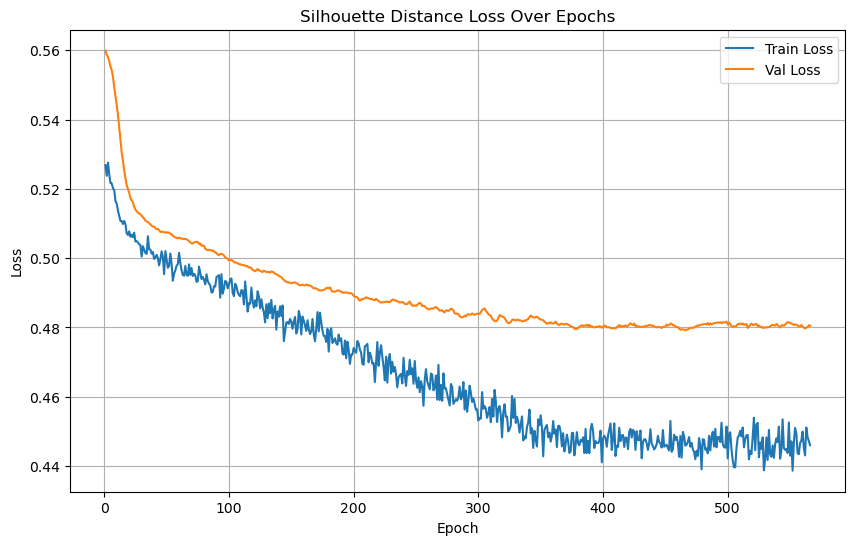

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/73], Loss: 0.3121
Test Batch [20/73], Loss: 0.1568
Test Batch [30/73], Loss: 0.3146
Test Batch [40/73], Loss: 0.5000
Test Batch [50/73], Loss: 0.3988
Test Batch [60/73], Loss: 0.4335
Test Batch [70/73], Loss: 0.3303

Test Loss: 0.3300


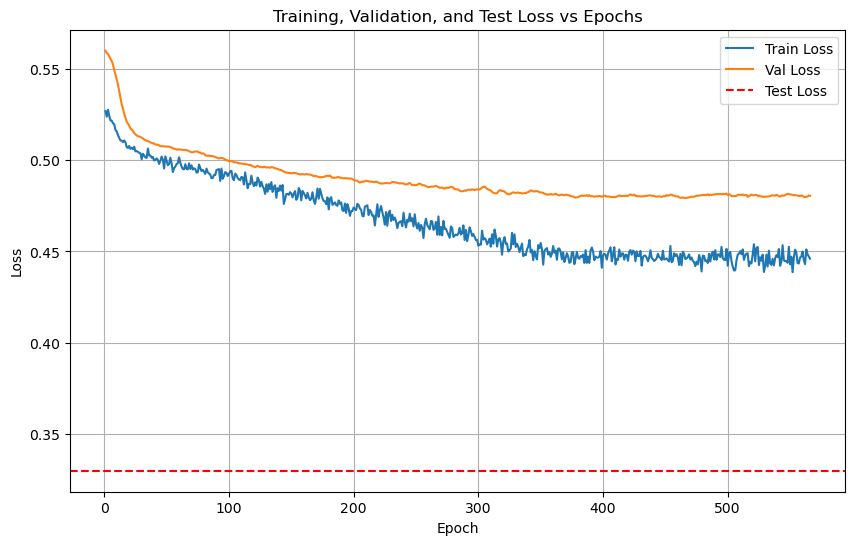

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/73 for test dataset.
  Processed batch 20/73 for test dataset.


  Processed batch 30/73 for test dataset.
  Processed batch 40/73 for test dataset.
  Processed batch 50/73 for test dataset.


  Processed batch 60/73 for test dataset.
  Processed batch 70/73 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 63.08%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.60      0.55         5
           1       0.00      0.00      0.00         5
           2       0.71      1.00      0.83         5
           3       1.00      0.20      0.33         5
           4       0.38      0.60      0.46         5
           5       0.50      0.40      0.44         5
           6       0.80      0.80      0.80         5
           7       0.50      0.80      0.62         5
           8       0.83      1.00      0.91         5
           9       0.40      0.40      0.40         5
          10       1.00      1.00      1.00         5
          11       0.75      0.60      0.67         5
          12       0.80      0.80      0.80         5

    accuracy         

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (520, 128)
Train labels shape: (520,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (4626, 128)
Test labels shape: (4626,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5566  |  Val Loss: 2.5500
Validation loss improved from inf to 2.5500.
[Epoch 2/1000] Train Loss: 2.5243  |  Val Loss: 2.5365
Validation loss improved from 2.5500 to 2.5365.
[Epoch 3/1000] Train Loss: 2.5054  |  Val Loss: 2.5274
Validation loss improved from 2.5365 to 2.5274.
[Epoch 4/1000] Train Loss: 2.4905  |  Val Loss: 2.5208
Validation loss improved from 2.5274 to 2.5208.
[Epoch 5/1000] Train Loss: 2.4784  |  Val Loss: 2.5154
Validation loss improved from 2.5208 to 2.5154.
[Epoch 6/1000] Train Loss: 2.4683  |  Val Loss: 2.5110
Validation loss improved from 2.5154 to 2.5110.


[Epoch 7/1000] Train Loss: 2.4588  |  Val Loss: 2.5068
Validation loss improved from 2.5110 to 2.5068.
[Epoch 8/1000] Train Loss: 2.4500  |  Val Loss: 2.5029
Validation loss improved from 2.5068 to 2.5029.


[Epoch 9/1000] Train Loss: 2.4409  |  Val Loss: 2.4982
Validation loss improved from 2.5029 to 2.4982.
[Epoch 10/1000] Train Loss: 2.4316  |  Val Loss: 2.4935
Validation loss improved from 2.4982 to 2.4935.
[Epoch 11/1000] Train Loss: 2.4221  |  Val Loss: 2.4892
Validation loss improved from 2.4935 to 2.4892.
[Epoch 12/1000] Train Loss: 2.4127  |  Val Loss: 2.4852
Validation loss improved from 2.4892 to 2.4852.


[Epoch 13/1000] Train Loss: 2.4032  |  Val Loss: 2.4824
Validation loss improved from 2.4852 to 2.4824.
[Epoch 14/1000] Train Loss: 2.3940  |  Val Loss: 2.4802
Validation loss improved from 2.4824 to 2.4802.
[Epoch 15/1000] Train Loss: 2.3850  |  Val Loss: 2.4785
Validation loss improved from 2.4802 to 2.4785.
[Epoch 16/1000] Train Loss: 2.3758  |  Val Loss: 2.4773
Validation loss improved from 2.4785 to 2.4773.
[Epoch 17/1000] Train Loss: 2.3665  |  Val Loss: 2.4769
Validation loss improved from 2.4773 to 2.4769.
[Epoch 18/1000] Train Loss: 2.3576  |  Val Loss: 2.4753
Validation loss improved from 2.4769 to 2.4753.


[Epoch 19/1000] Train Loss: 2.3472  |  Val Loss: 2.4729
Validation loss improved from 2.4753 to 2.4729.
[Epoch 20/1000] Train Loss: 2.3372  |  Val Loss: 2.4698
Validation loss improved from 2.4729 to 2.4698.
[Epoch 21/1000] Train Loss: 2.3265  |  Val Loss: 2.4680
Validation loss improved from 2.4698 to 2.4680.


[Epoch 22/1000] Train Loss: 2.3163  |  Val Loss: 2.4669
Validation loss improved from 2.4680 to 2.4669.
[Epoch 23/1000] Train Loss: 2.3061  |  Val Loss: 2.4662
Validation loss improved from 2.4669 to 2.4662.
[Epoch 24/1000] Train Loss: 2.2953  |  Val Loss: 2.4662
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 25/1000] Train Loss: 2.2844  |  Val Loss: 2.4660
Validation loss improved from 2.4662 to 2.4660.
[Epoch 26/1000] Train Loss: 2.2740  |  Val Loss: 2.4660
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 2.2641  |  Val Loss: 2.4669
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 28/1000] Train Loss: 2.2533  |  Val Loss: 2.4674
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 29/1000] Train Loss: 2.2429  |  Val Loss: 2.4677
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 30/1000] Train Loss: 2.2329  |  Val Loss: 2.4680
!! Validation loss did NOT improve !! Patience: 5/100


[Epoch 31/1000] Train Loss: 2.2230  |  Val Loss: 2.4687
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 32/1000] Train Loss: 2.2138  |  Val Loss: 2.4697
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 33/1000] Train Loss: 2.2044  |  Val Loss: 2.4691
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 34/1000] Train Loss: 2.1951  |  Val Loss: 2.4697
!! Validation loss did NOT improve !! Patience: 9/100


[Epoch 35/1000] Train Loss: 2.1862  |  Val Loss: 2.4708
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 36/1000] Train Loss: 2.1771  |  Val Loss: 2.4722
!! Validation loss did NOT improve !! Patience: 11/100


[Epoch 37/1000] Train Loss: 2.1678  |  Val Loss: 2.4733
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 38/1000] Train Loss: 2.1581  |  Val Loss: 2.4759
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 39/1000] Train Loss: 2.1487  |  Val Loss: 2.4766
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 40/1000] Train Loss: 2.1392  |  Val Loss: 2.4773
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 41/1000] Train Loss: 2.1302  |  Val Loss: 2.4789
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 42/1000] Train Loss: 2.1201  |  Val Loss: 2.4801
!! Validation loss did NOT improve !! Patience: 17/100


[Epoch 43/1000] Train Loss: 2.1099  |  Val Loss: 2.4817
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 44/1000] Train Loss: 2.0999  |  Val Loss: 2.4839
!! Validation loss did NOT improve !! Patience: 19/100


[Epoch 45/1000] Train Loss: 2.0899  |  Val Loss: 2.4850
!! Validation loss did NOT improve !! Patience: 20/100


[Epoch 46/1000] Train Loss: 2.0794  |  Val Loss: 2.4858
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 47/1000] Train Loss: 2.0694  |  Val Loss: 2.4878
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 48/1000] Train Loss: 2.0591  |  Val Loss: 2.4890
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 49/1000] Train Loss: 2.0488  |  Val Loss: 2.4891
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 50/1000] Train Loss: 2.0390  |  Val Loss: 2.4903
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 51/1000] Train Loss: 2.0286  |  Val Loss: 2.4947
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 52/1000] Train Loss: 2.0184  |  Val Loss: 2.4992
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 53/1000] Train Loss: 2.0085  |  Val Loss: 2.5035
!! Validation loss did NOT improve !! Patience: 28/100


[Epoch 54/1000] Train Loss: 1.9983  |  Val Loss: 2.5046
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 55/1000] Train Loss: 1.9877  |  Val Loss: 2.5063
!! Validation loss did NOT improve !! Patience: 30/100


[Epoch 56/1000] Train Loss: 1.9781  |  Val Loss: 2.5084
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 57/1000] Train Loss: 1.9679  |  Val Loss: 2.5133
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 58/1000] Train Loss: 1.9579  |  Val Loss: 2.5173
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 59/1000] Train Loss: 1.9486  |  Val Loss: 2.5176
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 60/1000] Train Loss: 1.9383  |  Val Loss: 2.5197
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 61/1000] Train Loss: 1.9286  |  Val Loss: 2.5207
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 62/1000] Train Loss: 1.9183  |  Val Loss: 2.5217
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 63/1000] Train Loss: 1.9081  |  Val Loss: 2.5233
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 64/1000] Train Loss: 1.8979  |  Val Loss: 2.5248
!! Validation loss did NOT improve !! Patience: 39/100


[Epoch 65/1000] Train Loss: 1.8874  |  Val Loss: 2.5272
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 66/1000] Train Loss: 1.8773  |  Val Loss: 2.5281
!! Validation loss did NOT improve !! Patience: 41/100


[Epoch 67/1000] Train Loss: 1.8672  |  Val Loss: 2.5289
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 68/1000] Train Loss: 1.8572  |  Val Loss: 2.5310
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 69/1000] Train Loss: 1.8474  |  Val Loss: 2.5307
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 70/1000] Train Loss: 1.8370  |  Val Loss: 2.5305
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 71/1000] Train Loss: 1.8271  |  Val Loss: 2.5318
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 72/1000] Train Loss: 1.8168  |  Val Loss: 2.5329
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 73/1000] Train Loss: 1.8068  |  Val Loss: 2.5356
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 74/1000] Train Loss: 1.7964  |  Val Loss: 2.5360
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 75/1000] Train Loss: 1.7866  |  Val Loss: 2.5382
!! Validation loss did NOT improve !! Patience: 50/100
[

[Epoch 77/1000] Train Loss: 1.7663  |  Val Loss: 2.5388
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 78/1000] Train Loss: 1.7566  |  Val Loss: 2.5394
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 79/1000] Train Loss: 1.7474  |  Val Loss: 2.5410
!! Validation loss did NOT improve !! Patience: 54/100


[Epoch 80/1000] Train Loss: 1.7397  |  Val Loss: 2.5444
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 81/1000] Train Loss: 1.7285  |  Val Loss: 2.5520
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 82/1000] Train Loss: 1.7196  |  Val Loss: 2.5549
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 83/1000] Train Loss: 1.7106  |  Val Loss: 2.5553
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 84/1000] Train Loss: 1.7011  |  Val Loss: 2.5559
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 85/1000] Train Loss: 1.6915  |  Val Loss: 2.5580
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 86/1000] Train Loss: 1.6823  |  Val Loss: 2.5645
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 87/1000] Train Loss: 1.6732  |  Val Loss: 2.5690
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 88/1000] Train Loss: 1.6635  |  Val Loss: 2.5686
!! Validation loss did NOT improve !! Patience: 63/100
[

[Epoch 90/1000] Train Loss: 1.6448  |  Val Loss: 2.5675
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 91/1000] Train Loss: 1.6358  |  Val Loss: 2.5710
!! Validation loss did NOT improve !! Patience: 66/100


[Epoch 92/1000] Train Loss: 1.6267  |  Val Loss: 2.5765
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 93/1000] Train Loss: 1.6173  |  Val Loss: 2.5801
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 94/1000] Train Loss: 1.6082  |  Val Loss: 2.5818
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 95/1000] Train Loss: 1.5985  |  Val Loss: 2.5776
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 96/1000] Train Loss: 1.5893  |  Val Loss: 2.5756
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 97/1000] Train Loss: 1.5802  |  Val Loss: 2.5748
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 98/1000] Train Loss: 1.5710  |  Val Loss: 2.5823
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 99/1000] Train Loss: 1.5617  |  Val Loss: 2.5876
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 100/1000] Train Loss: 1.5524  |  Val Loss: 2.5865
!! Validation loss did NOT improve !! Patience: 75/100


[Epoch 102/1000] Train Loss: 1.5330  |  Val Loss: 2.5854
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 103/1000] Train Loss: 1.5232  |  Val Loss: 2.5895
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 104/1000] Train Loss: 1.5137  |  Val Loss: 2.5916
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 105/1000] Train Loss: 1.5040  |  Val Loss: 2.5906
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 106/1000] Train Loss: 1.4943  |  Val Loss: 2.5963
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 107/1000] Train Loss: 1.4844  |  Val Loss: 2.6039
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 108/1000] Train Loss: 1.4748  |  Val Loss: 2.6170
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 109/1000] Train Loss: 1.4650  |  Val Loss: 2.6181
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 110/1000] Train Loss: 1.4552  |  Val Loss: 2.6142
!! Validation loss did NOT improve !! Patience:

[Epoch 114/1000] Train Loss: 1.4171  |  Val Loss: 2.6244
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 115/1000] Train Loss: 1.4070  |  Val Loss: 2.6332
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 116/1000] Train Loss: 1.3972  |  Val Loss: 2.6360
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 117/1000] Train Loss: 1.3876  |  Val Loss: 2.6407
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 118/1000] Train Loss: 1.3779  |  Val Loss: 2.6390
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 119/1000] Train Loss: 1.3679  |  Val Loss: 2.6413
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 120/1000] Train Loss: 1.3589  |  Val Loss: 2.6437
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 121/1000] Train Loss: 1.3492  |  Val Loss: 2.6530
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 122/1000] Train Loss: 1.3399  |  Val Loss: 2.6480
!! Validation loss did NOT improve !! Patience:

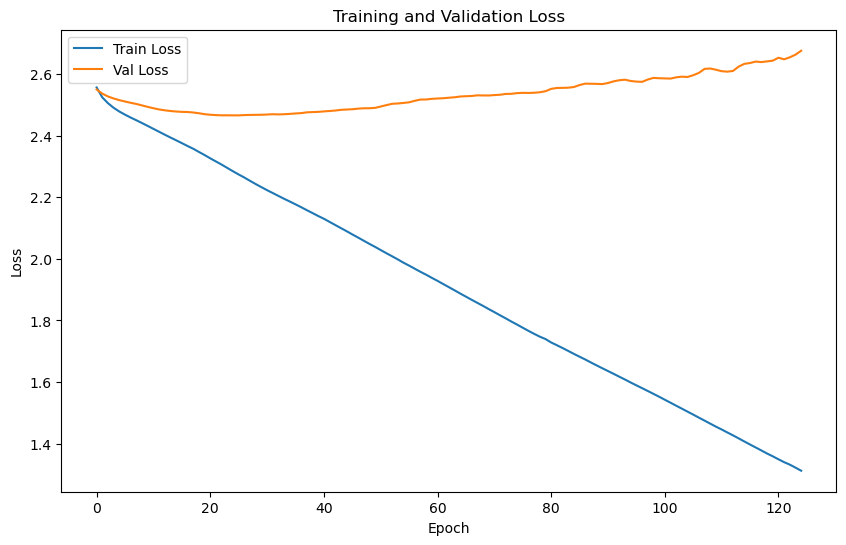

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.6500 | Test Accuracy: 47.80%


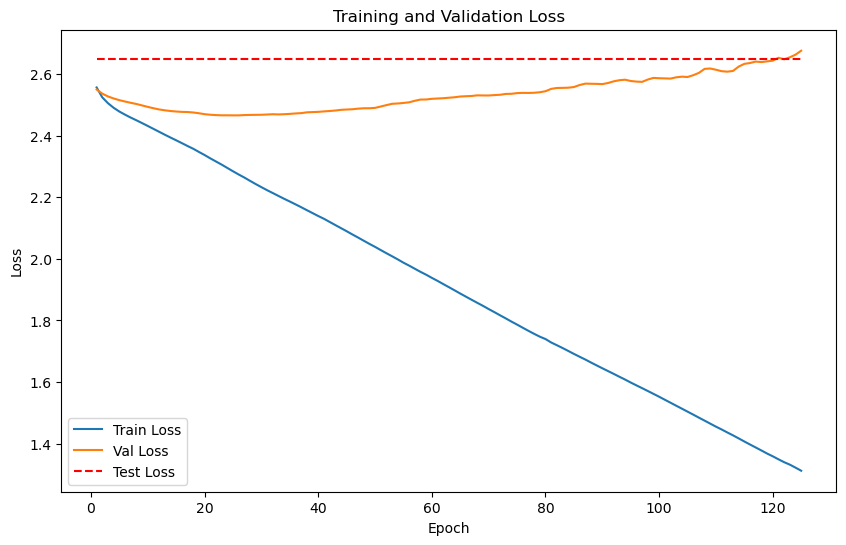

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


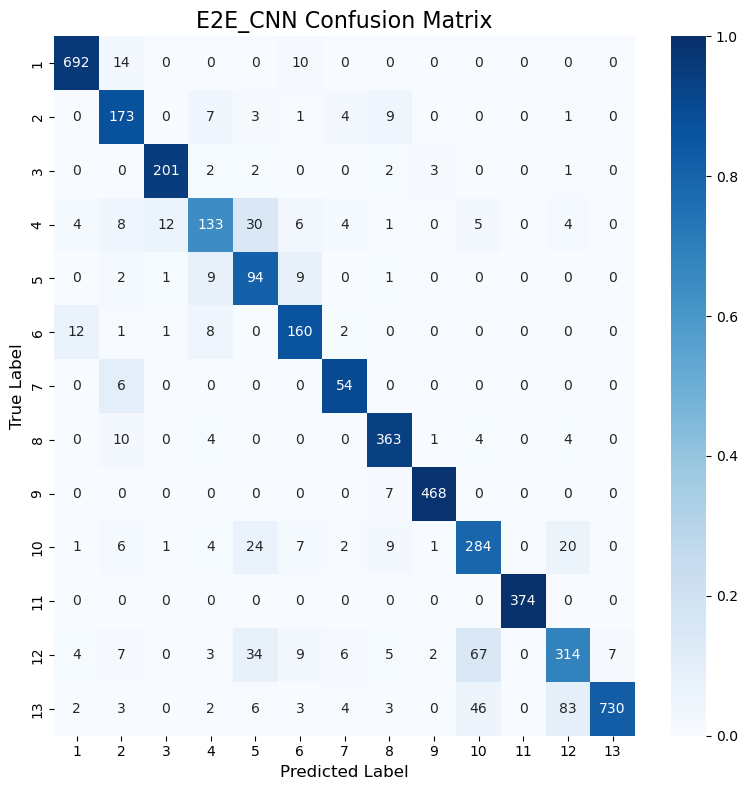

Classification Accuracy: 87.33%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


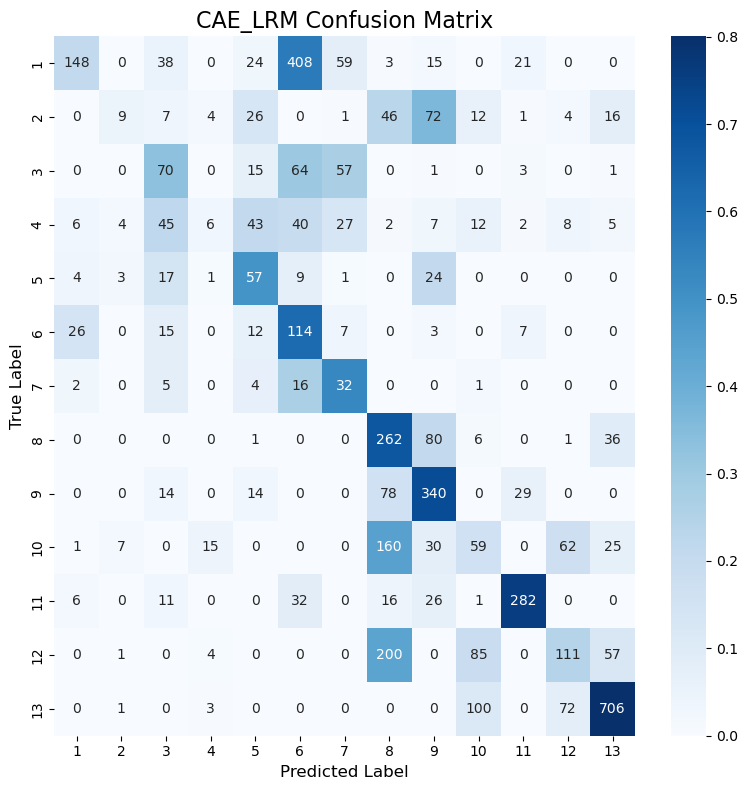

Classification Accuracy: 47.47%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


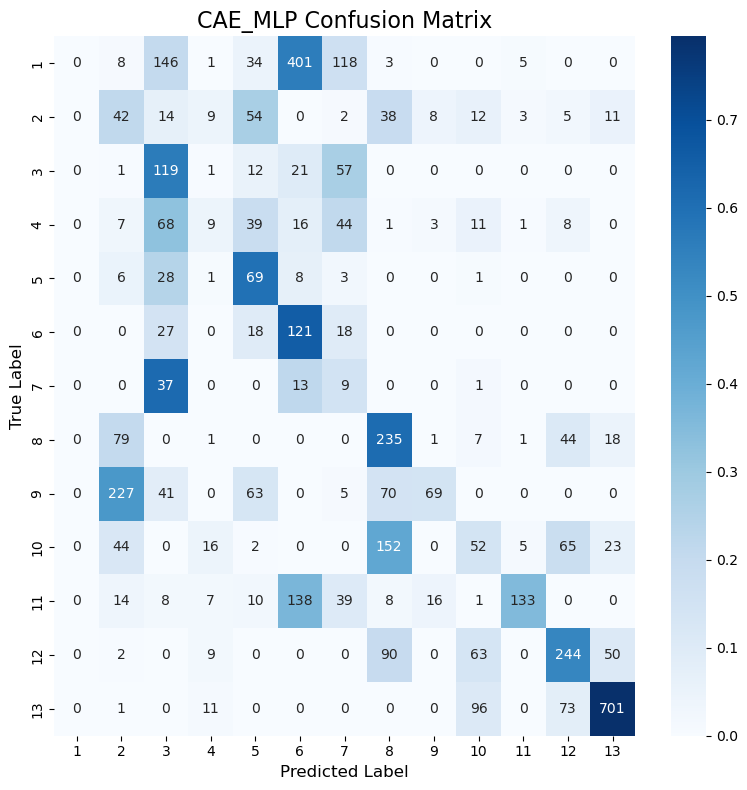

Classification Accuracy: 38.98%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


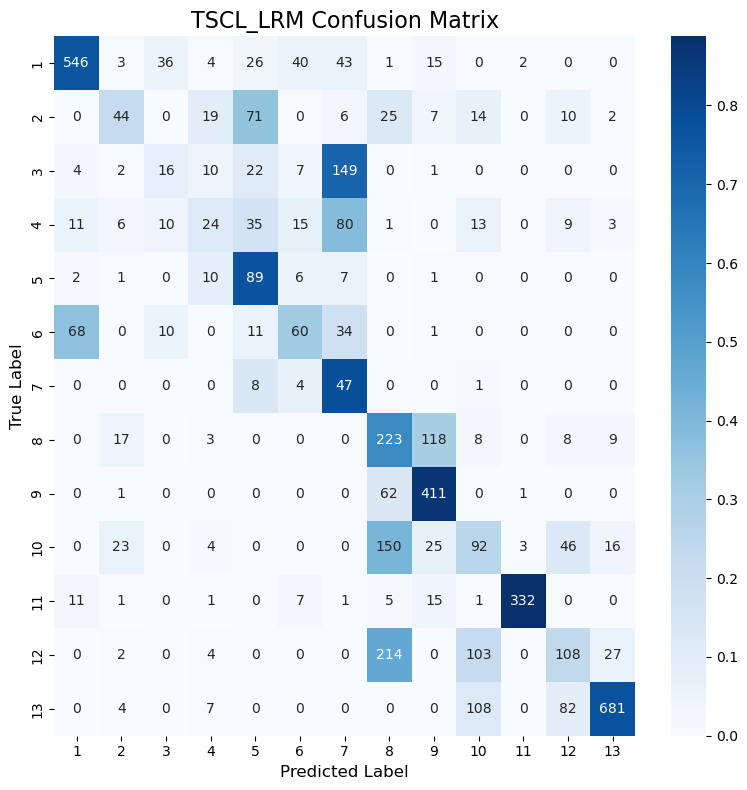

Classification Accuracy: 57.78%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


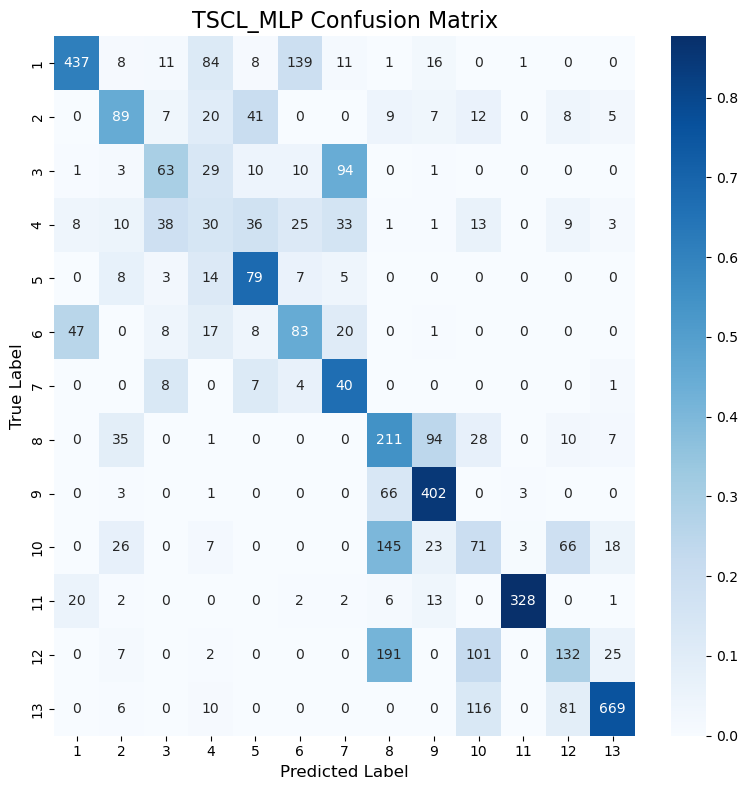

Classification Accuracy: 56.94%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


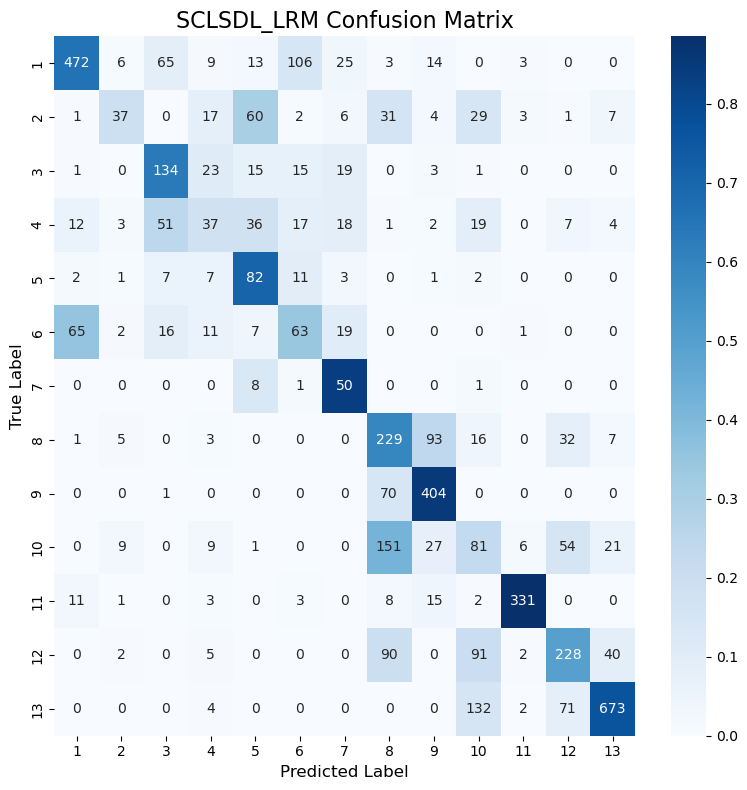

Classification Accuracy: 60.98%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


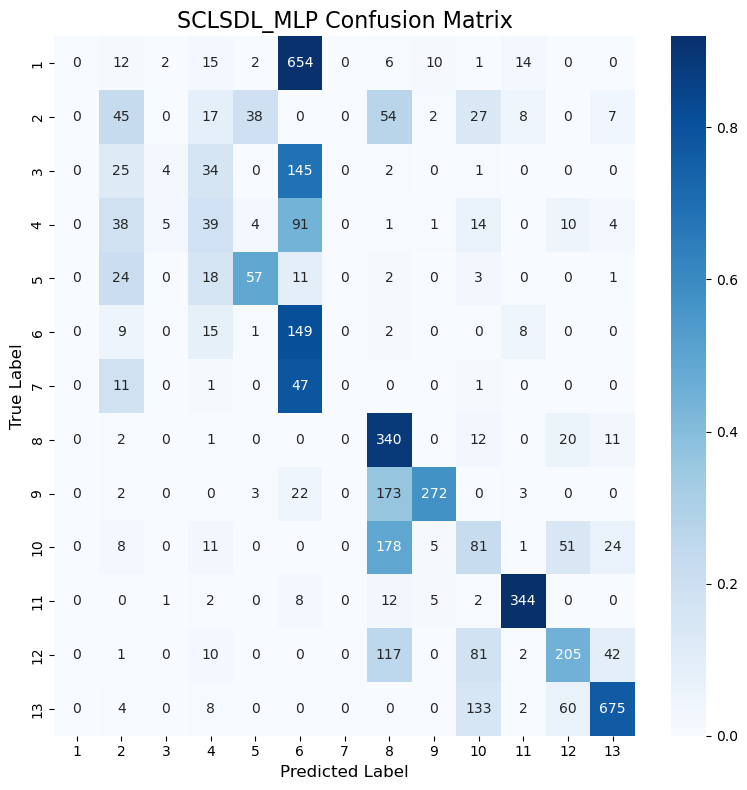

Classification Accuracy: 47.80%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.33
1    LRM (CAE)          47.47
2    MLP (CAE)          38.98
3     TSCL LRM          57.78
4     TSCL MLP          56.94
5  SCL_SDL LRM          60.98
6  SCL_SDL MLP          47.80

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.33
5  SCL_SDL LRM          60.98
3     TSCL LRM          57.78
4     TSCL MLP          56.94
6  SCL_SDL MLP          47.80
1    LRM (CAE)          47.47
2    MLP (CAE)          38.98
